In [1]:
###R Code for Individual Subject Modeling###

#Required packages
library(dplyr)
library(ggplot2)
library(mgcv)
library(purrr)
library(tidyr)
library(MASS)
library(gratia)

#Read data from Coding_Predictors.ipynb
df <- read.csv("IRT_data_updated_new.csv")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [2]:
# Retain the full data frame, omitting rows with NAs in abs_lag_ln and SemanticSimC
df_clean <- df[complete.cases(df$abs_lag_ln, df$SemanticSimC, df$IRT.1, df$IRT.2), ]

# Standardize abs_lag_ln and SemanticSimC
df_clean$abs_lag_ln_std <- scale(df_clean$abs_lag_ln)
df_clean$SemanticSimC_std <- scale(df_clean$SemanticSimC)

# Check for collinearity issues
cor_matrix_clean <- cor(df_clean[, c("OutputPosition", "total_recall", "abs_lag_ln", "SemanticSimC")])
print(cor_matrix_clean)

               OutputPosition total_recall  abs_lag_ln SemanticSimC
OutputPosition     1.00000000   0.54484193 -0.11177215  -0.02853407
total_recall       0.54484193   1.00000000 -0.17977240  -0.02649164
abs_lag_ln        -0.11177215  -0.17977240  1.00000000  -0.03463907
SemanticSimC      -0.02853407  -0.02649164 -0.03463907   1.00000000


In [4]:
###Create separate data frame for each subject###
dat <- df_clean

subject_data <- dat %>%
  group_by(subject) %>%
  nest()


In [6]:
###Fit GAM to each subject's raw IRT data###
#library(purrr)

subject_models <- subject_data %>%
  mutate(
    model = map(data, ~ gam(IRT ~ s(OutputPosition, k=5) + s(total_recall, k=5) + 
                                ti(OutputPosition, total_recall) + abs_lag_ln_std + 
                                SemanticSimC_std + ti(abs_lag_ln_std, SemanticSimC_std) + 
                                s(IRT1C, k=3) + s(IRT2C, k=3), data = .x))
  )

In [7]:
# Save the subject_models object for easy loading
saveRDS(subject_models, "subject_models.rds")

In [3]:
#skip the above steps by loading in subject_models.rds
subject_models <- readRDS("subject_models.rds")

In [10]:
##Sanity check to clarify the nature of subject_models##

# Access the linear model for the first subject
first_subject_model <- subject_models$model[[1]]
print(first_subject_model)
#summary(first_subject_model)


Family: gaussian 
Link function: identity 

Formula:
IRT ~ s(OutputPosition, k = 5) + s(total_recall, k = 5) + ti(OutputPosition, 
    total_recall) + abs_lag_ln_std + SemanticSimC_std + ti(abs_lag_ln_std, 
    SemanticSimC_std) + s(IRT1C, k = 3) + s(IRT2C, k = 3)

Estimated degrees of freedom:
 3.50  1.93  1.95 12.75  1.00  1.00  total = 25.13 

GCV score: 34.11417     


In [8]:
# Extract residuals from the saved models
subject_models_with_residuals <- subject_models %>%
  mutate(
    residuals = map(model, residuals)
  )

In [12]:
# View the column names of the object
colnames(subject_models_with_residuals)

[1] "subject"   "data"      "model"     "residuals"

In [21]:
# View the residuals for the first subject
subj1_resid <- subject_models_with_residuals$residuals[[1]]

# Extract the data for the first subject
subj1_data <- subject_models_with_residuals$data[[1]]

# Verify that the lengths match
length(subj1_resid) == nrow(subj1_data)

# Print the lengths for verification
length(subj1_resid)
nrow(subj1_data)

[1] TRUE

[1] 3187

[1] 3187

In [20]:
head(subj1_resid)

[1]  3.2198029  2.4718226  0.8693397  1.2660061 -4.2627258 -2.8674344

In [22]:
# Add residuals as a new column to each subject's data frame
subject_data_with_residuals <- subject_models_with_residuals %>%
  mutate(
    data = map2(data, residuals, ~ mutate(.x, residuals = .y))
  )

In [26]:
##Create adjusted residuals###
# Ensure residuals are positive by adding a constant
subject_data_with_residuals <- subject_data_with_residuals %>%
  mutate(
    data = map(data, ~ mutate(.x, adjusted_residuals = residuals - min(residuals) + 1))
  )

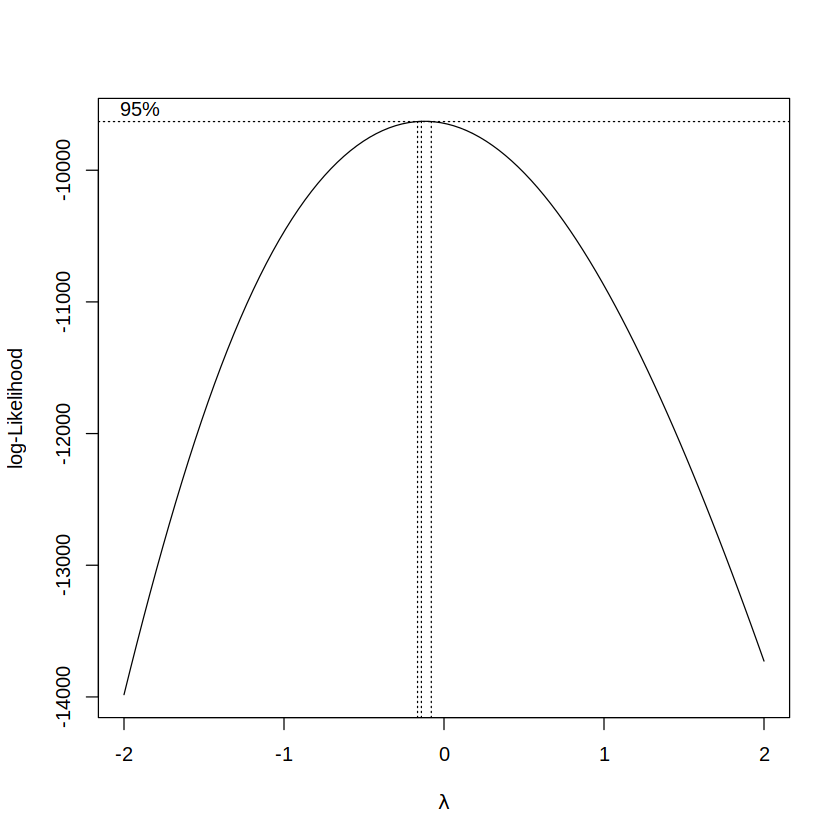

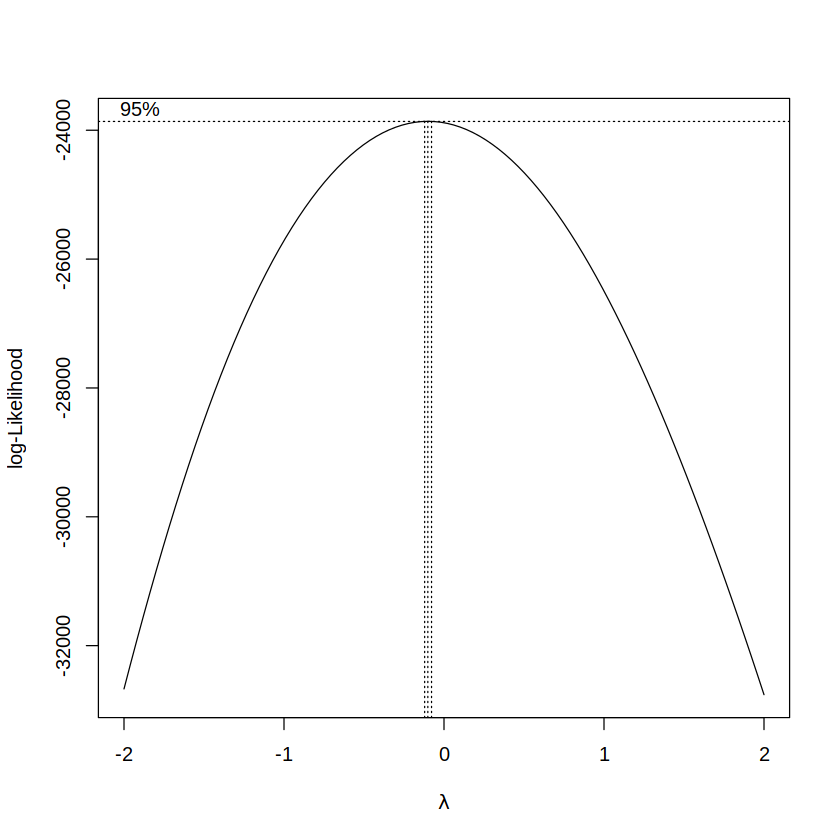

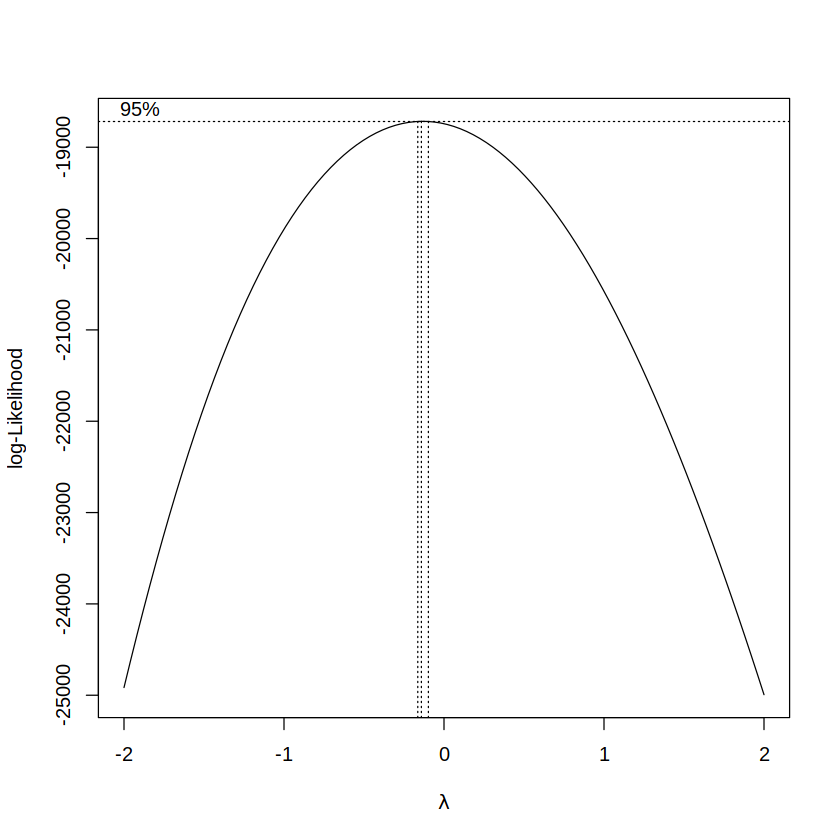

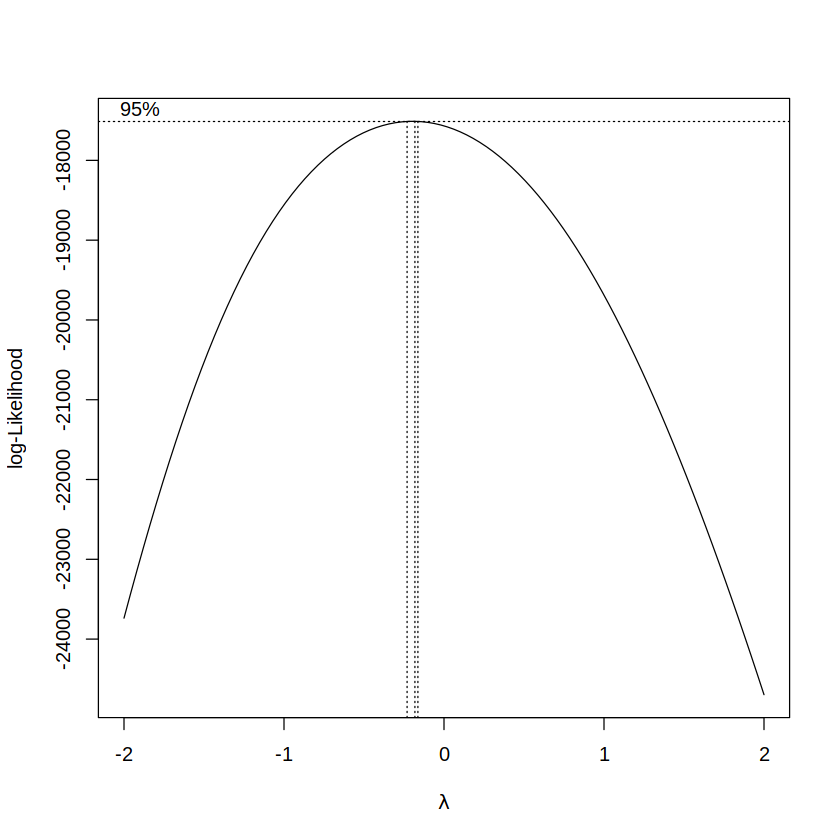

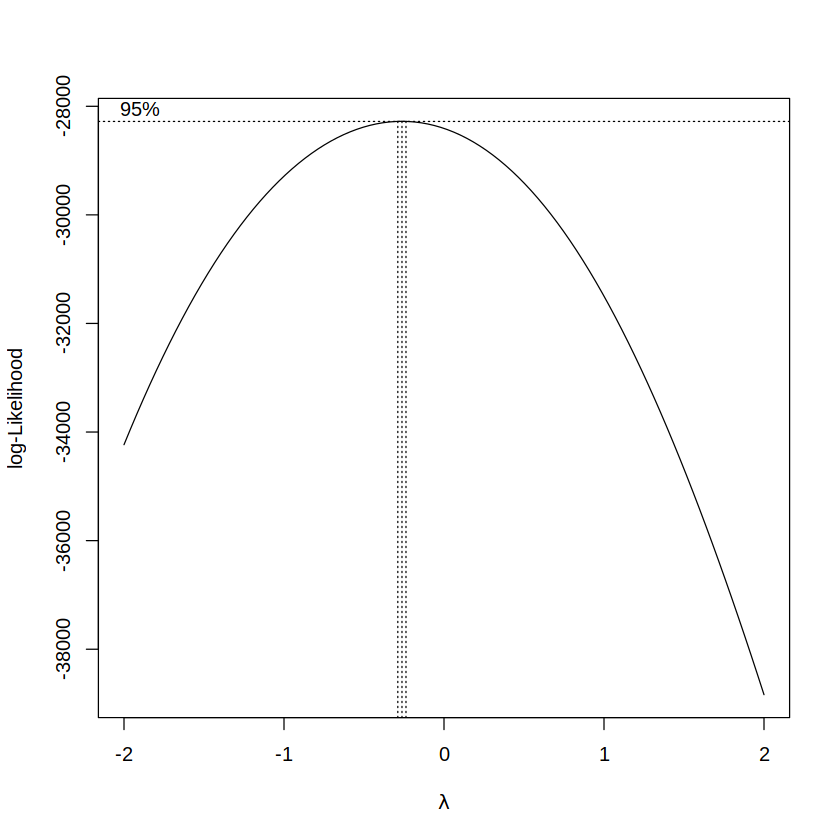

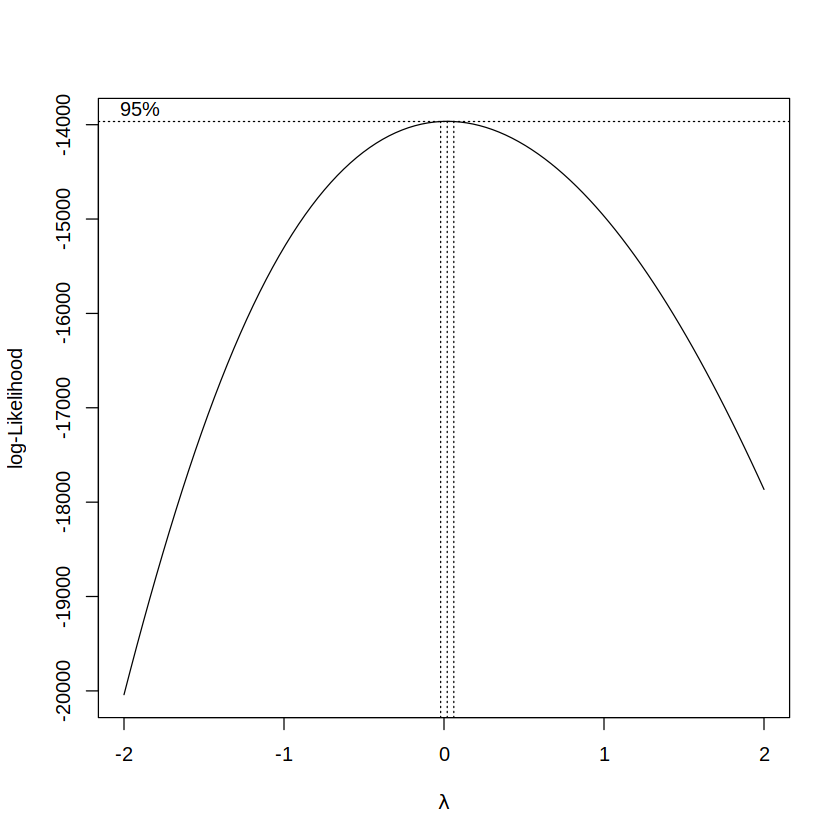

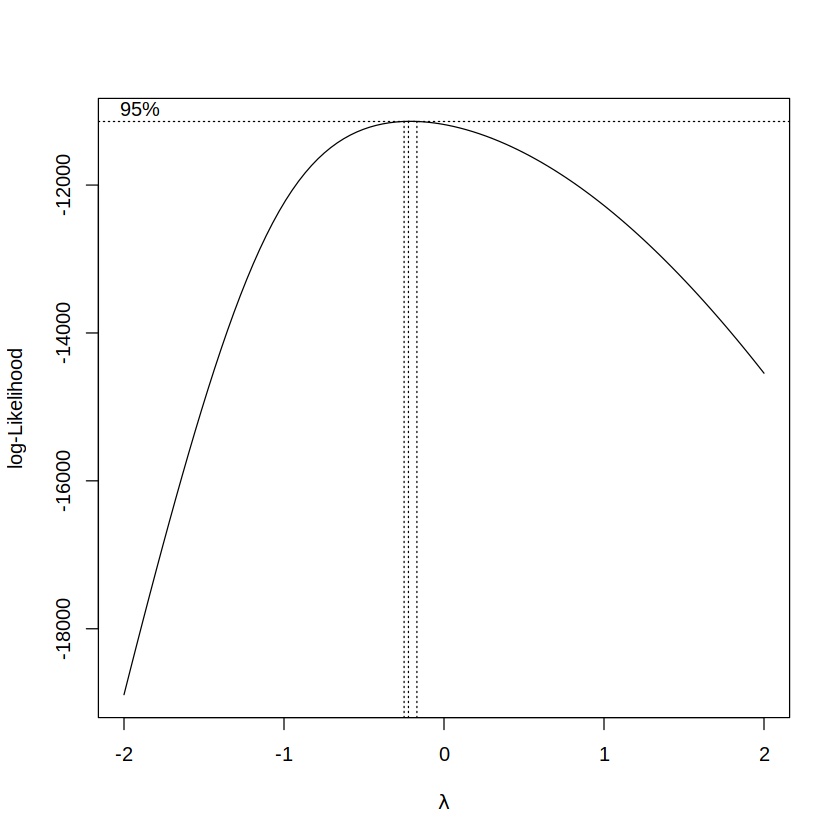

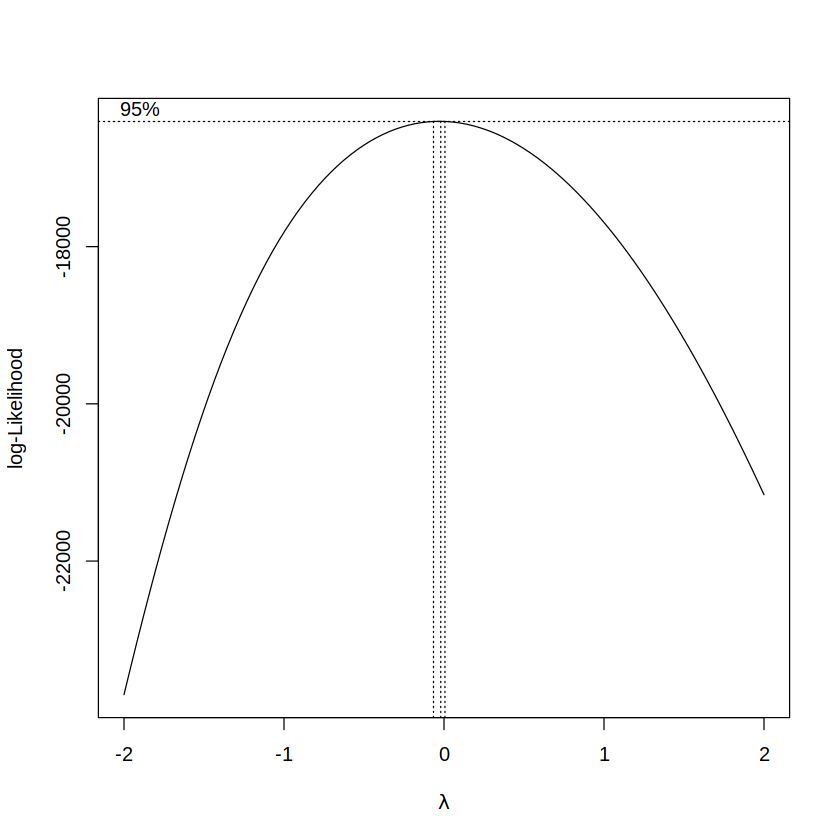

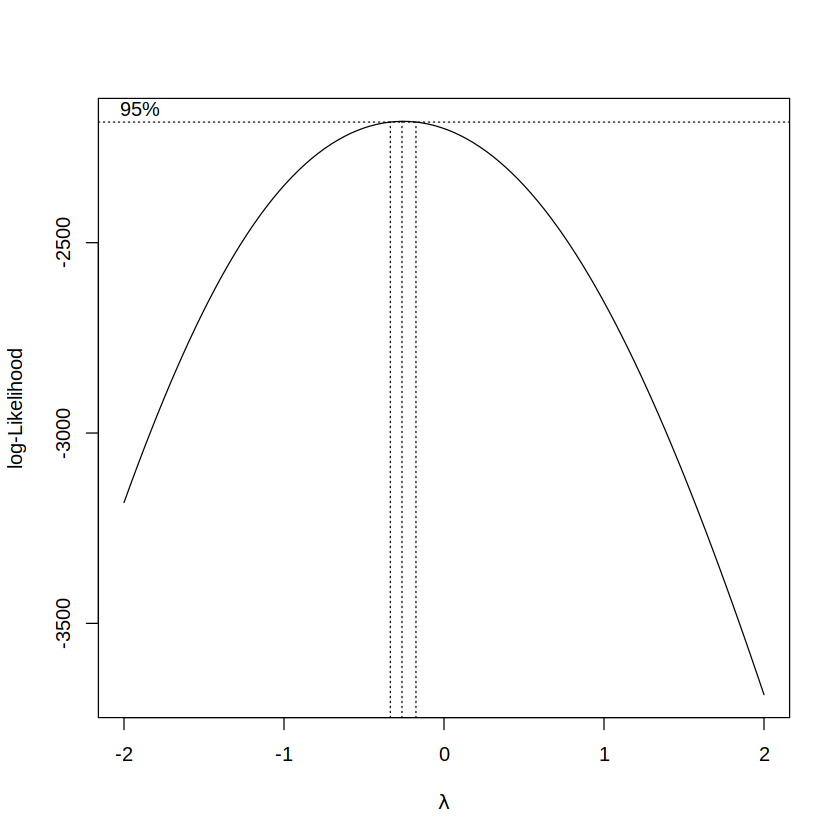

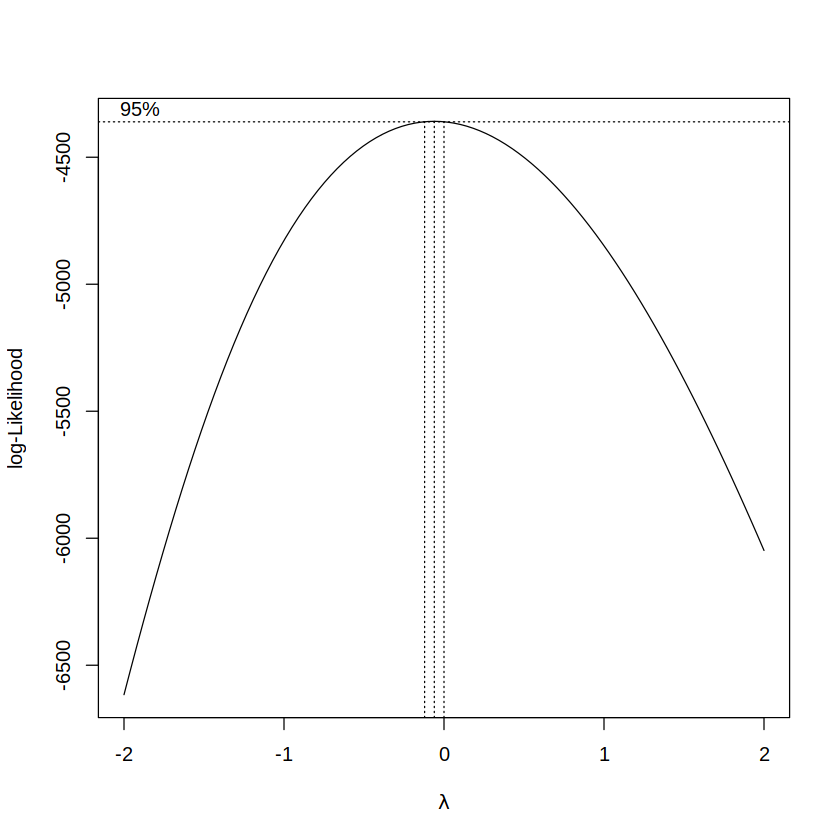

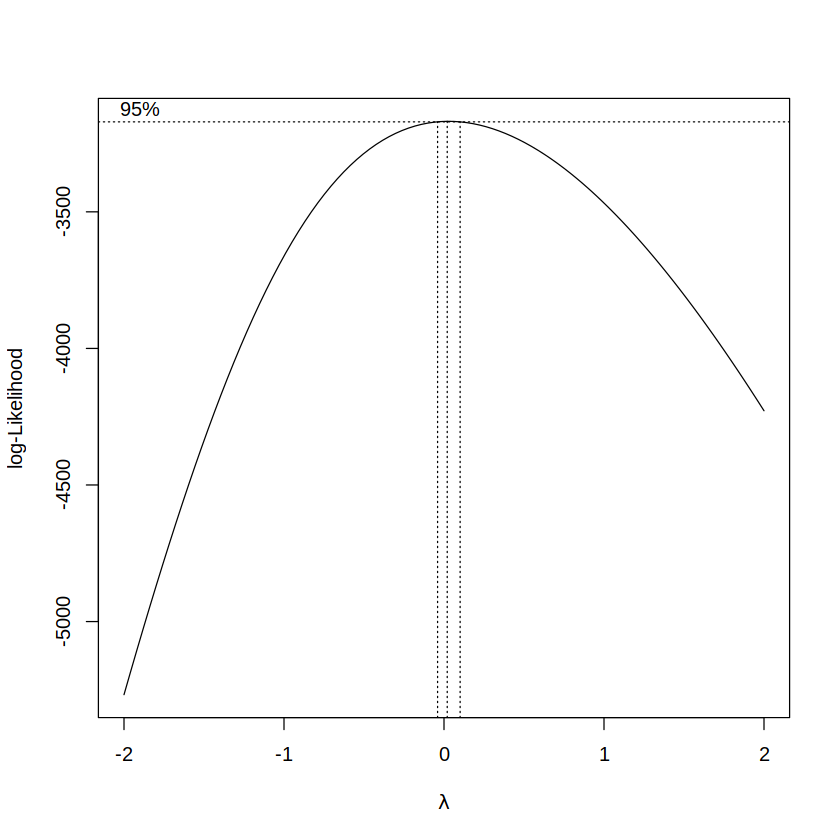

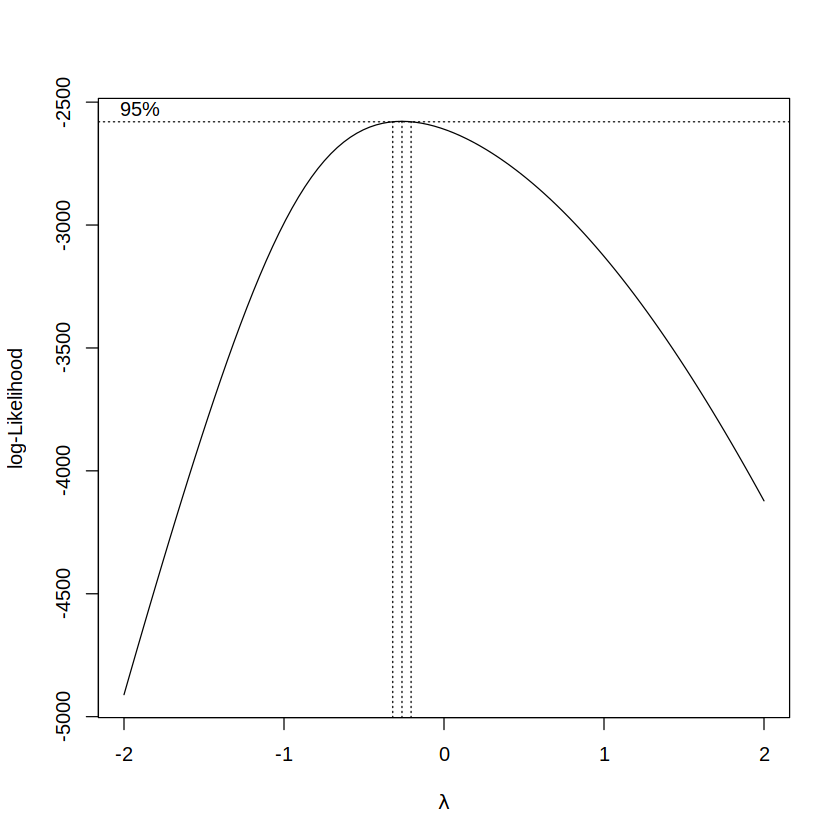

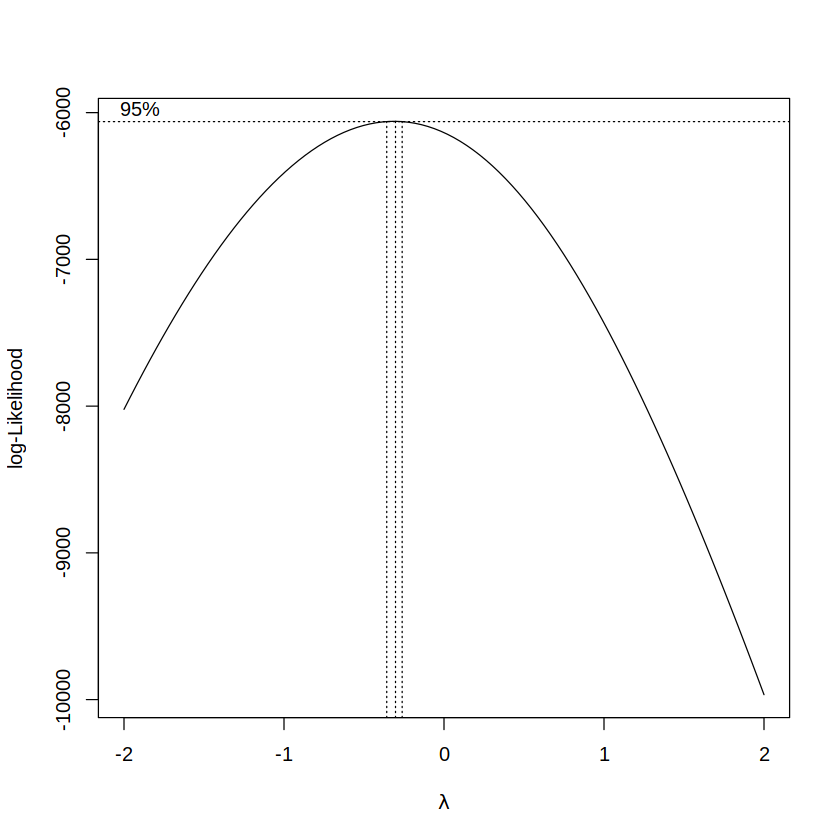

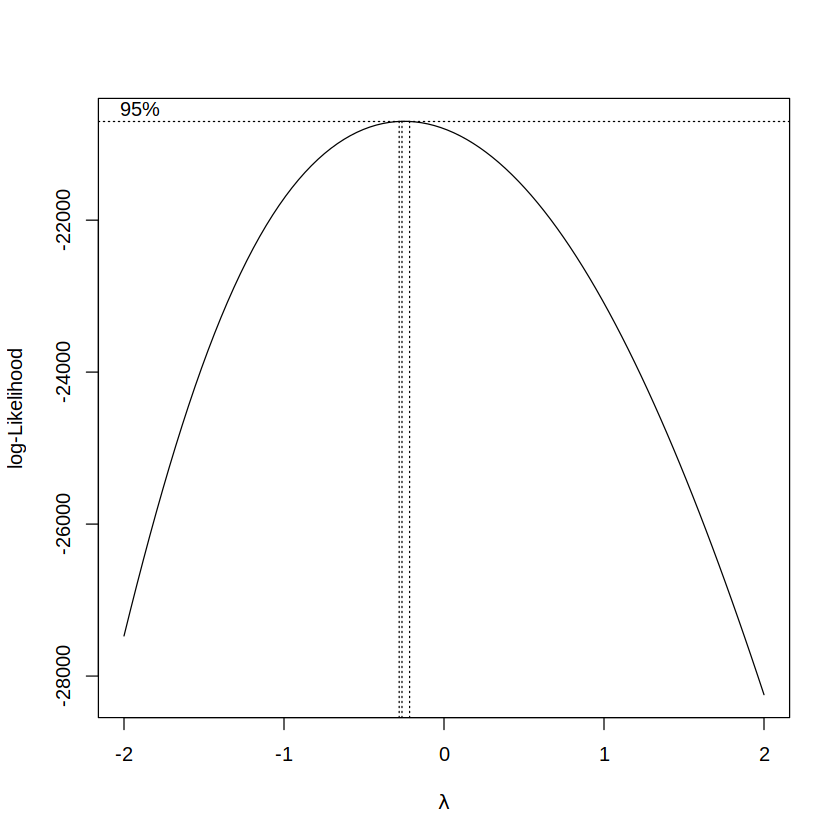

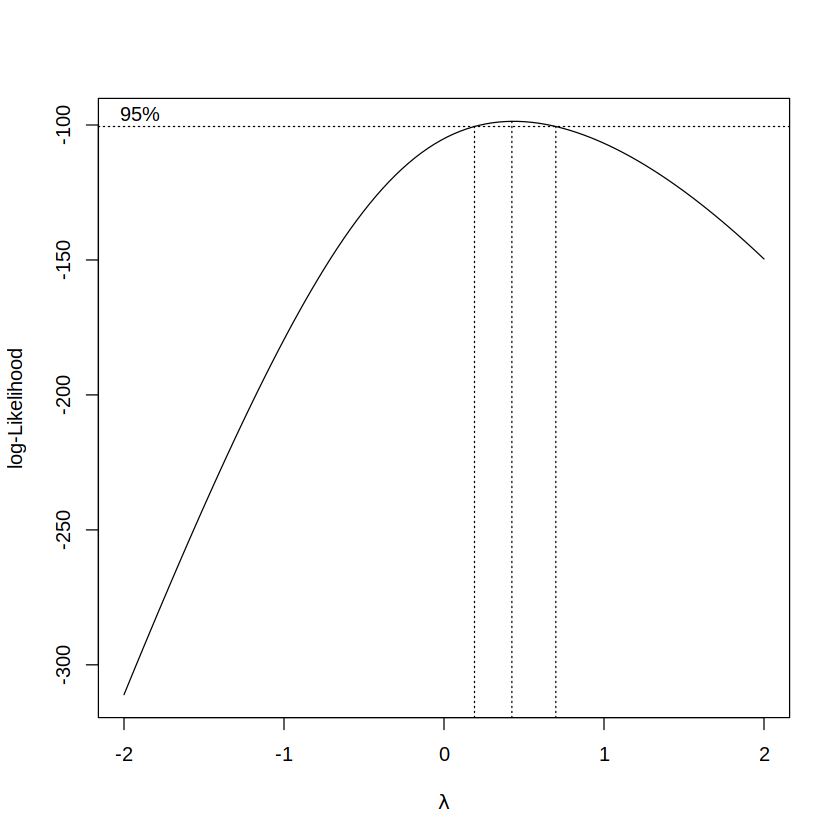

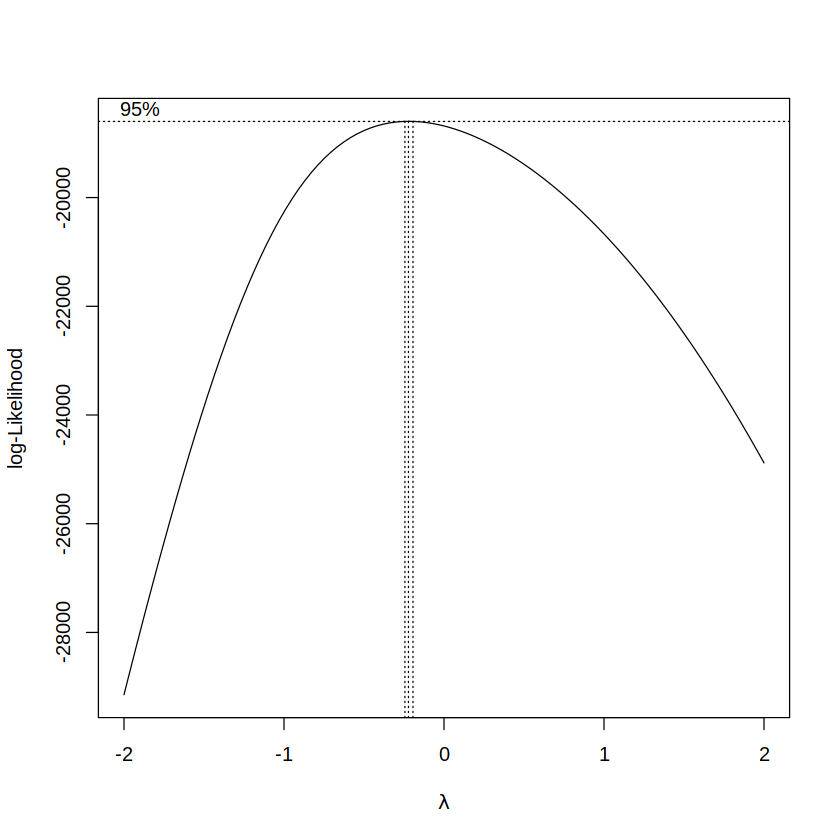

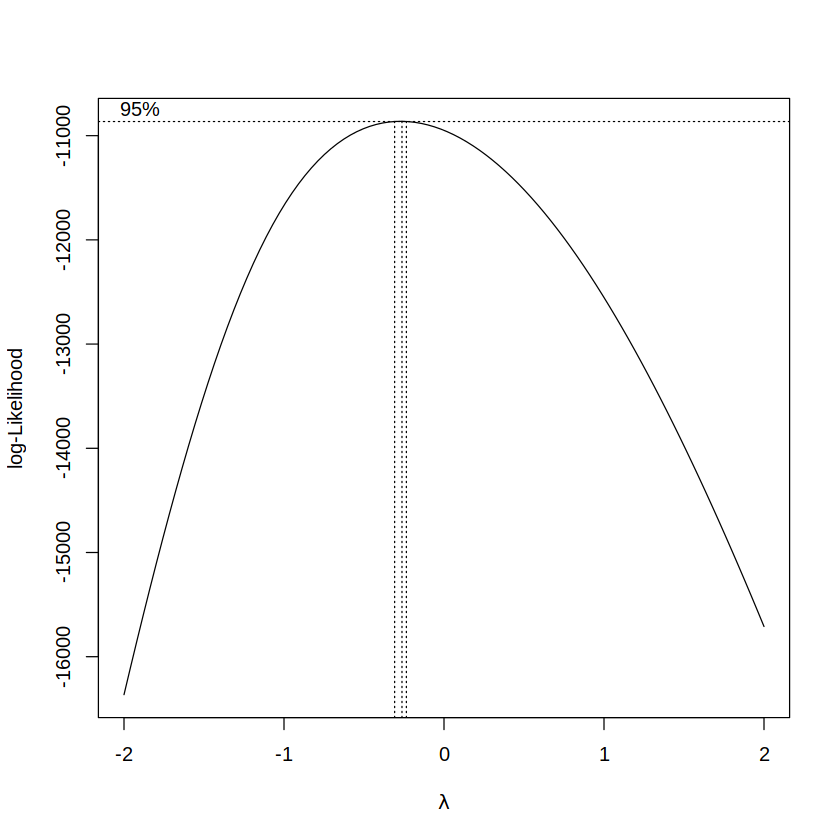

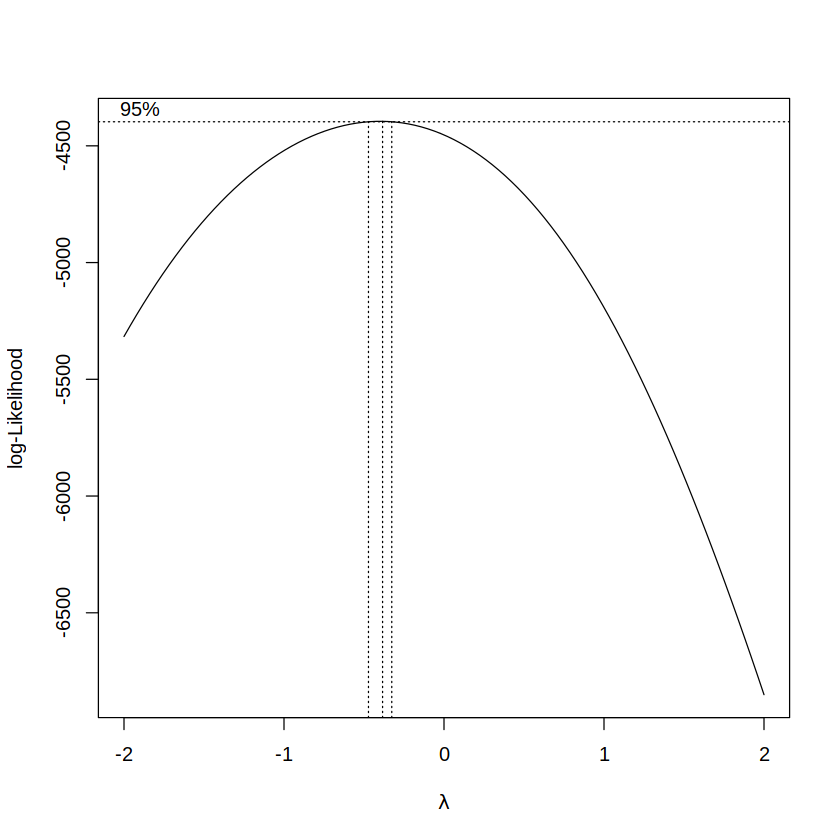

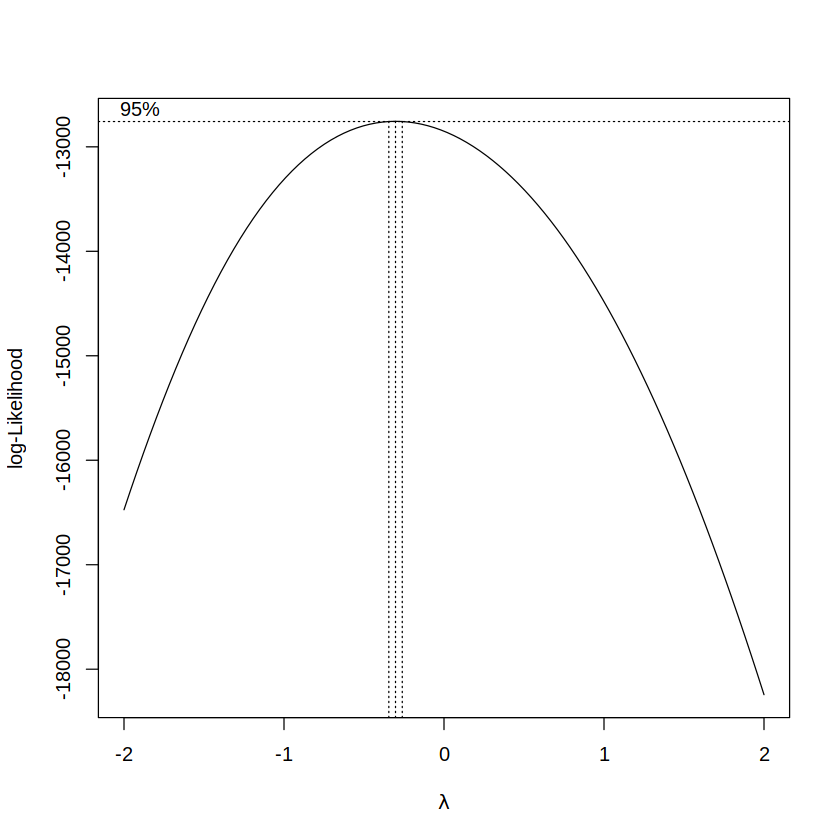

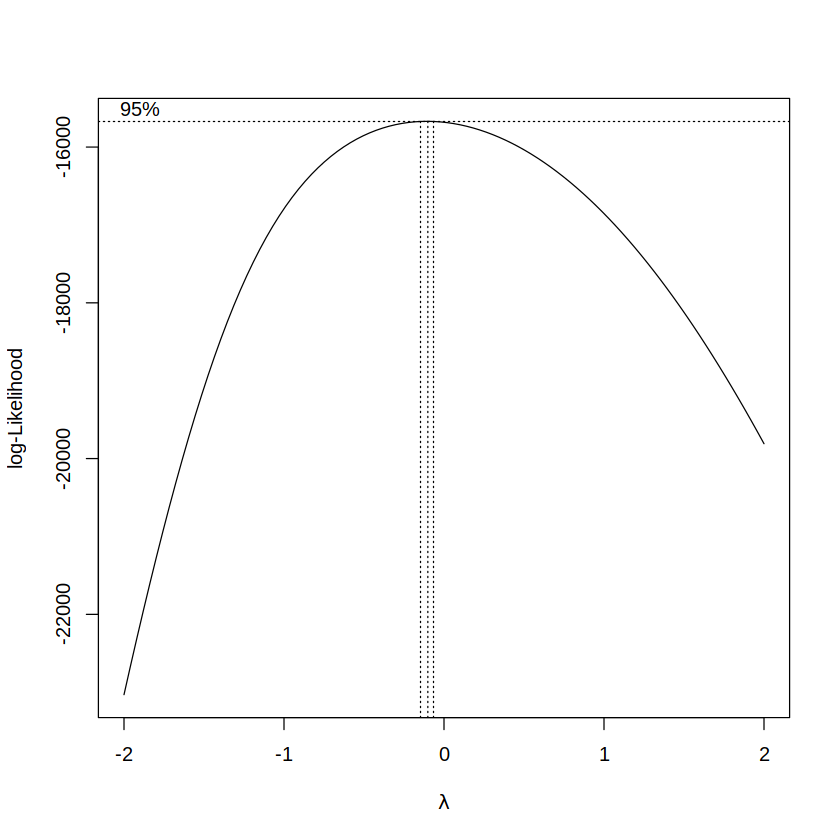

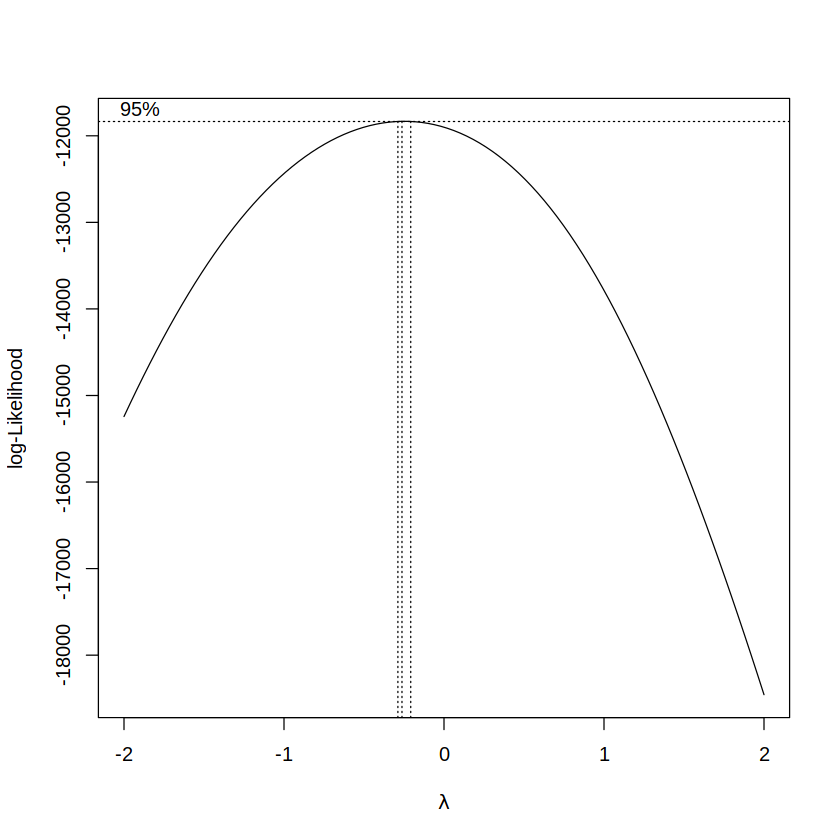

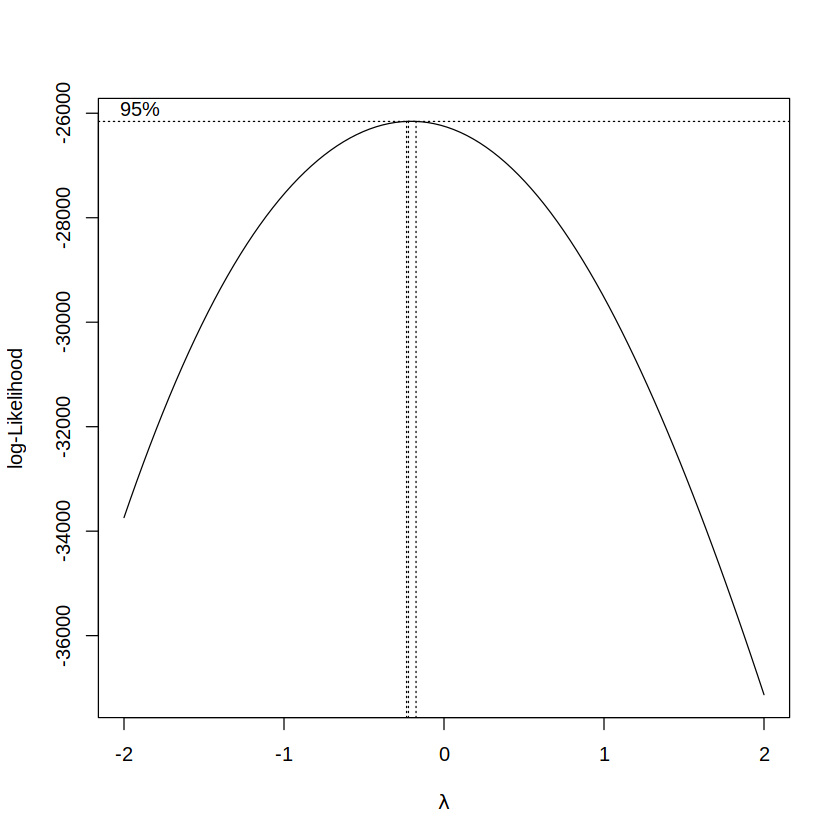

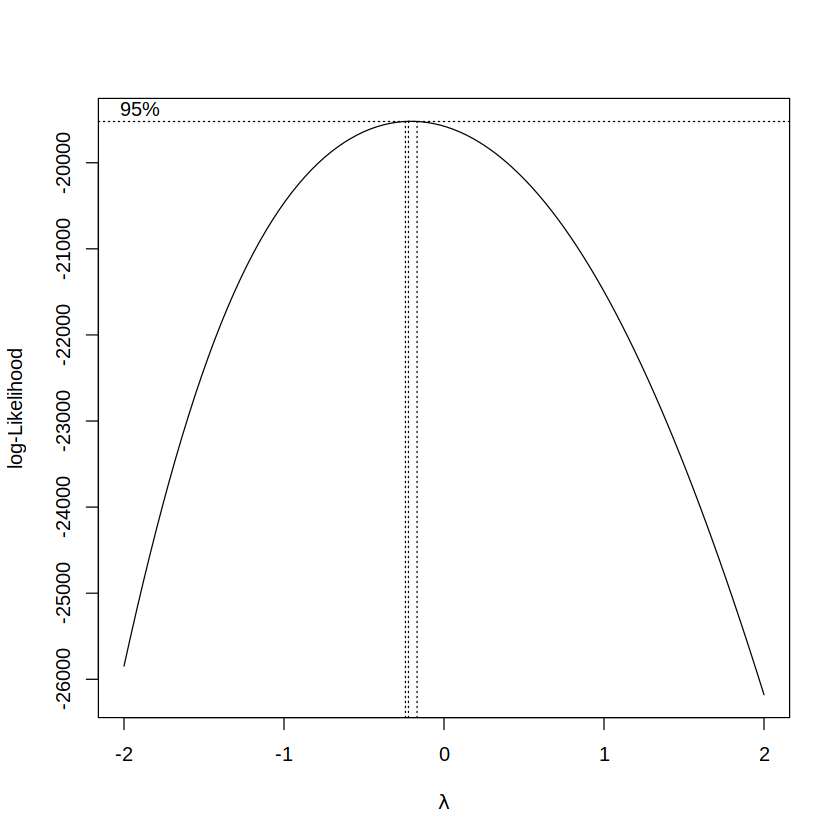

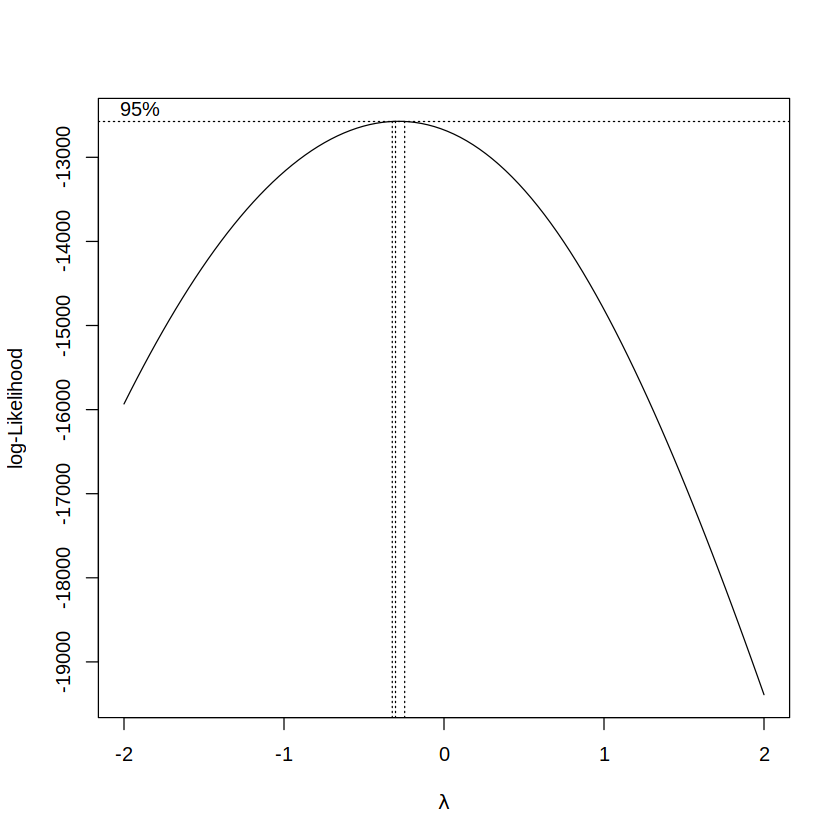

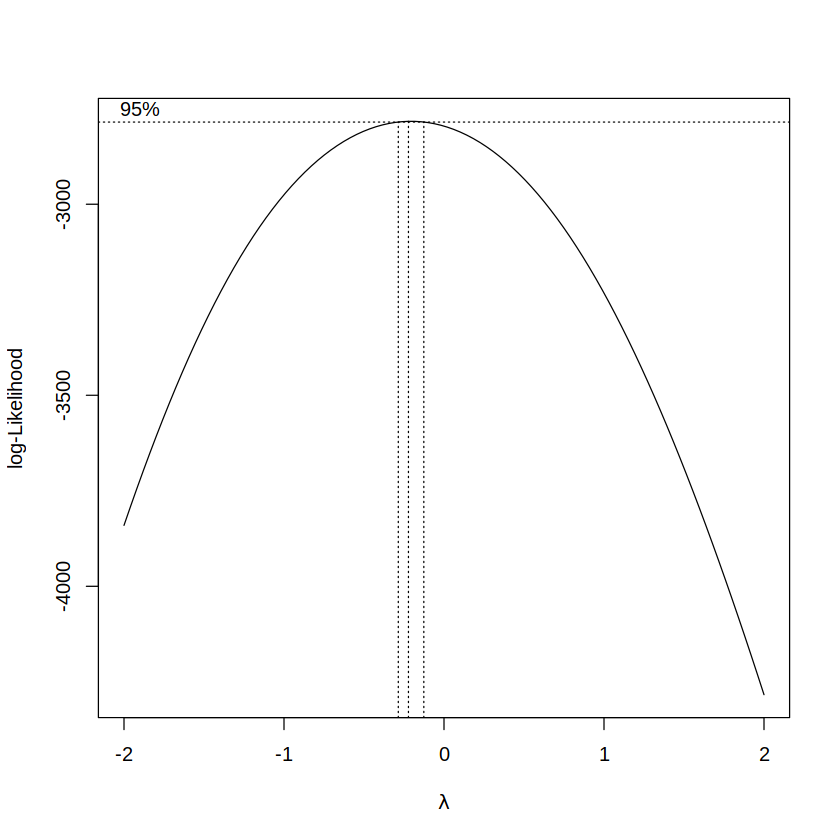

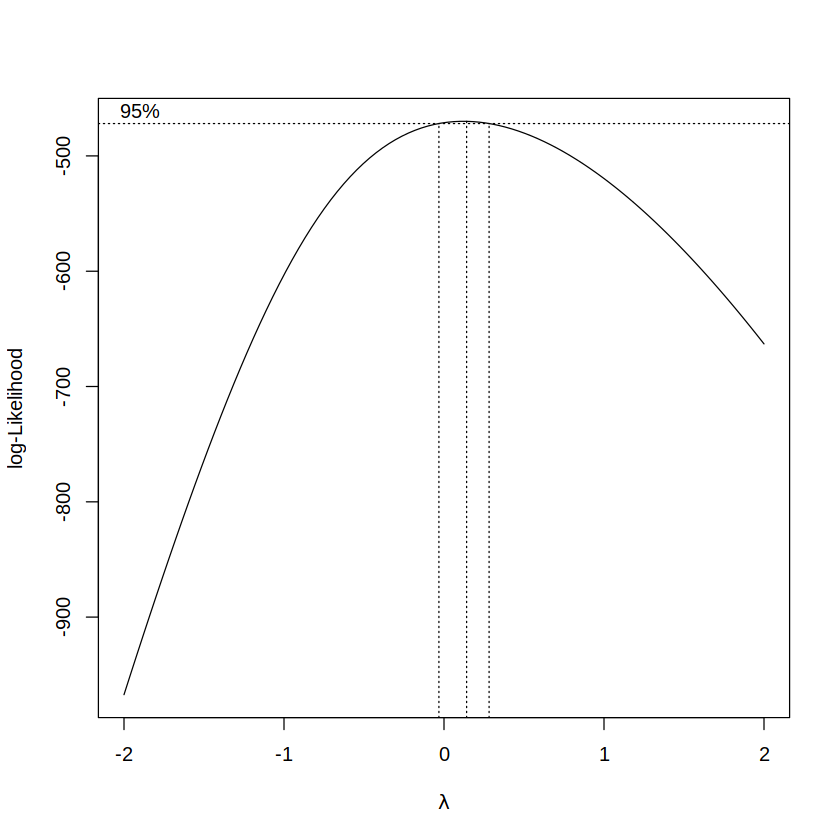

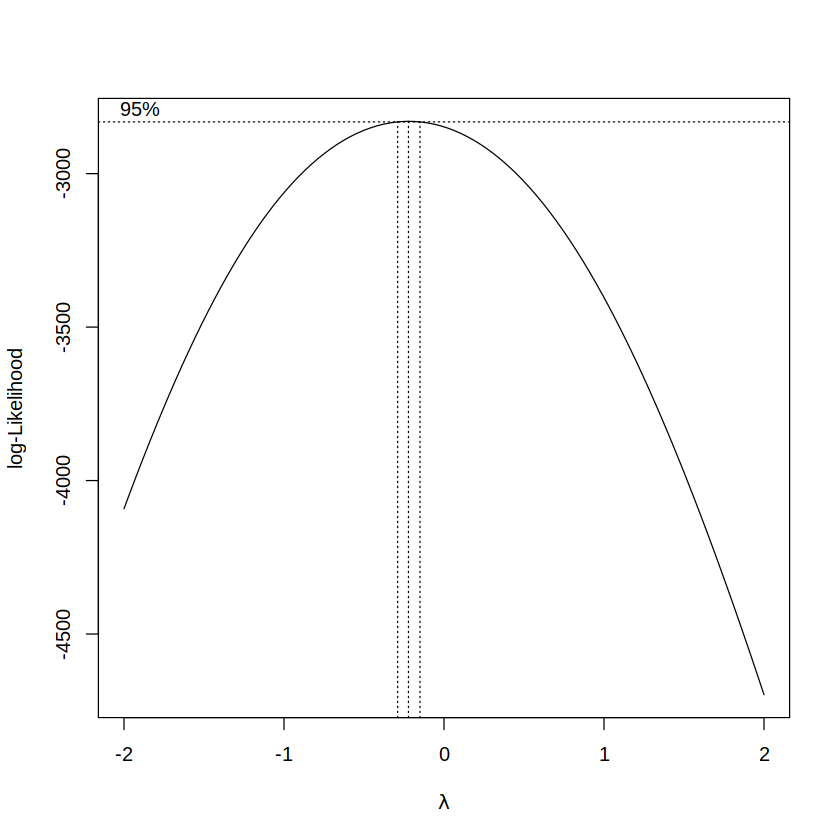

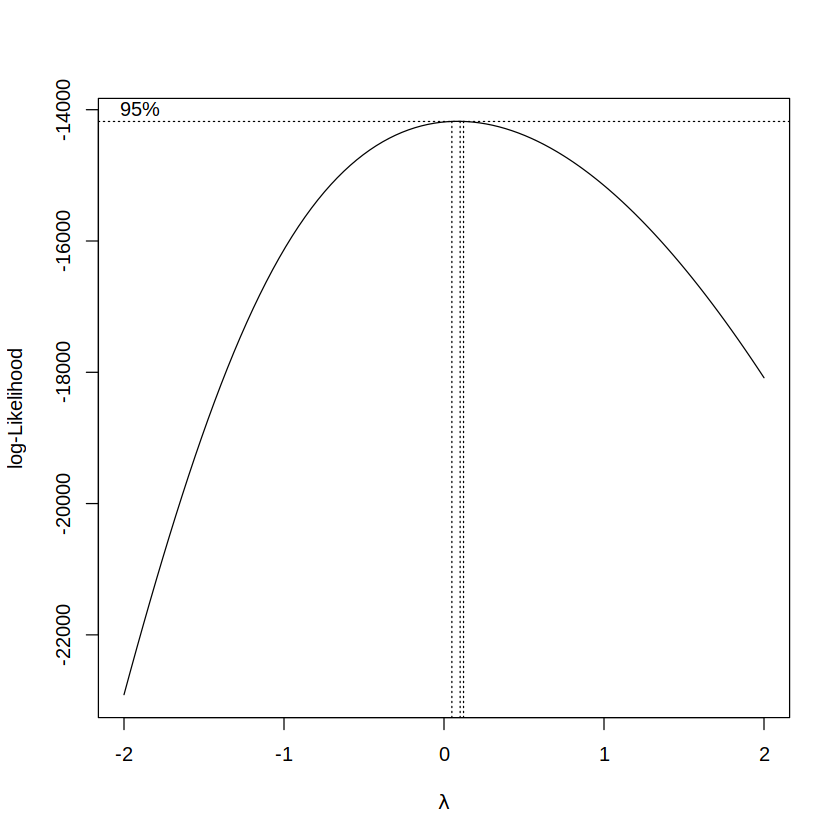

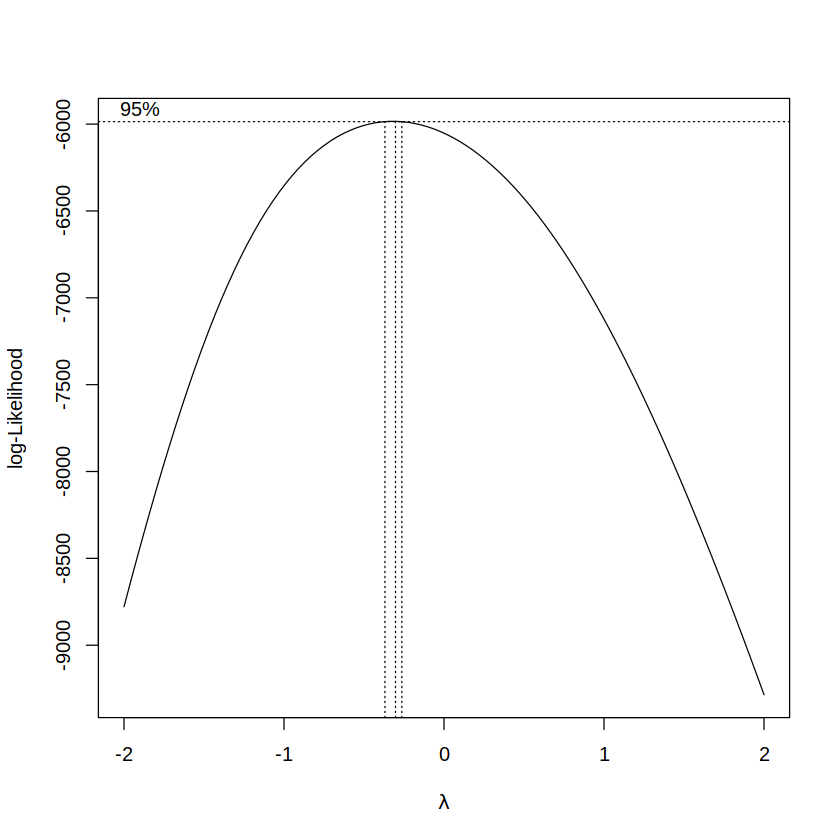

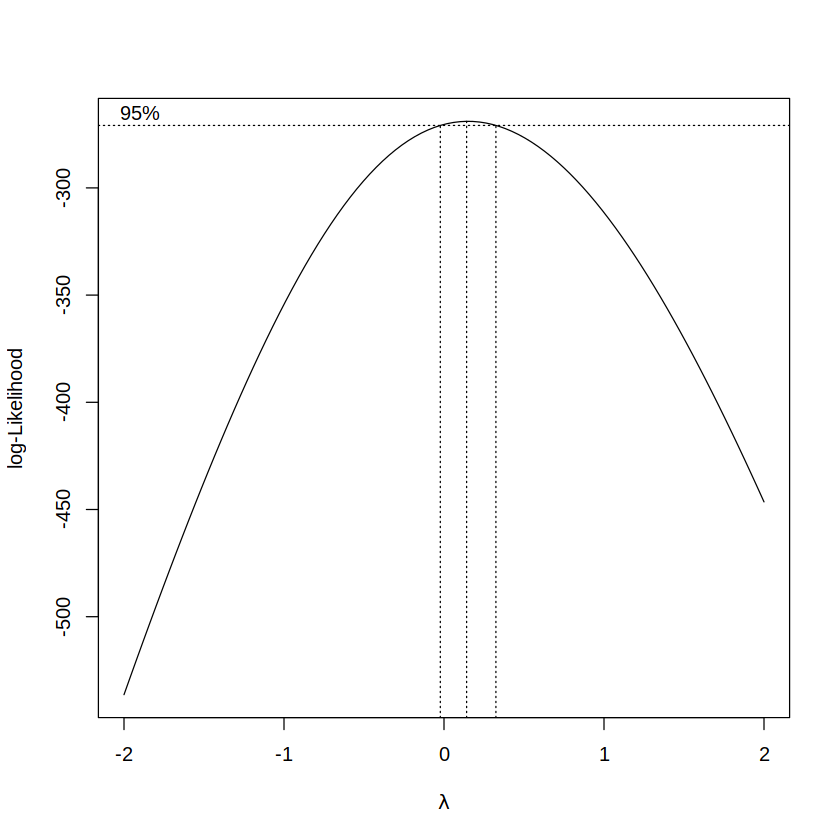

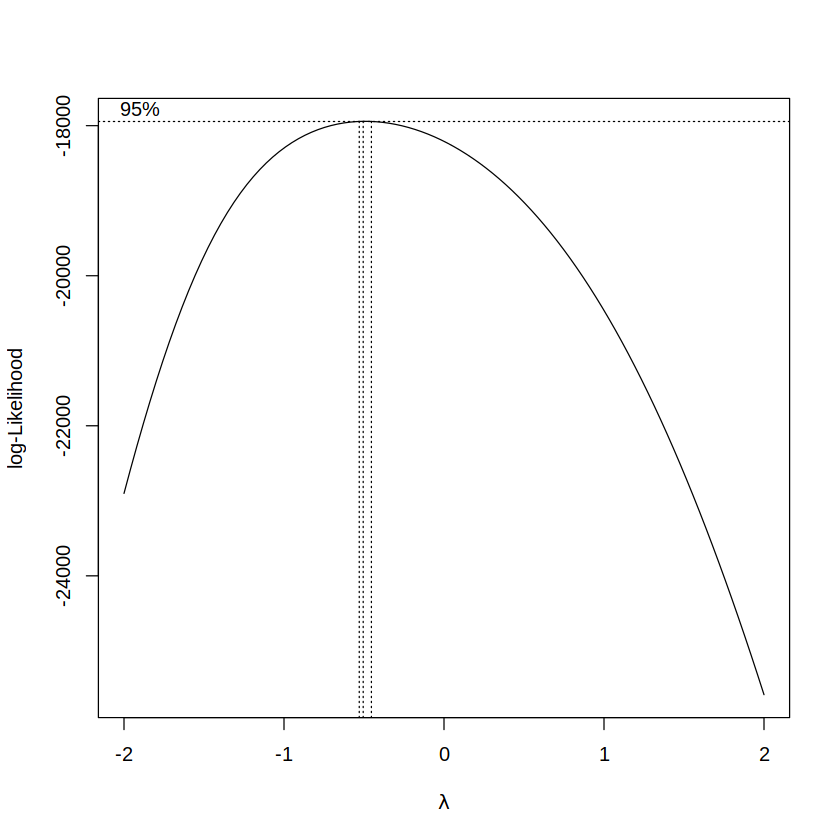

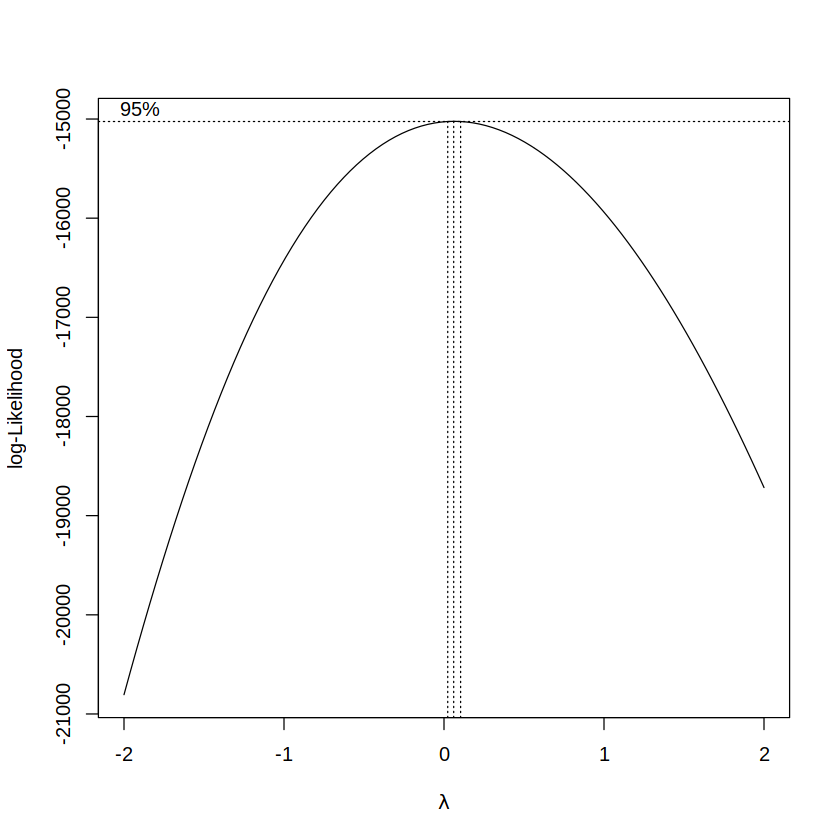

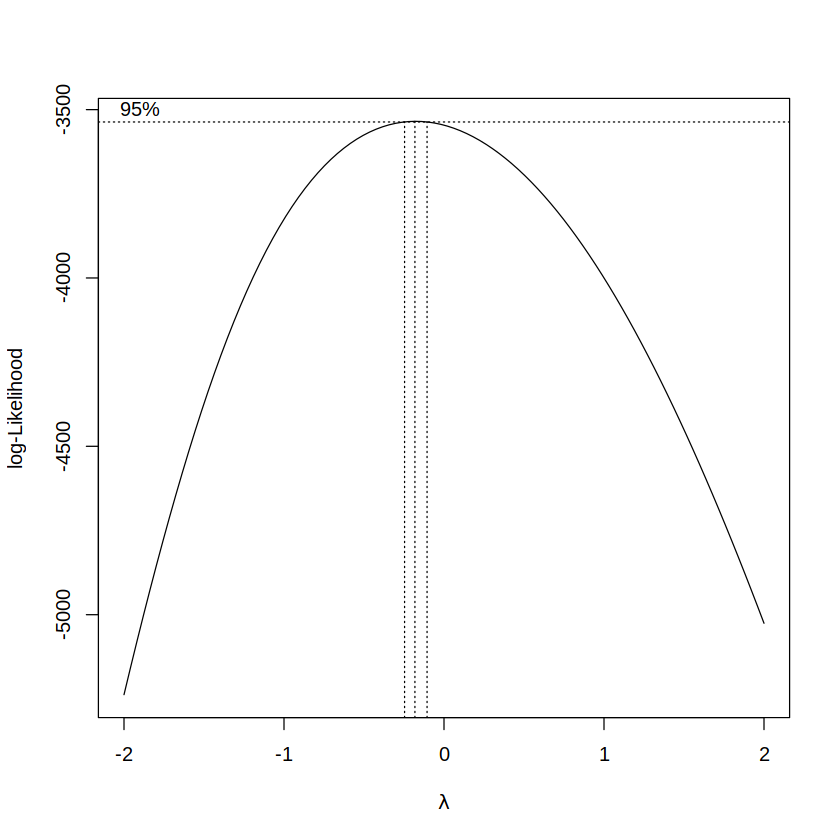

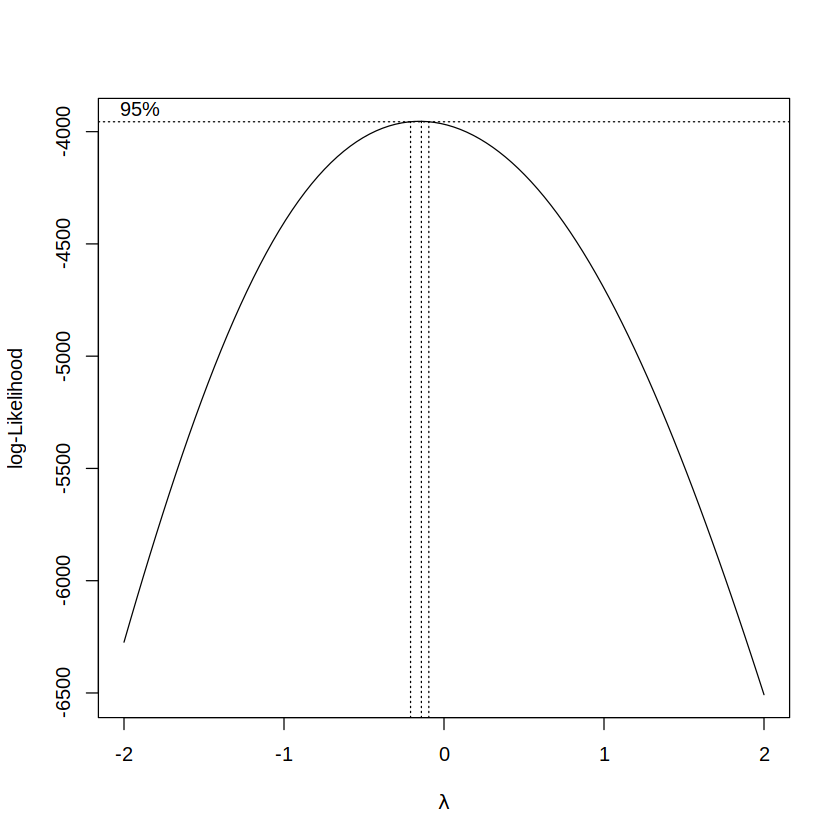

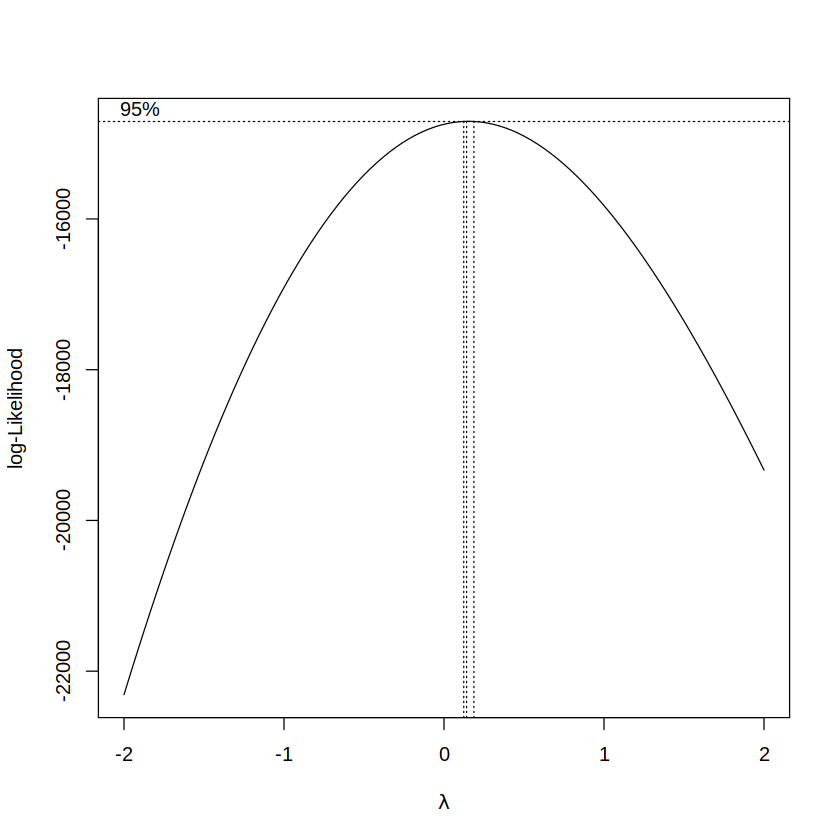

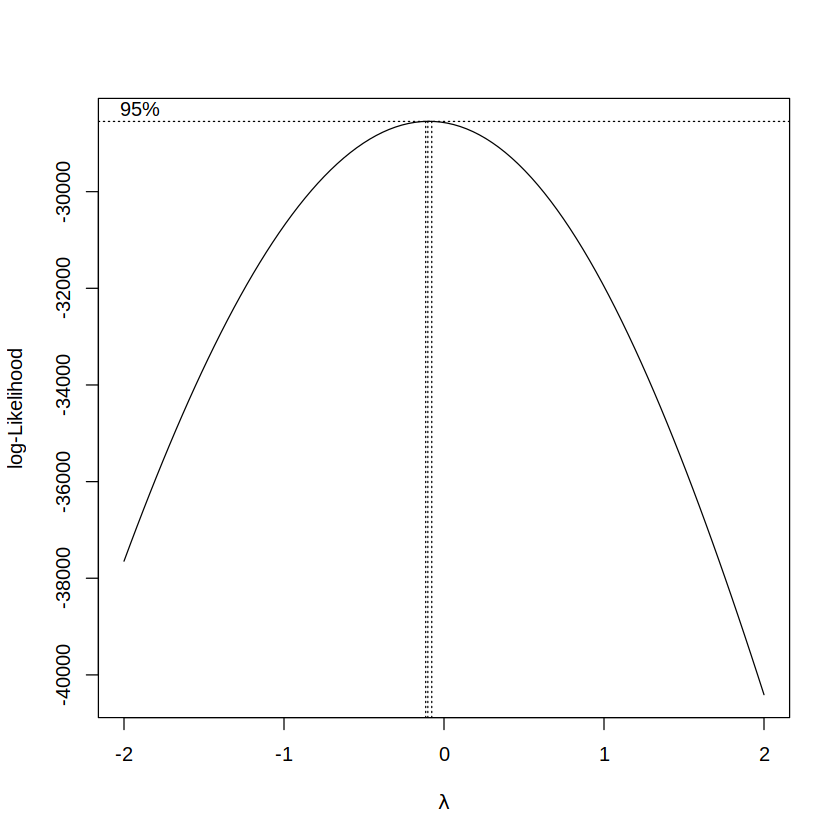

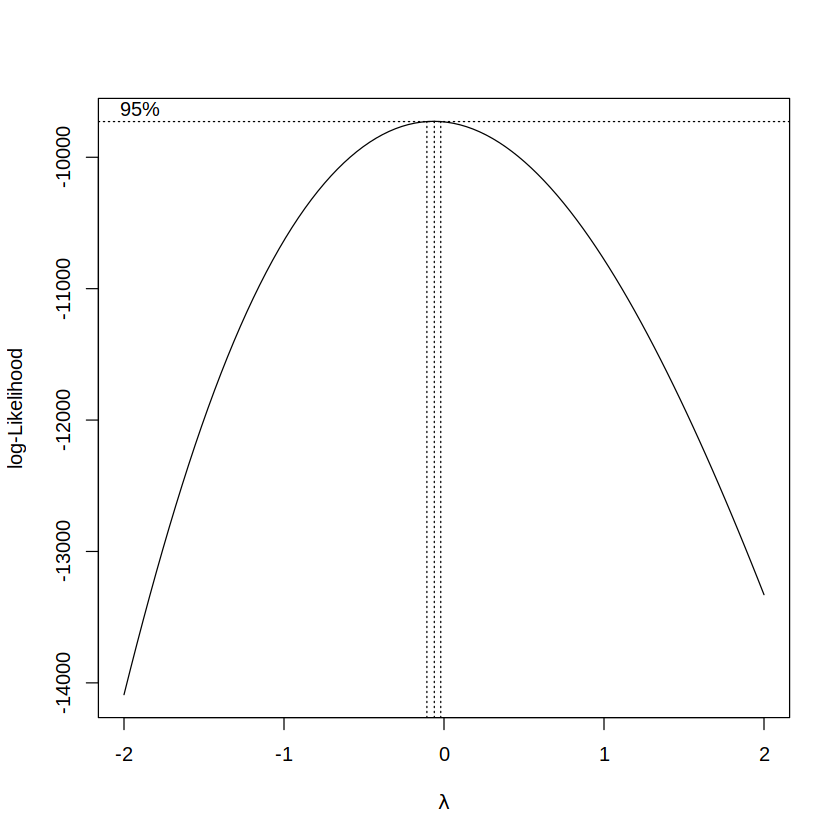

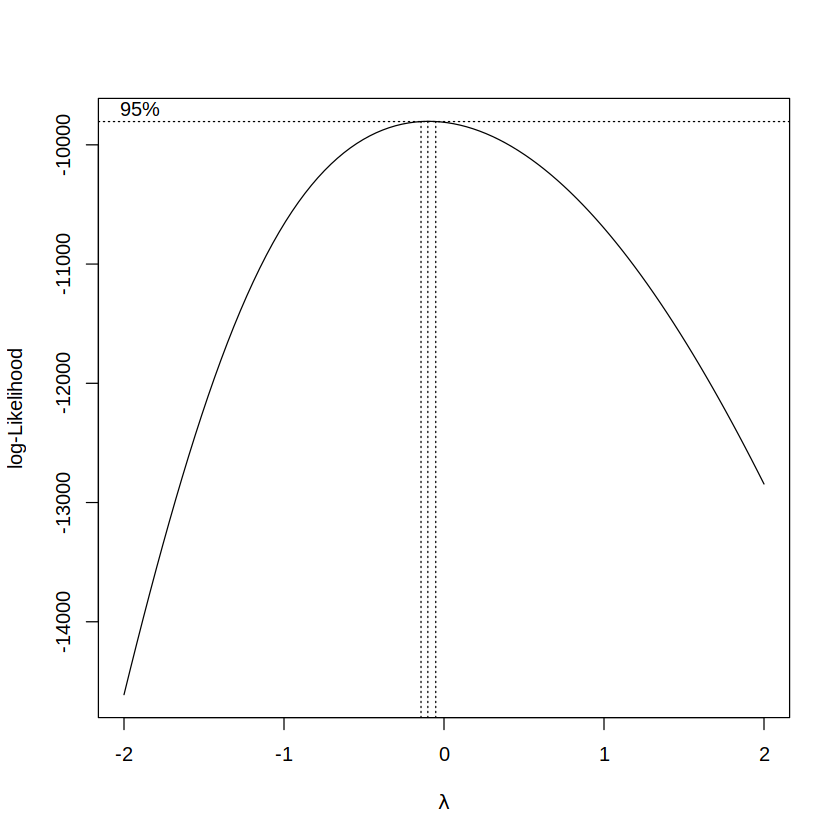

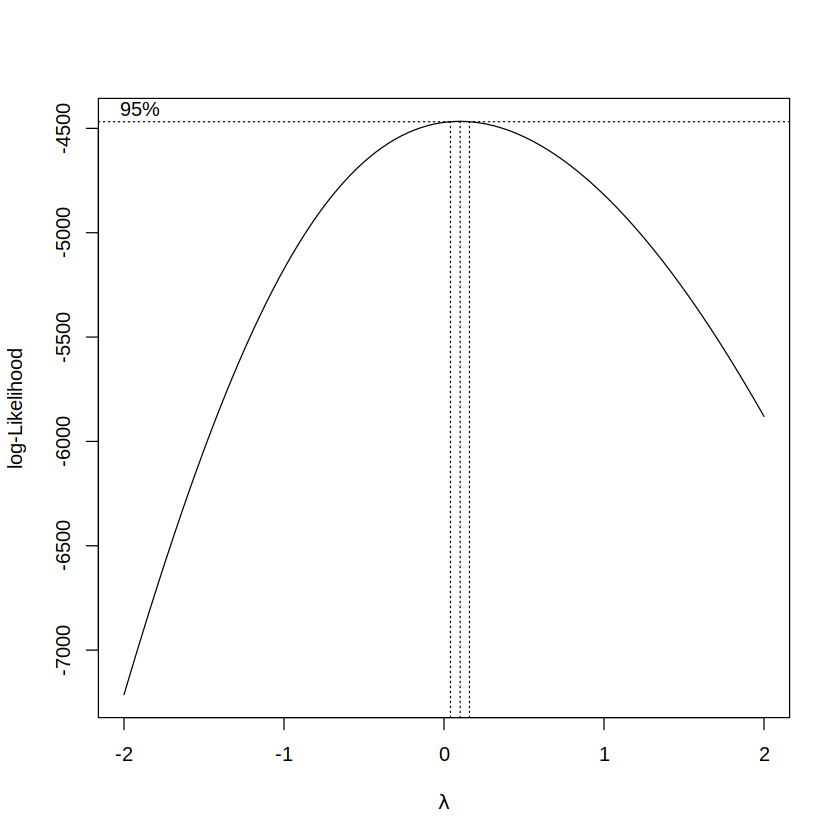

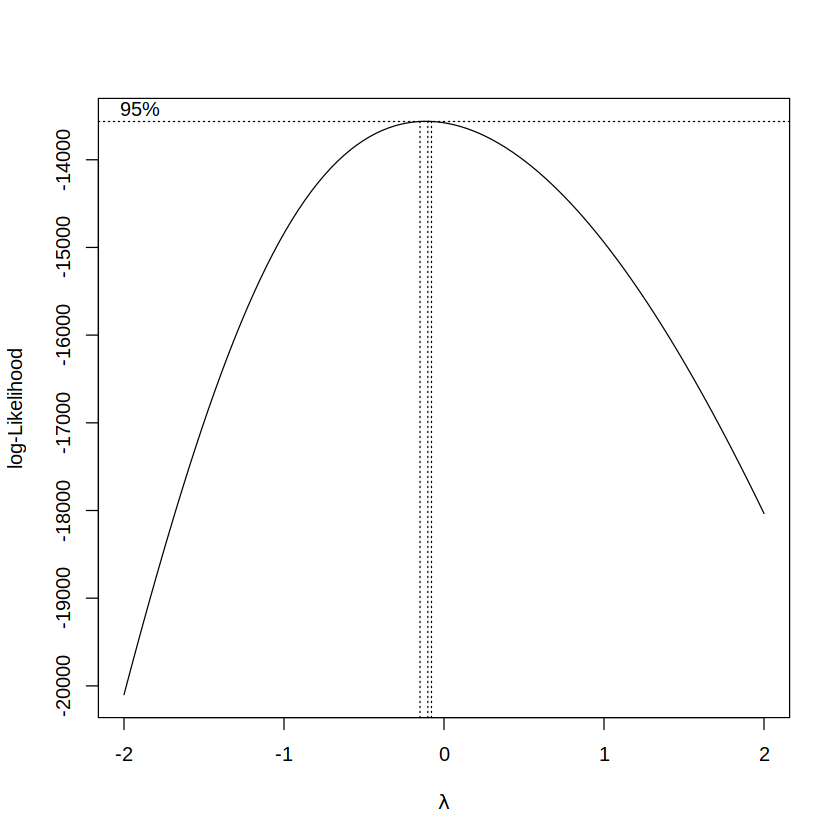

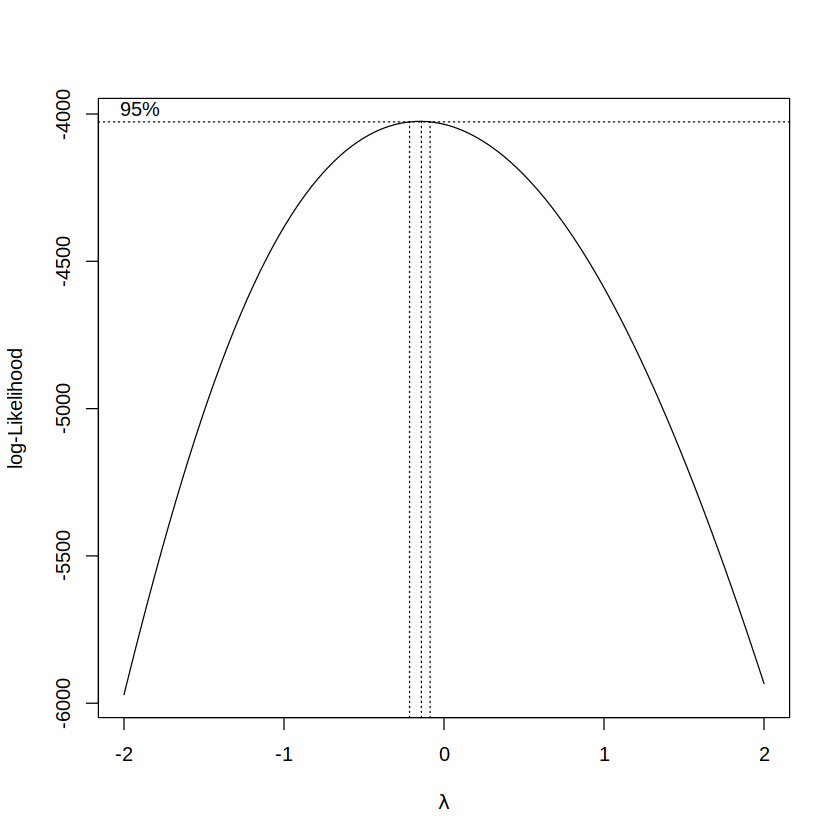

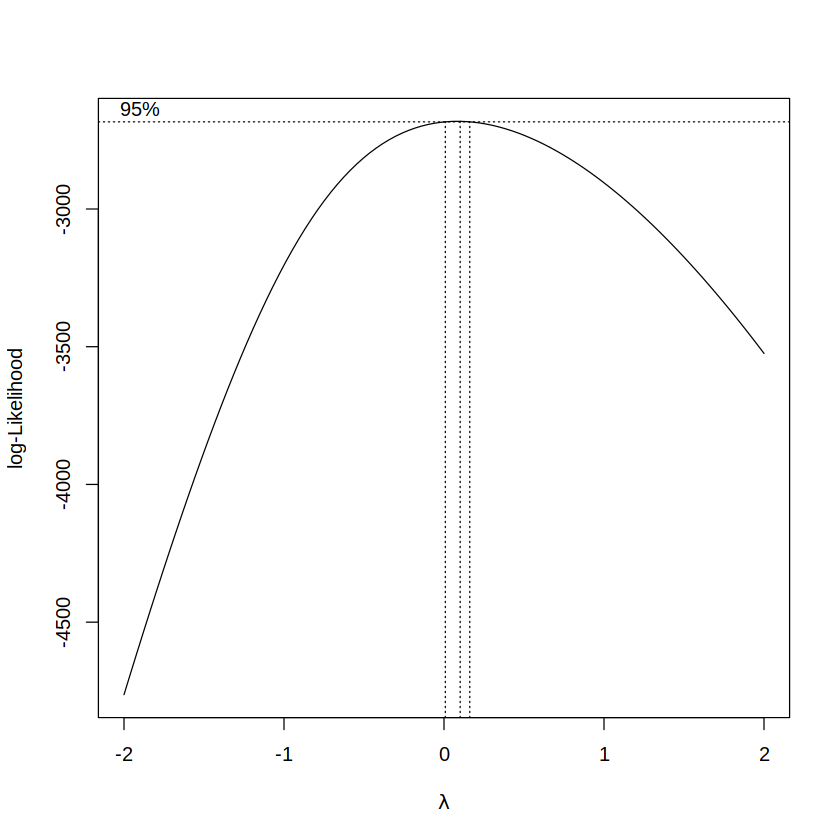

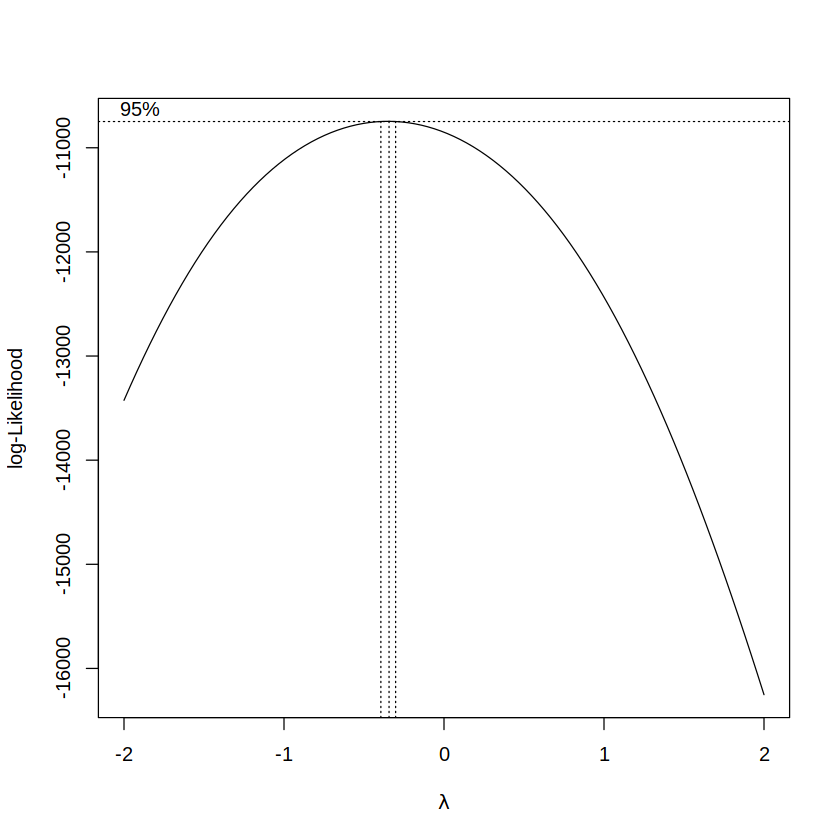

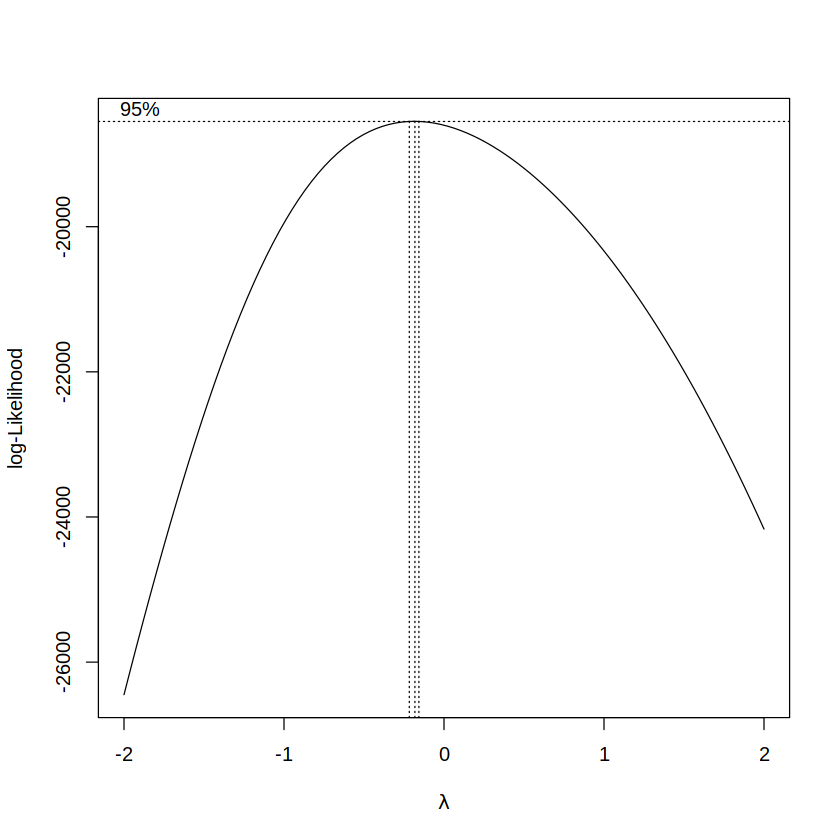

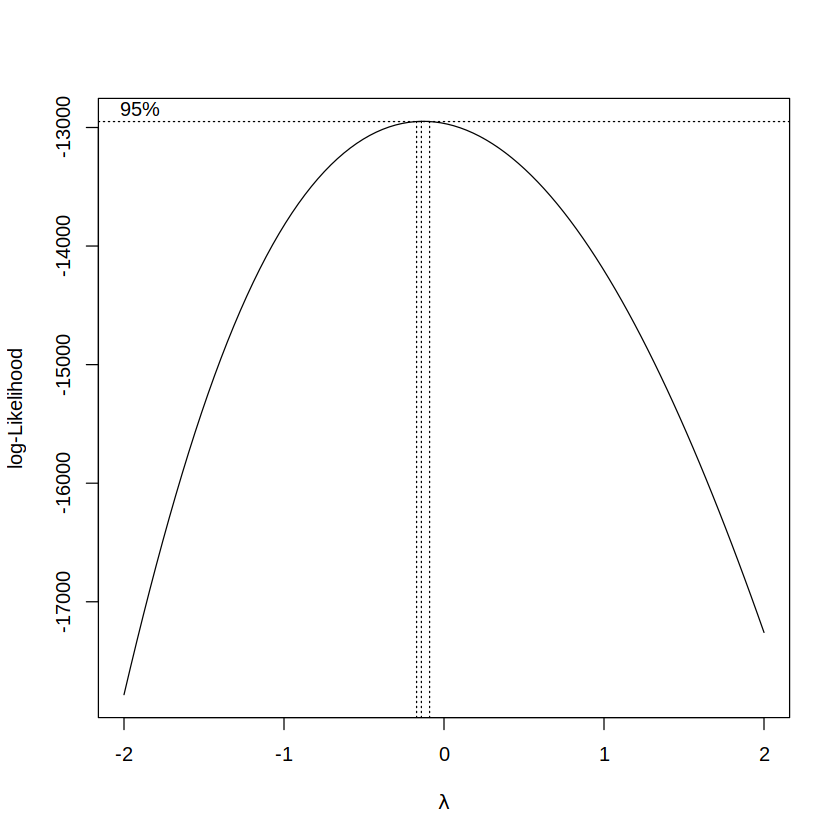

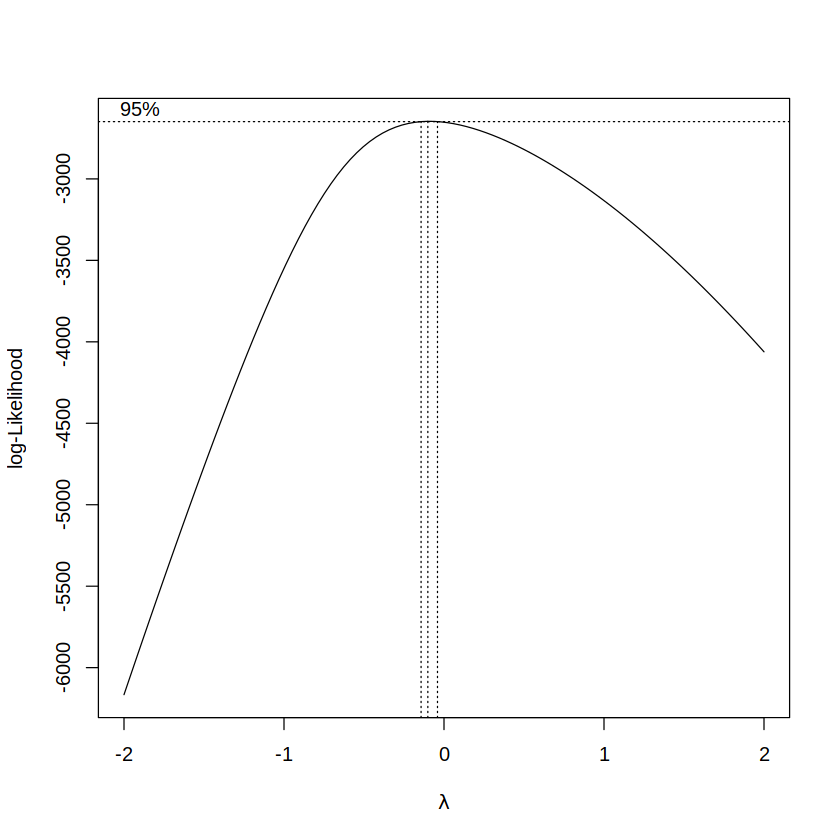

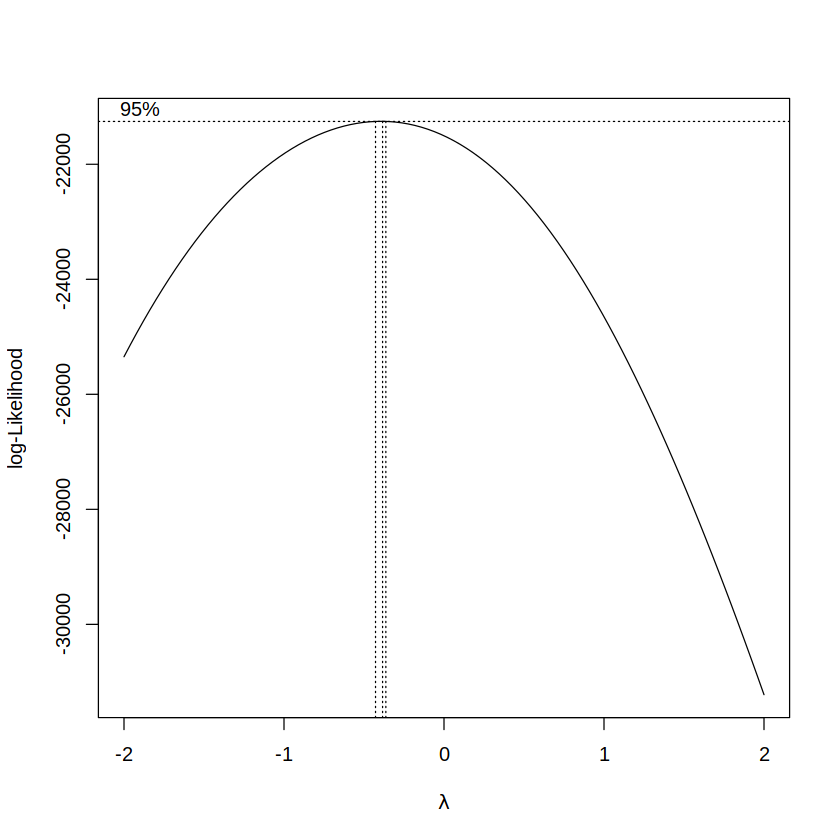

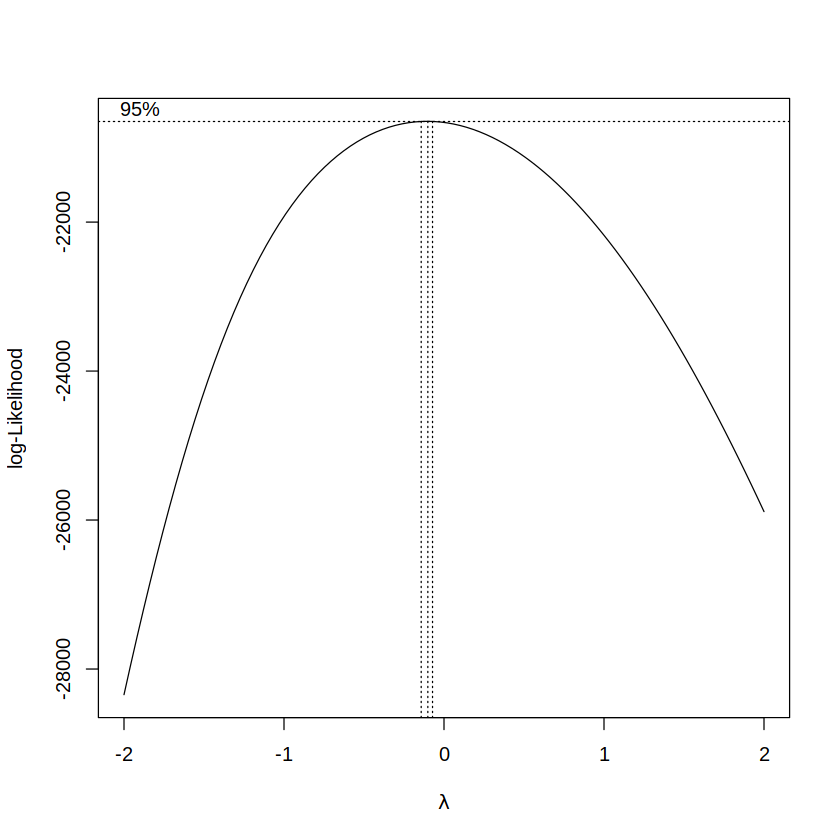

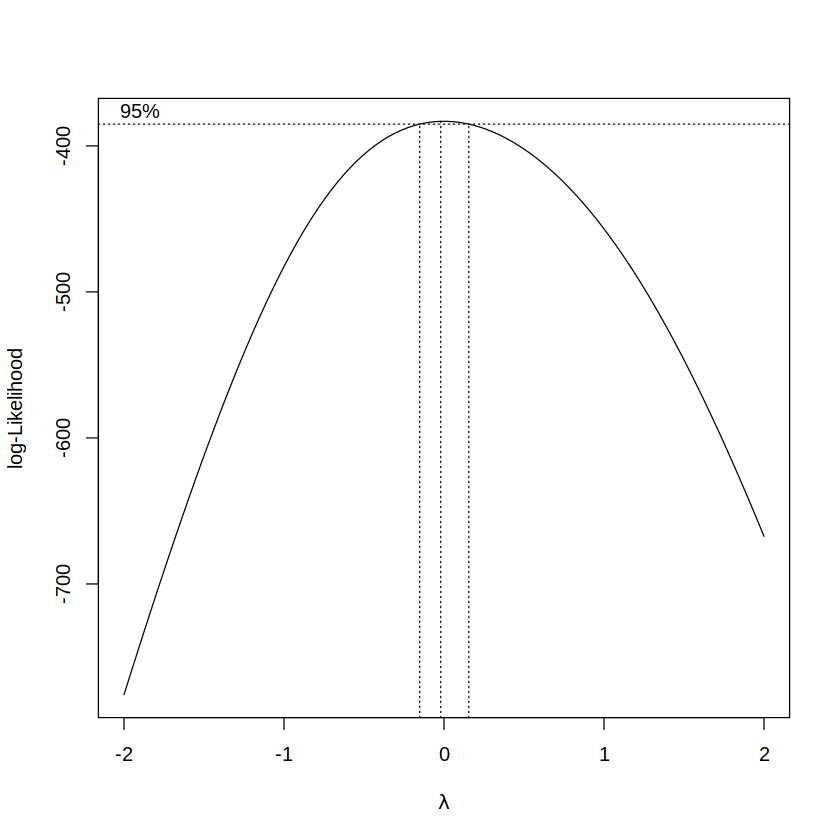

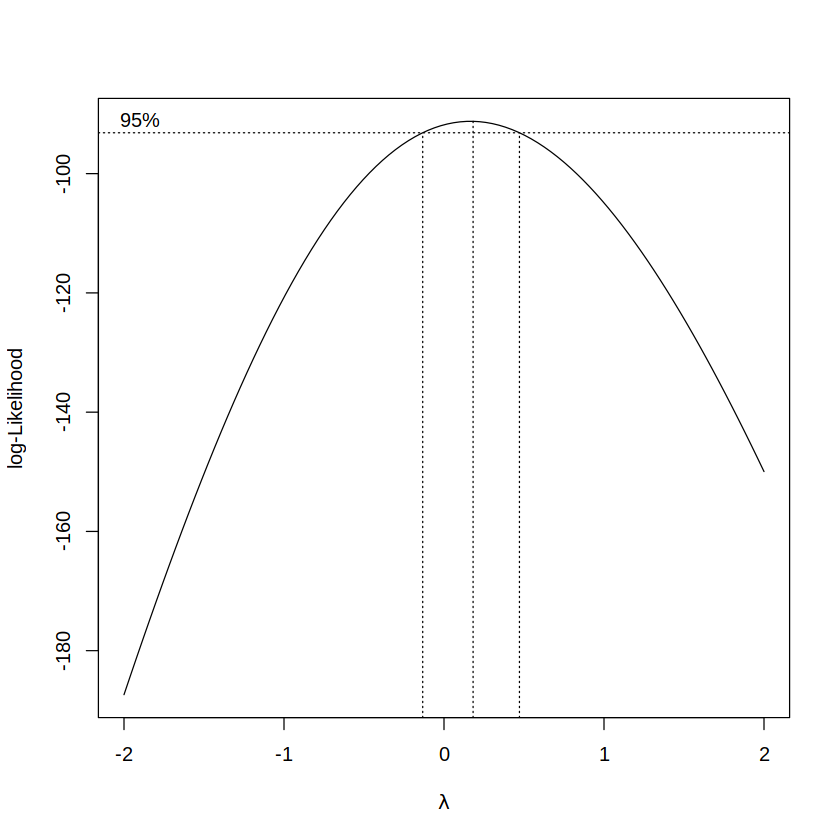

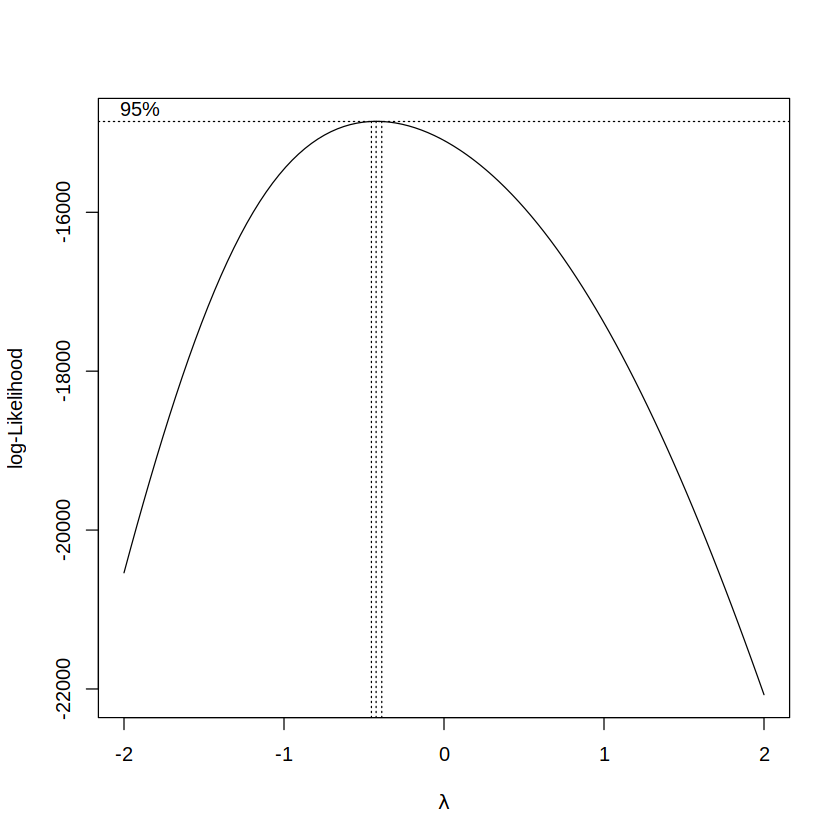

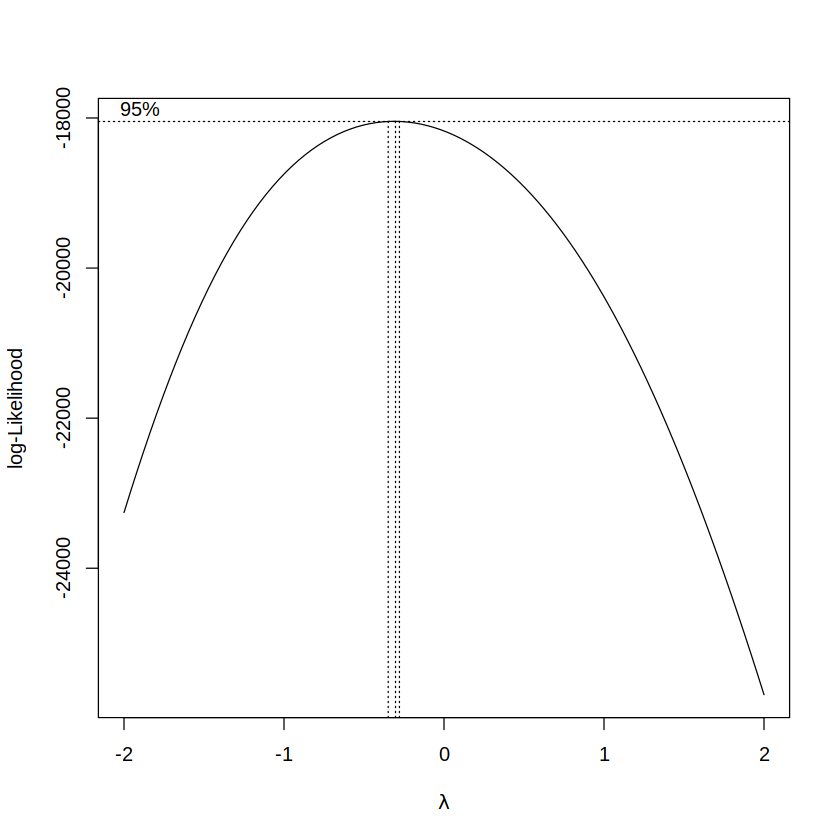

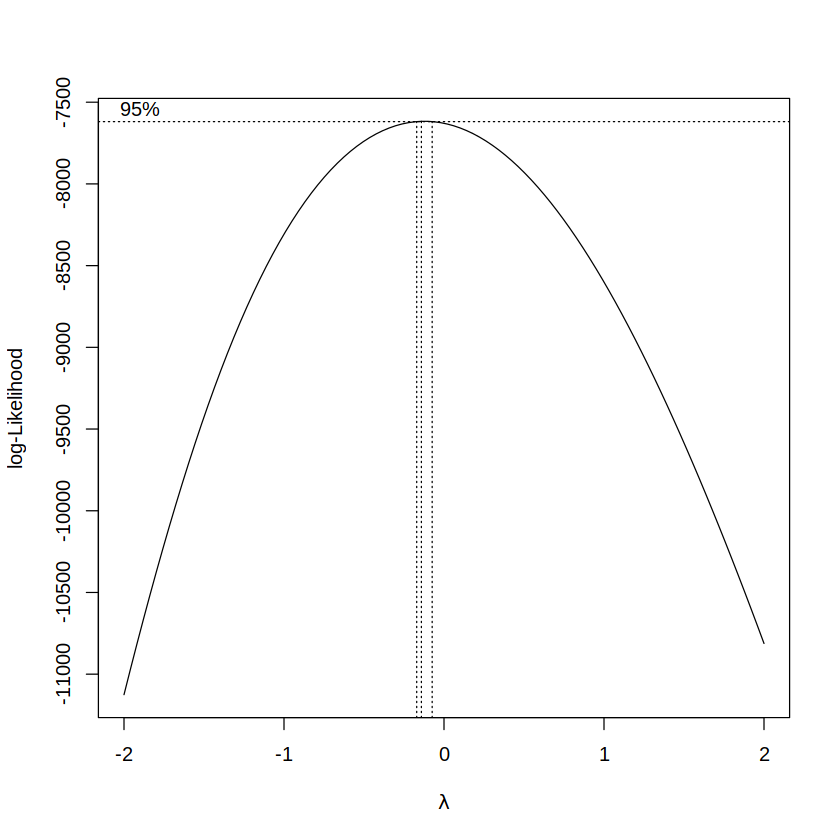

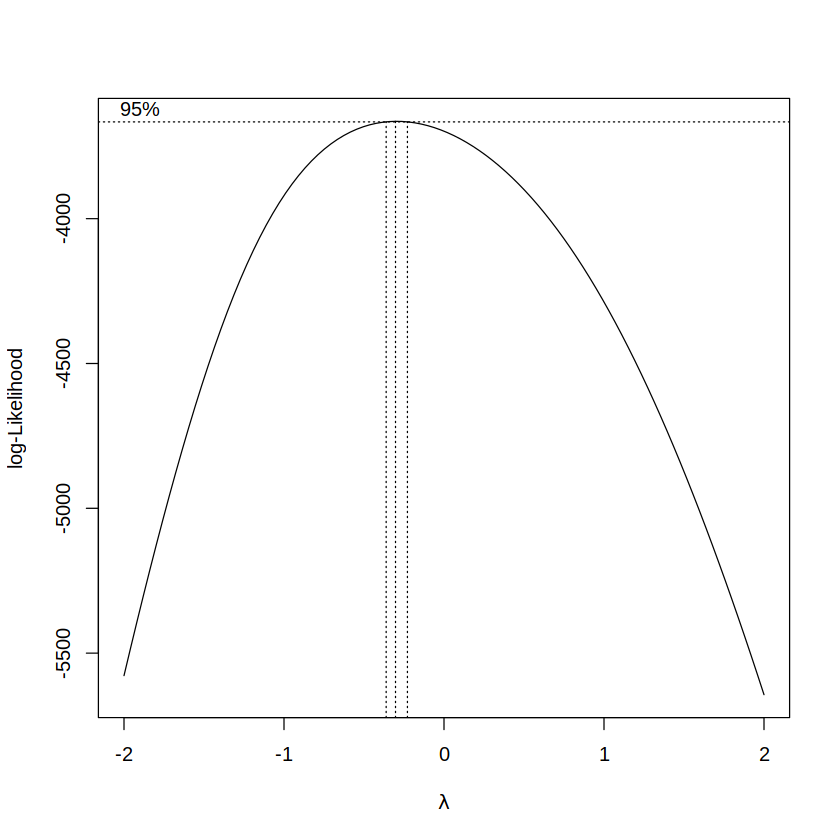

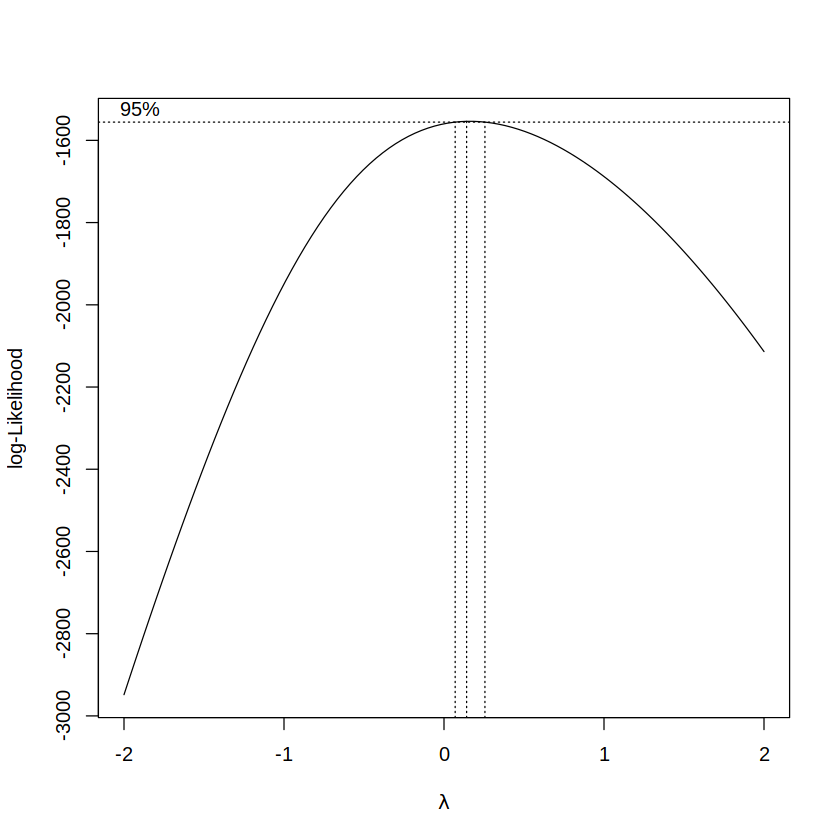

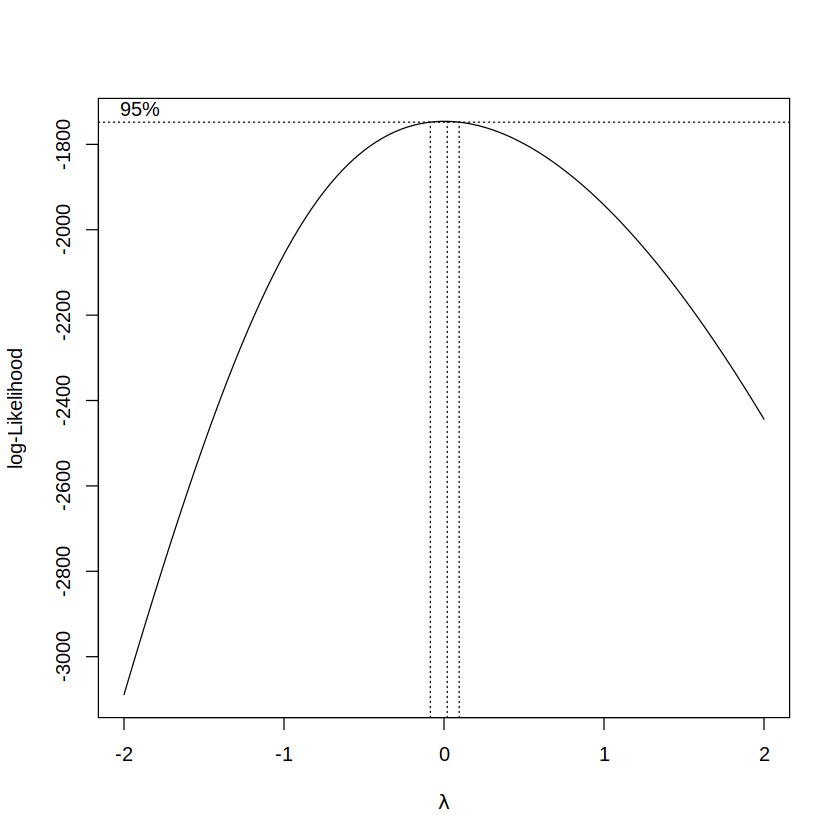

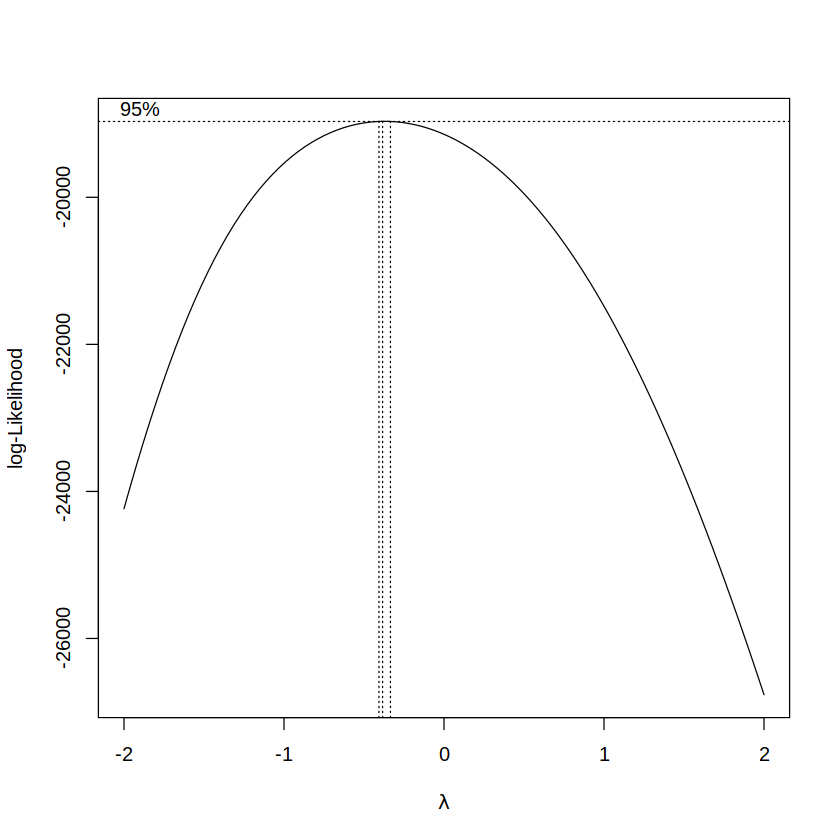

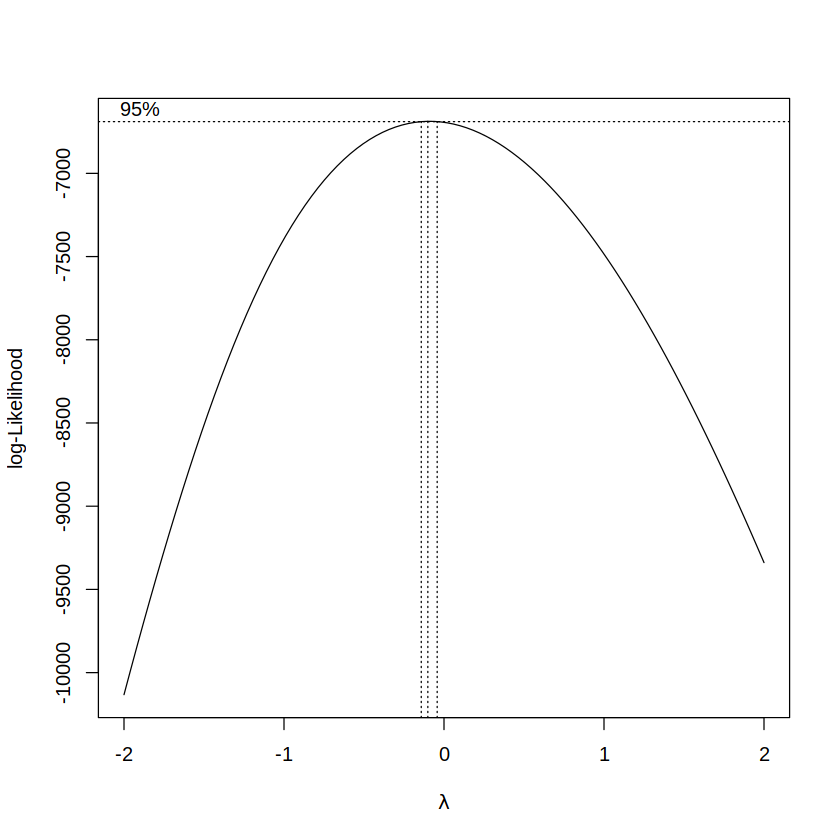

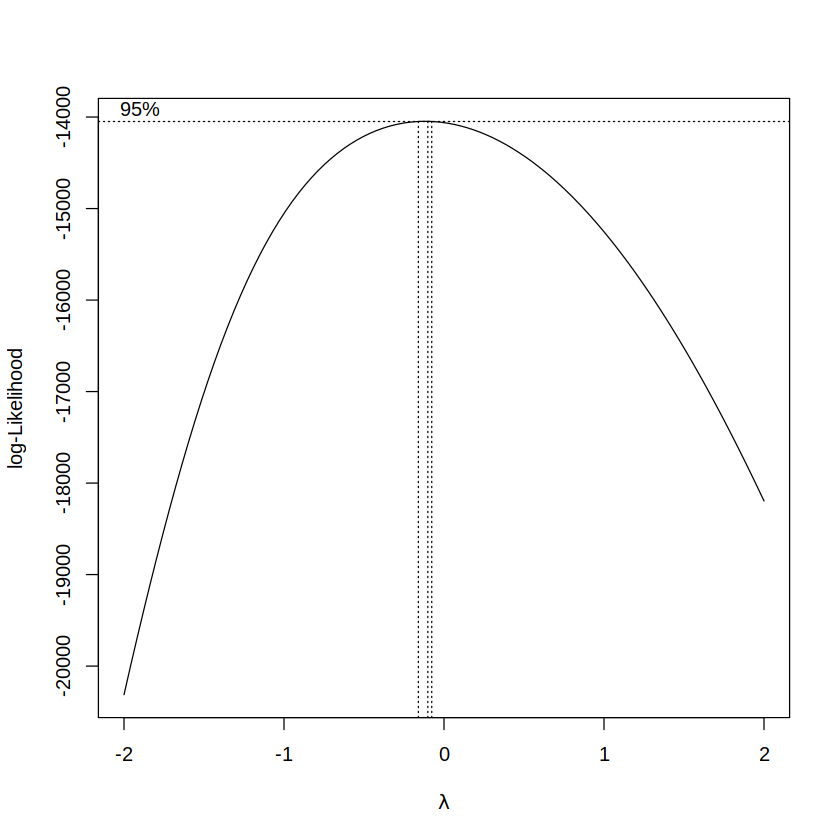

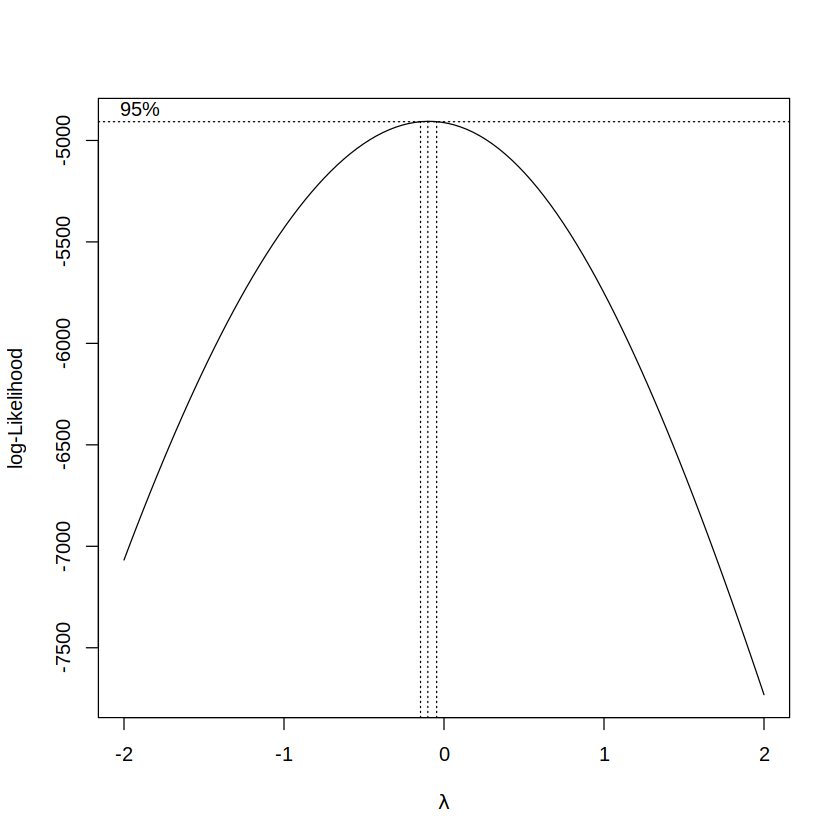

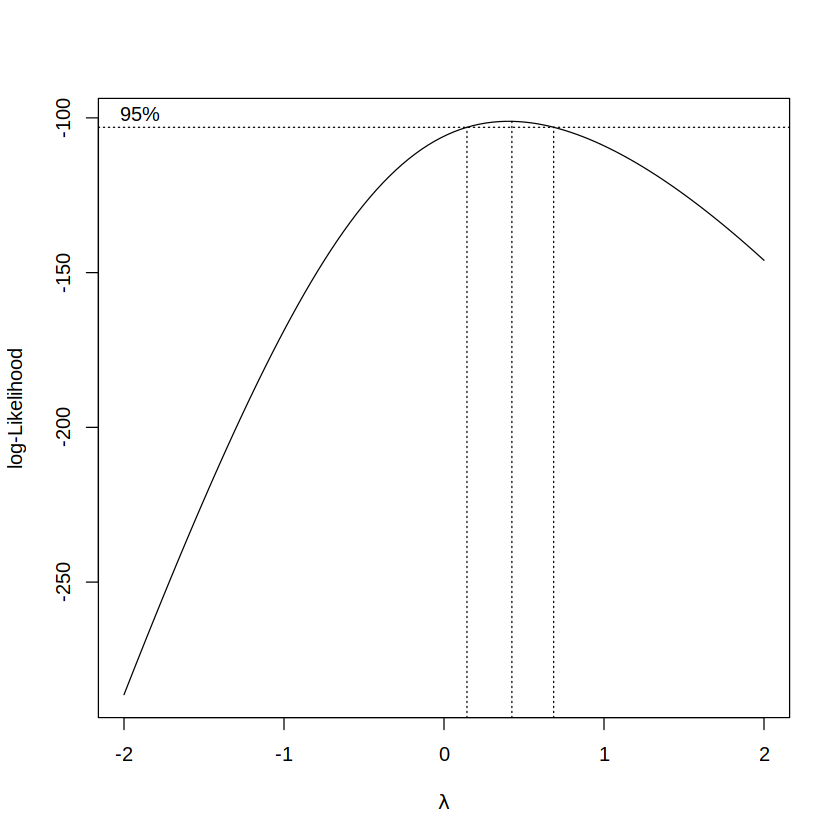

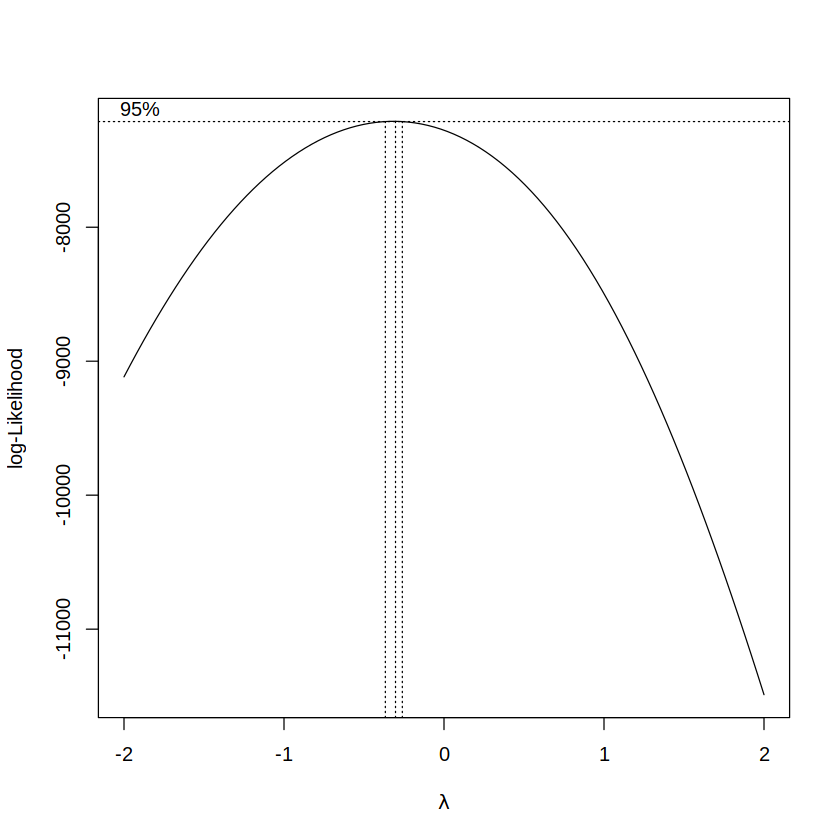

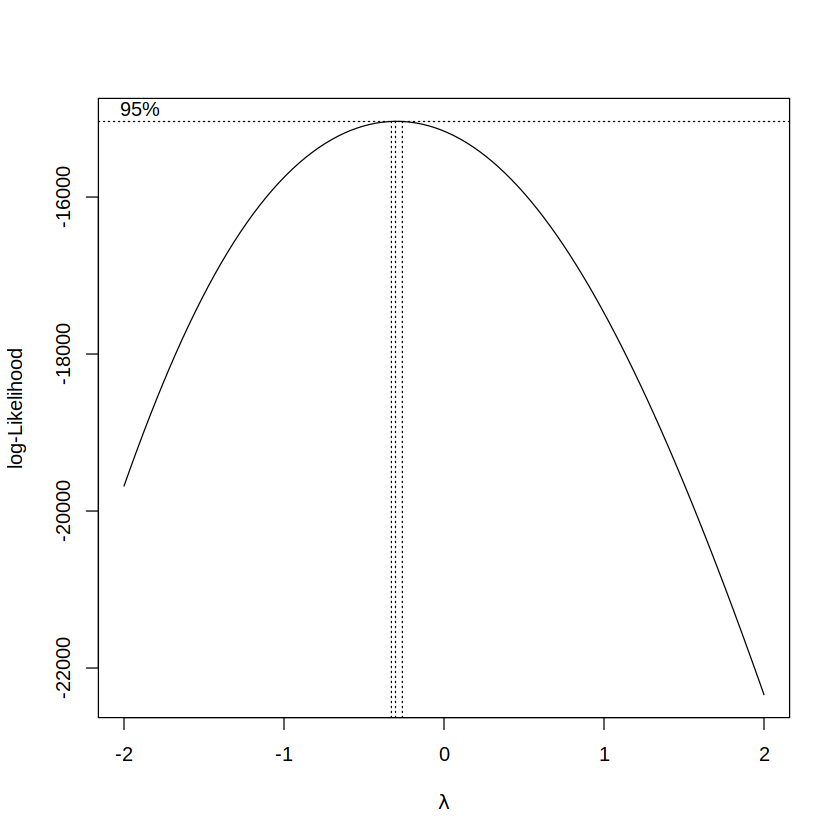

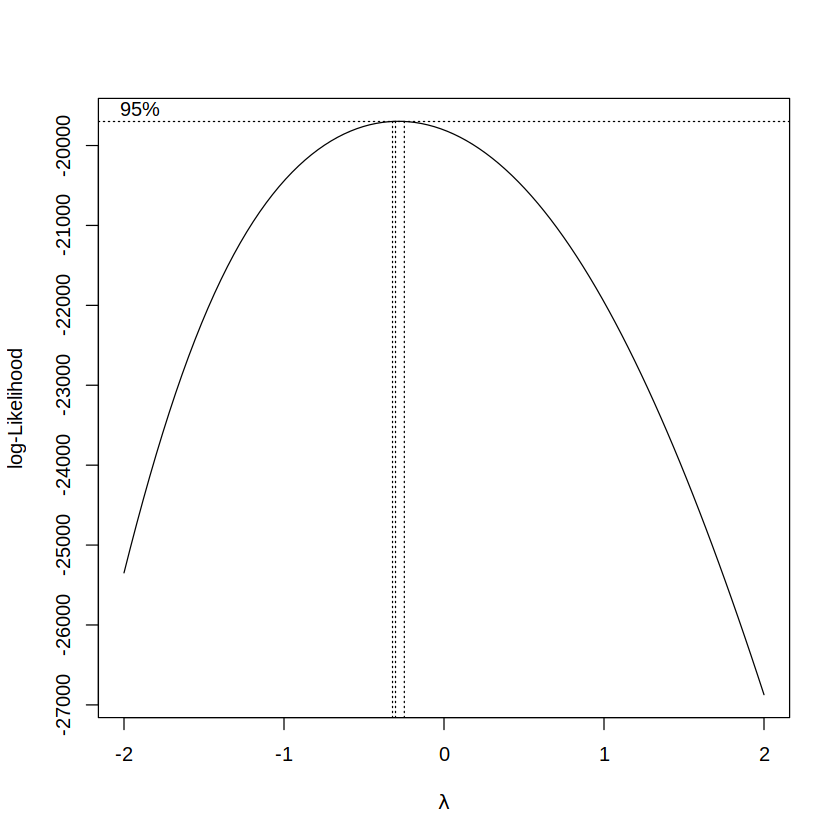

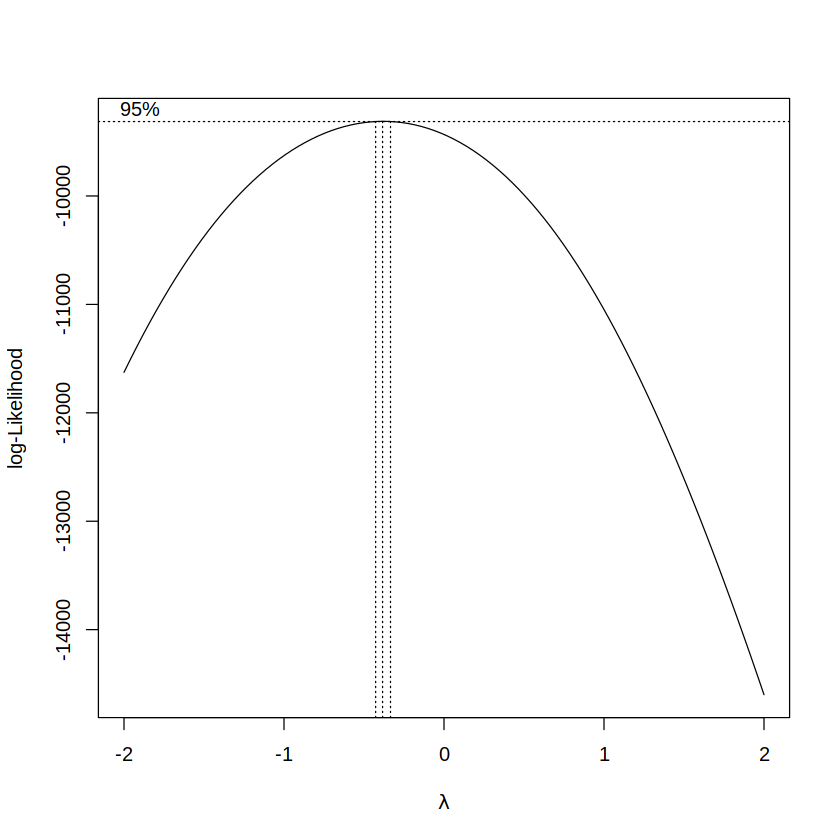

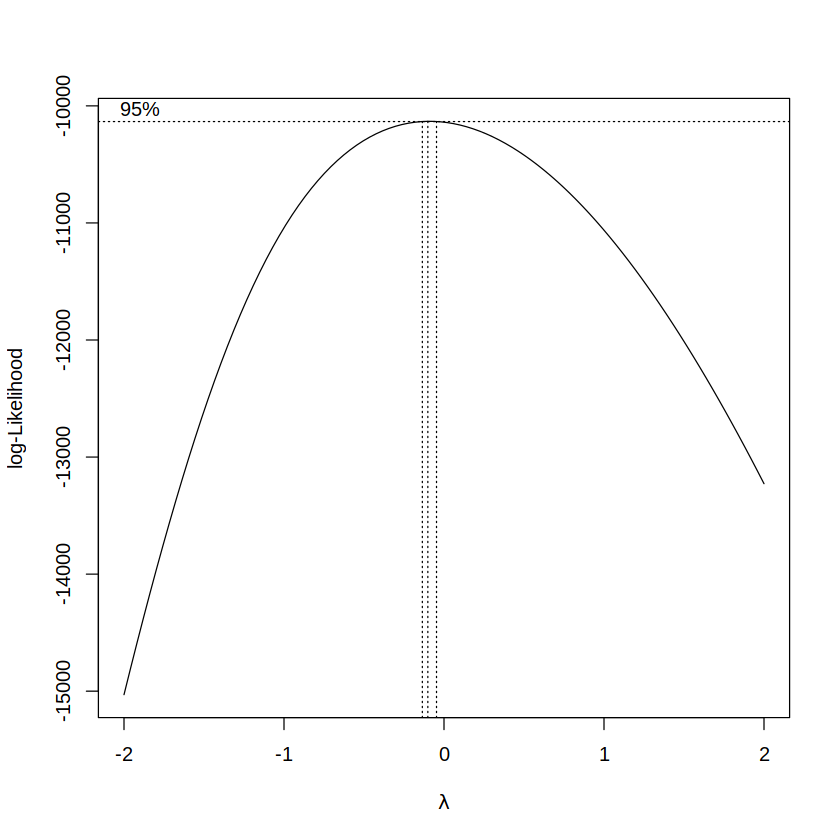

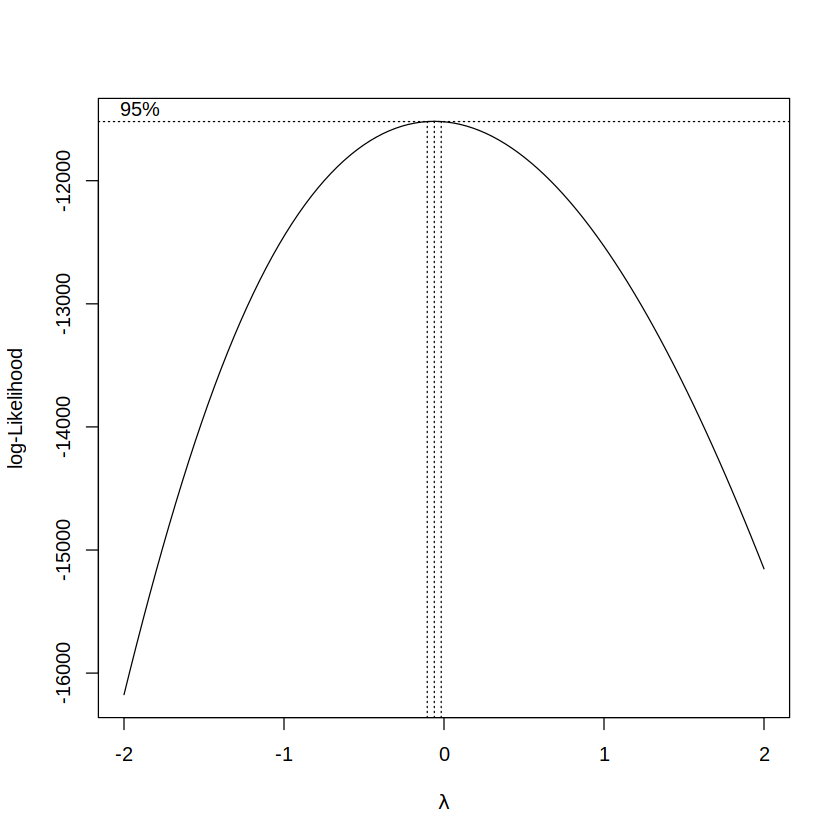

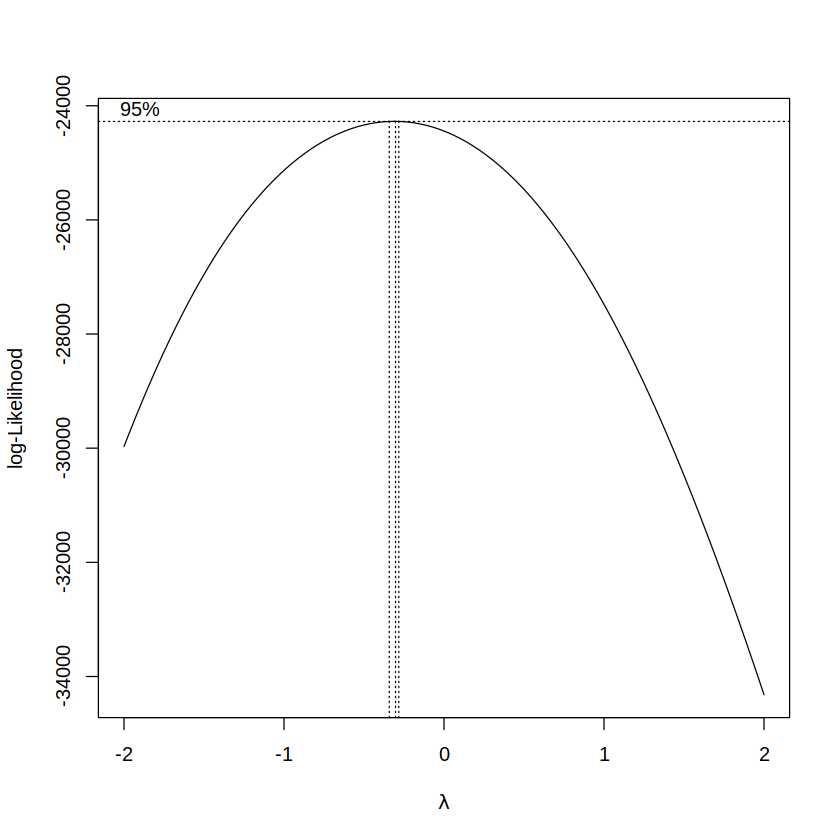

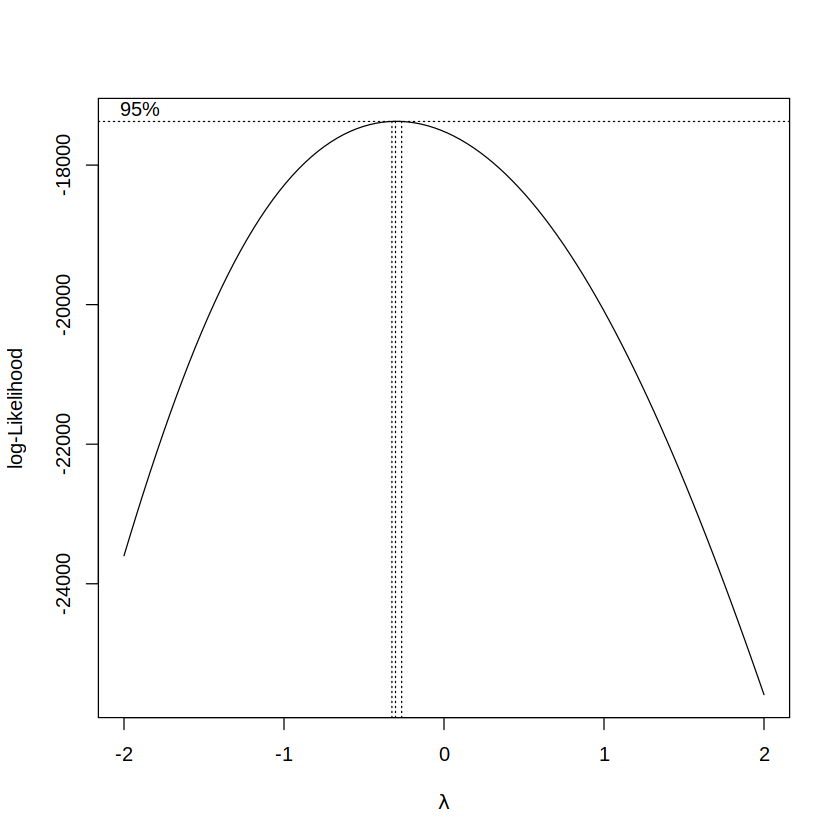

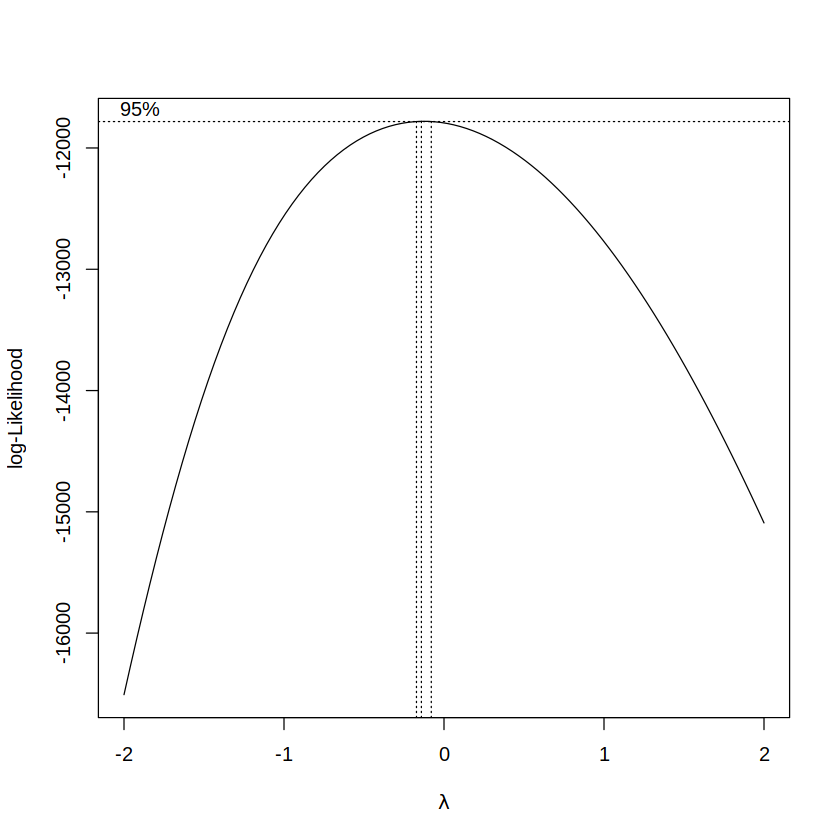

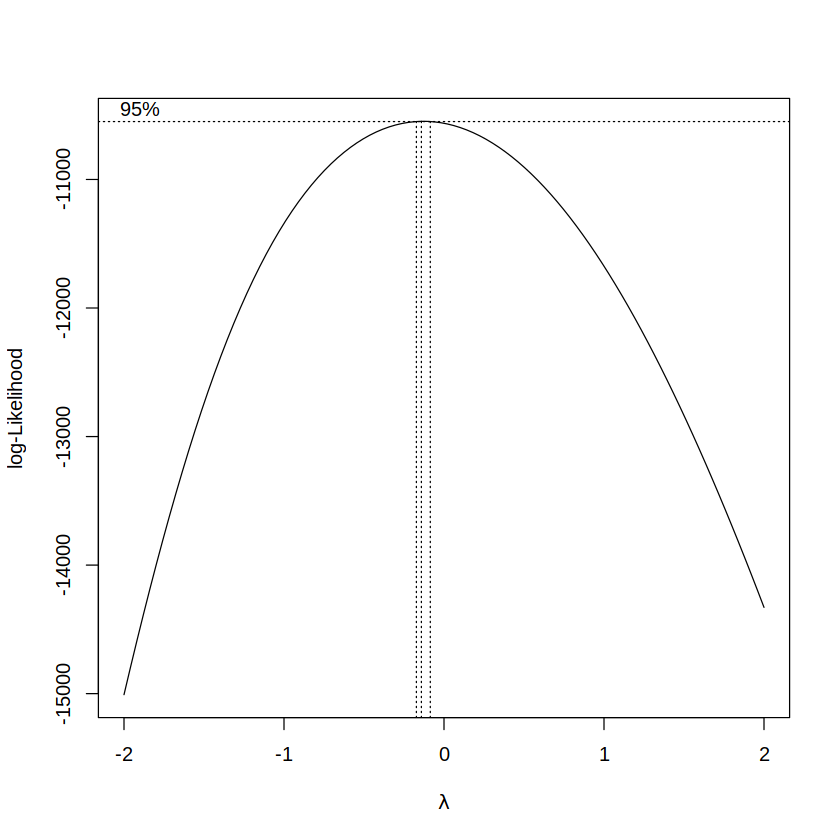

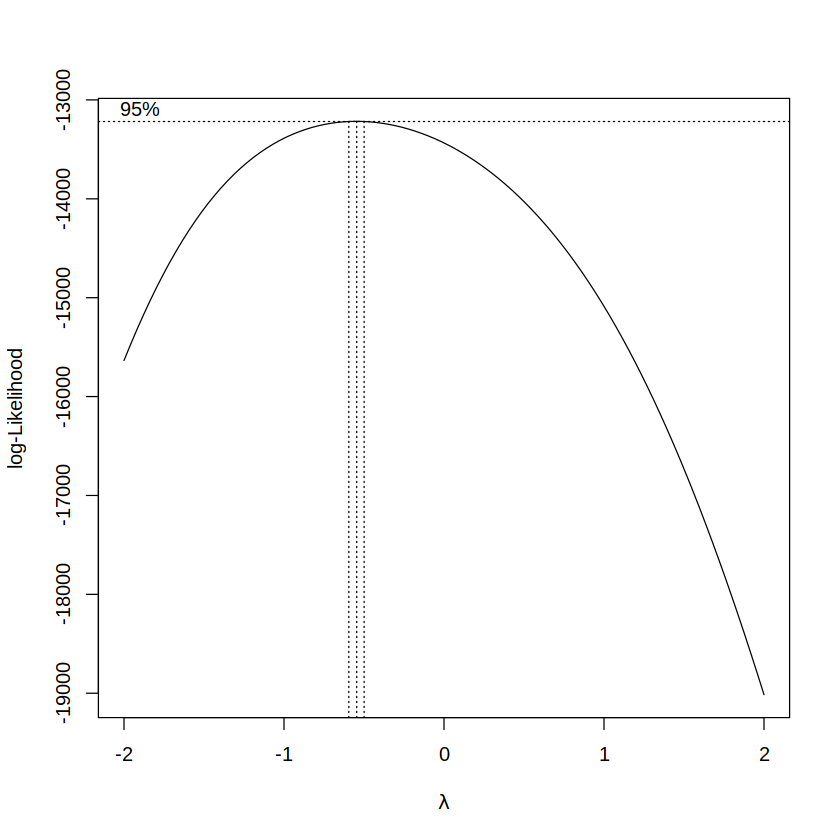

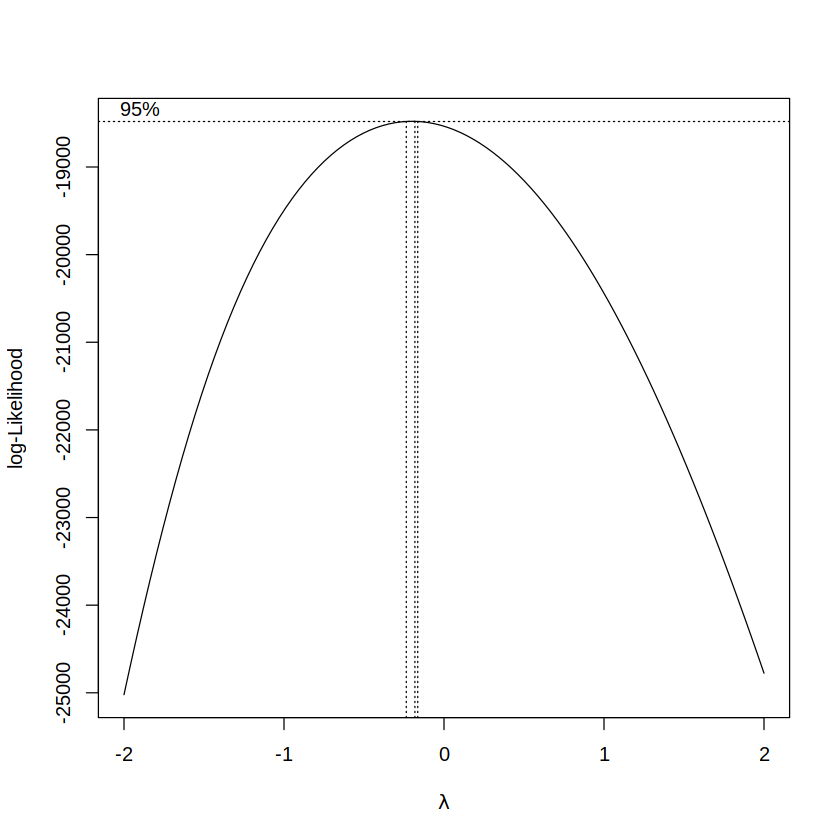

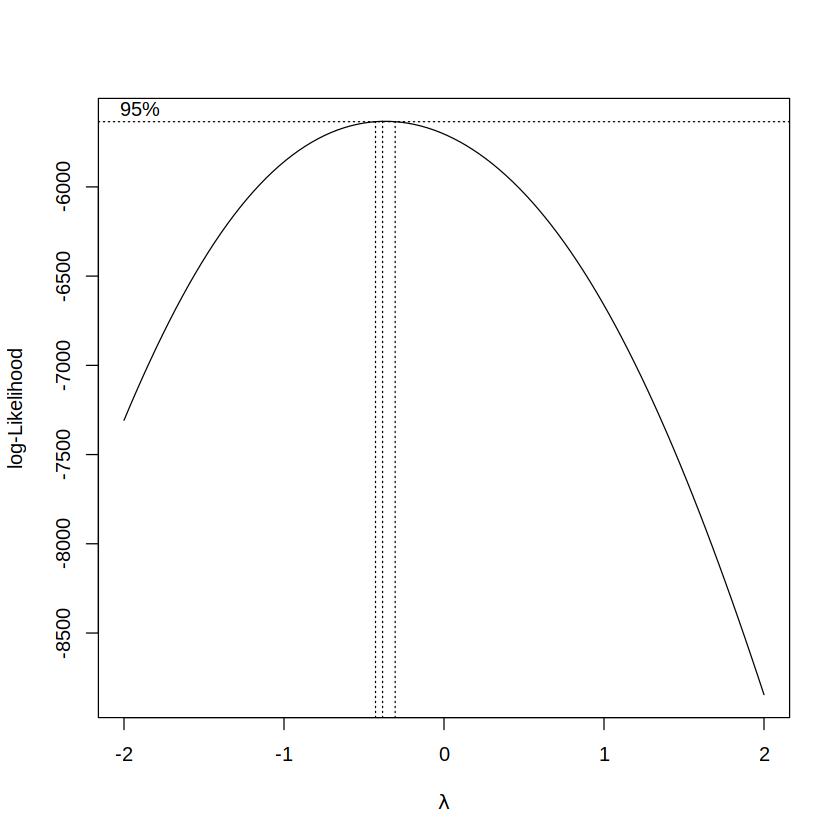

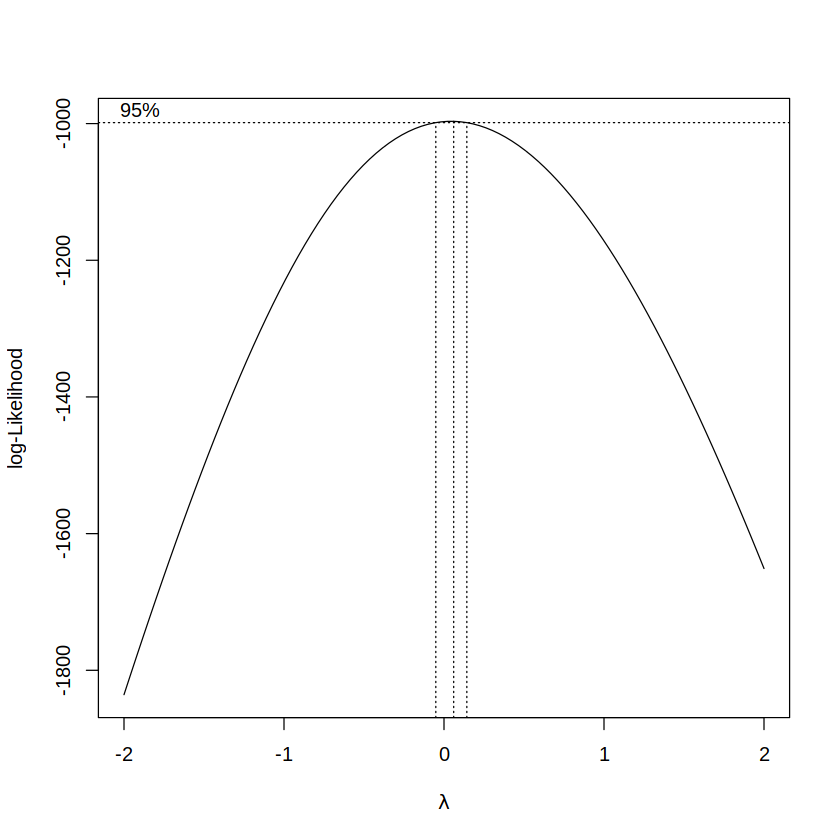

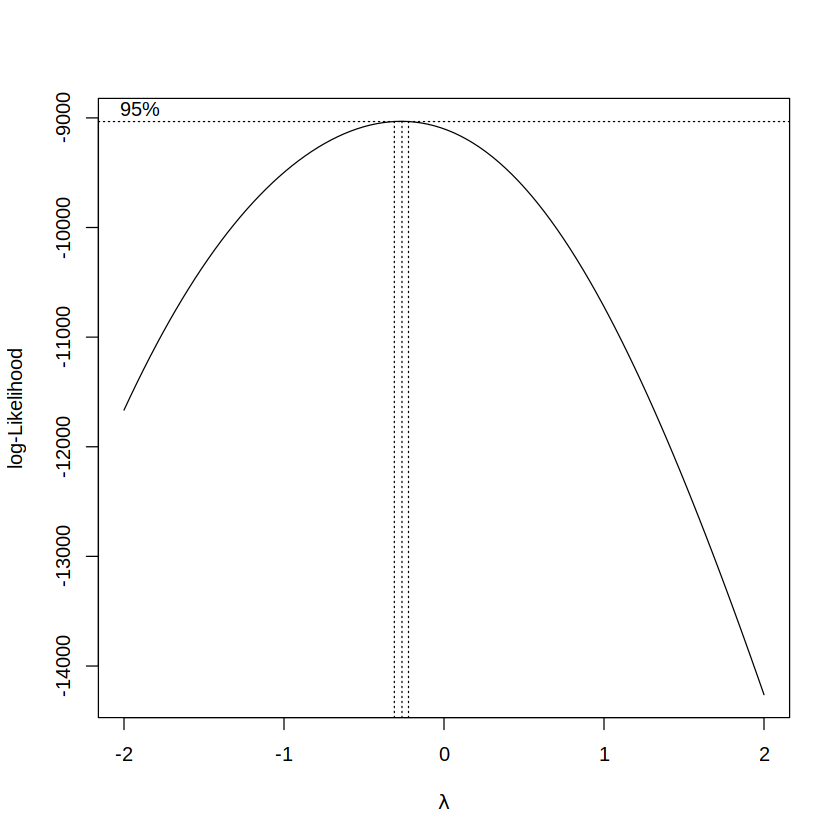

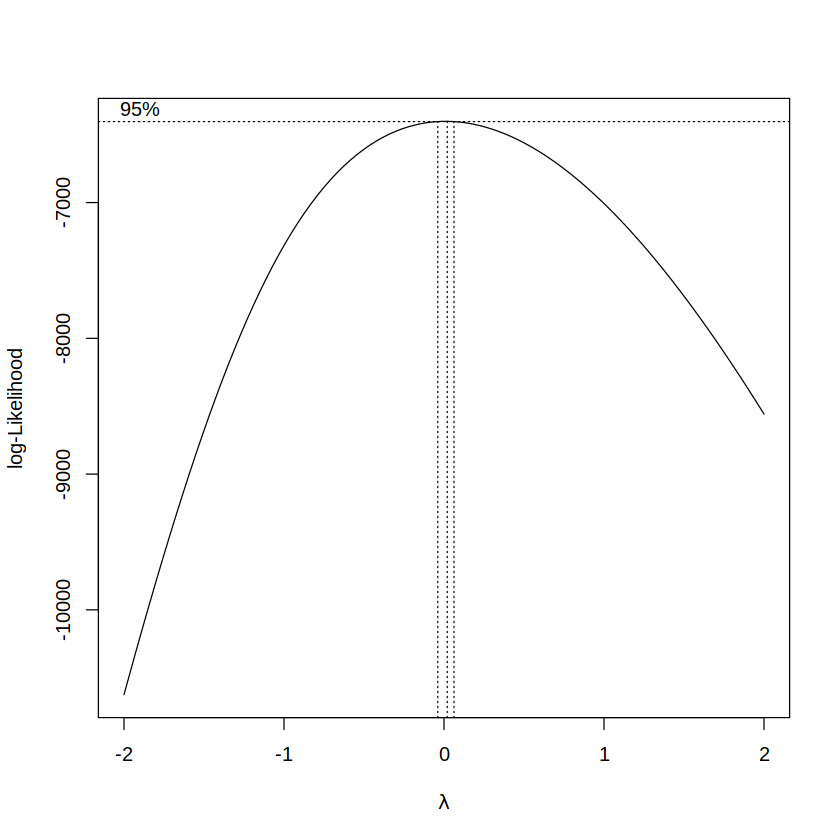

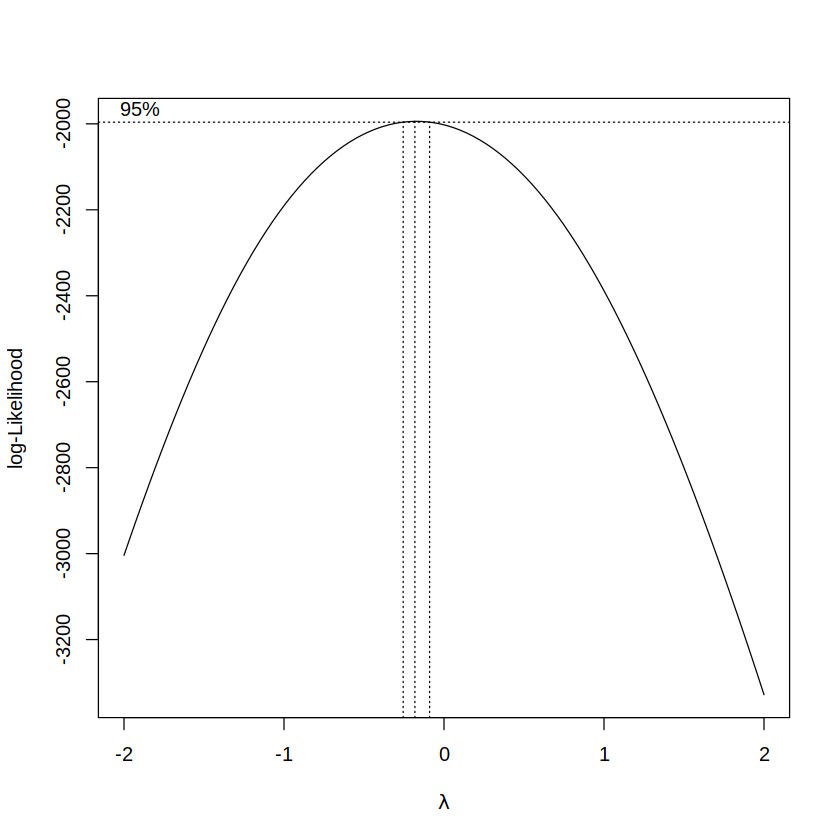

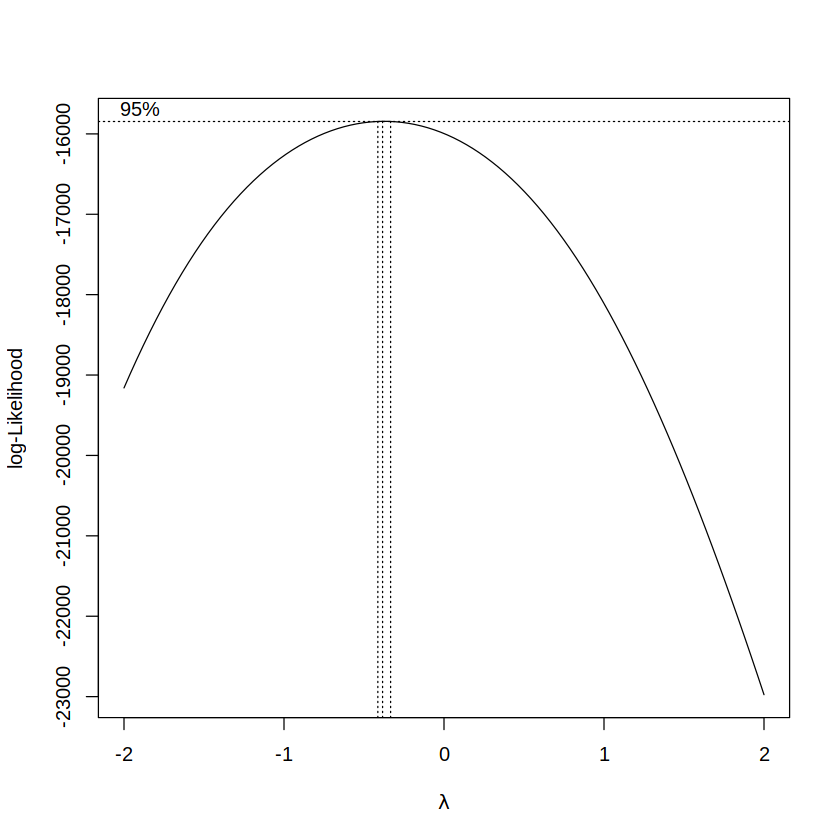

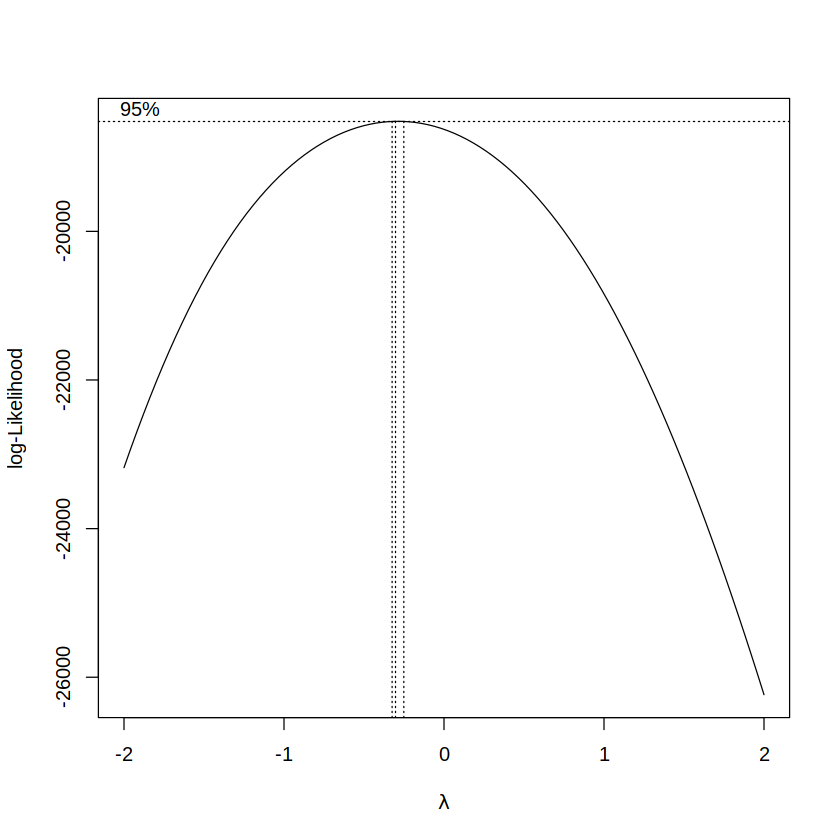

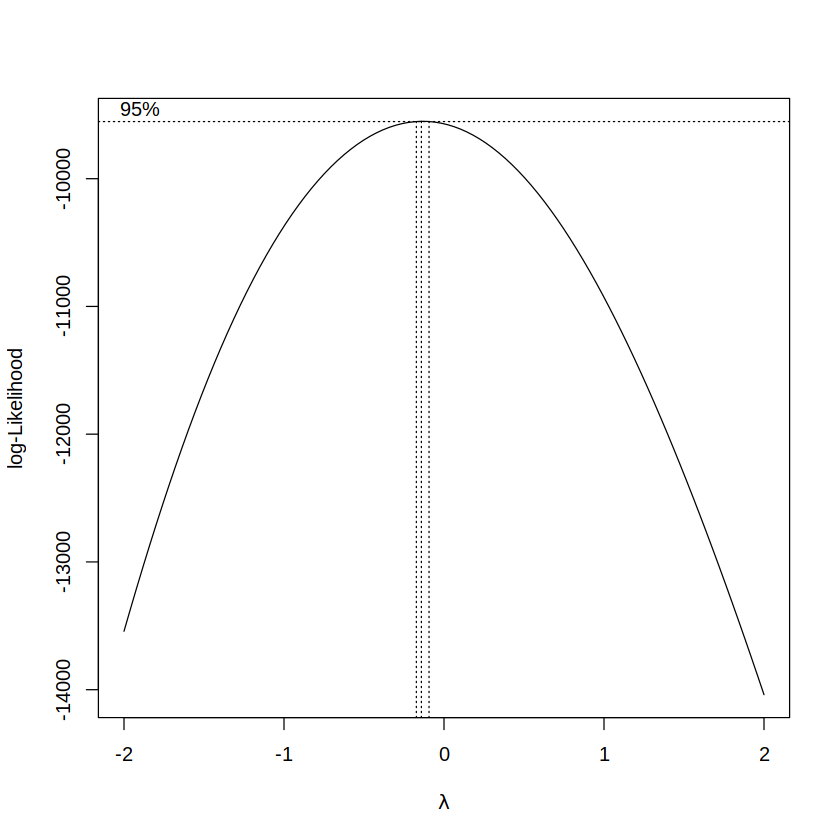

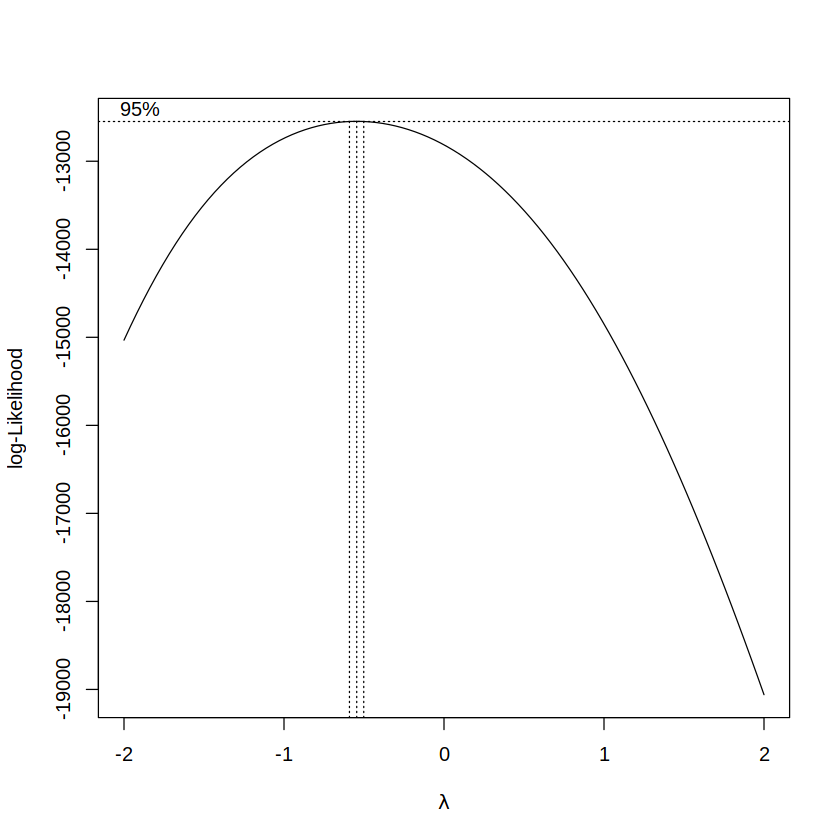

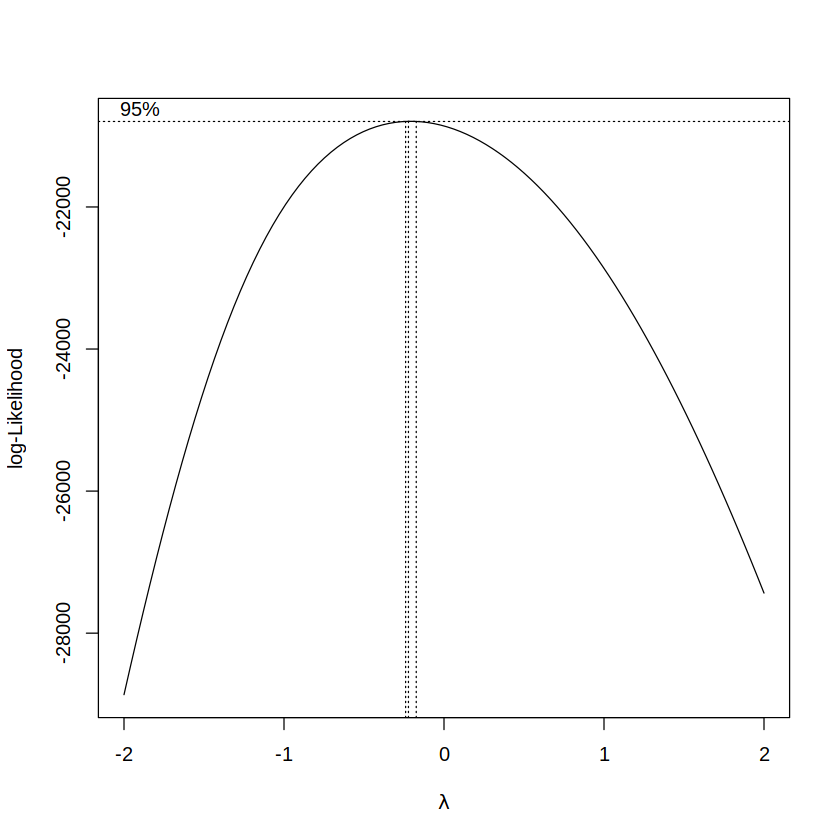

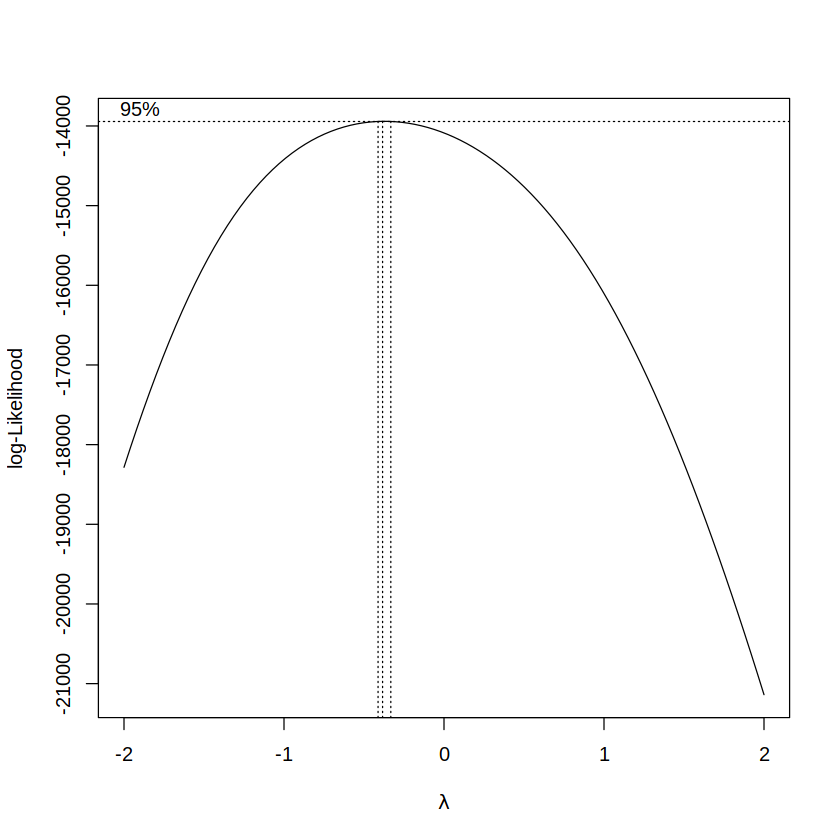

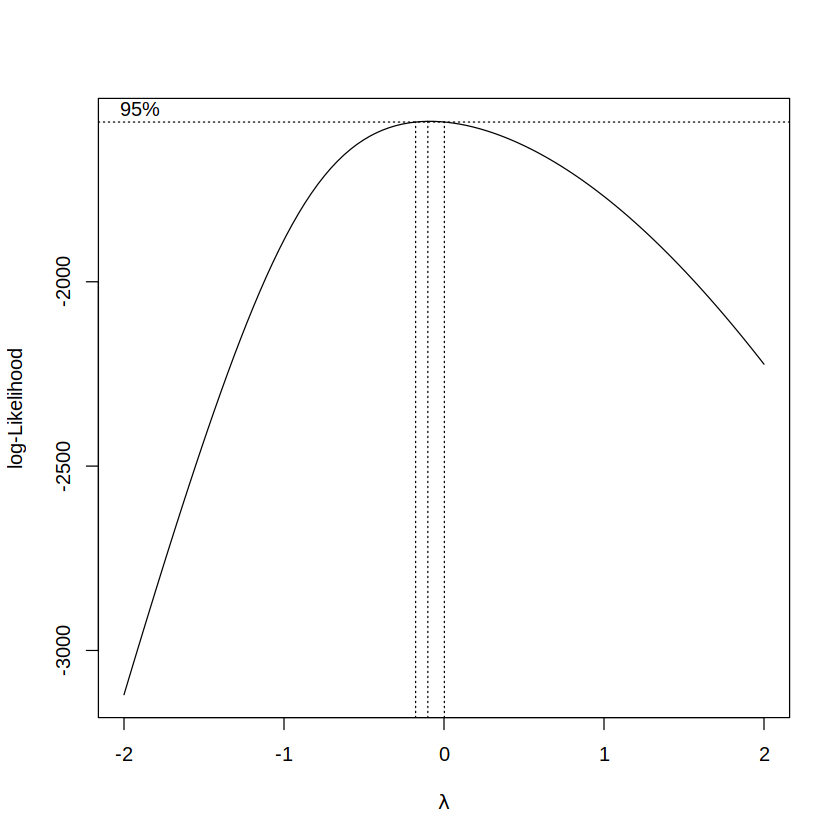

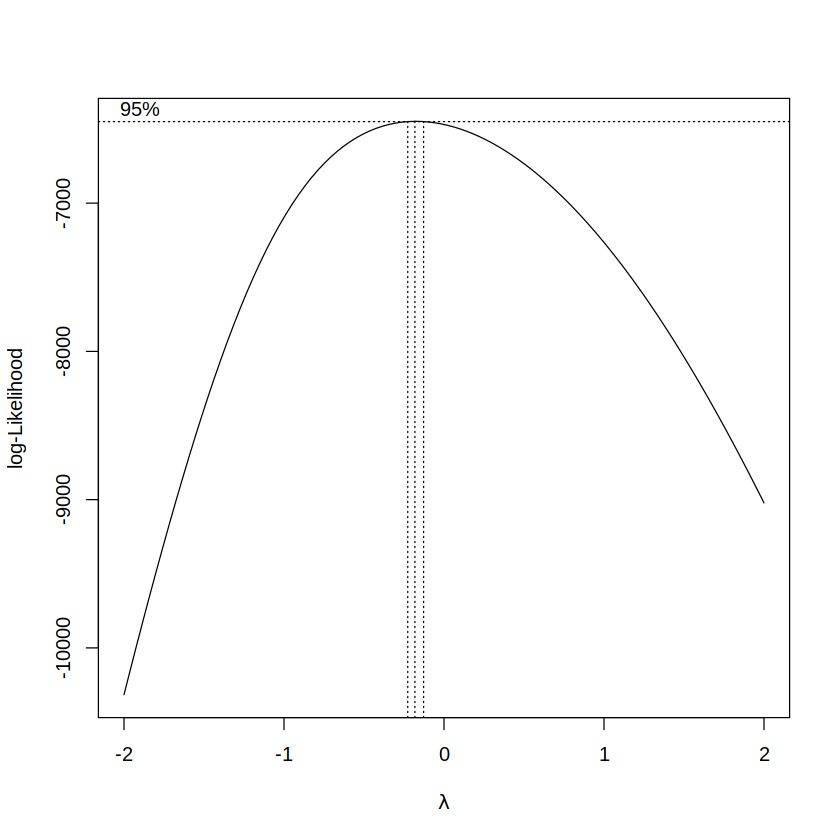

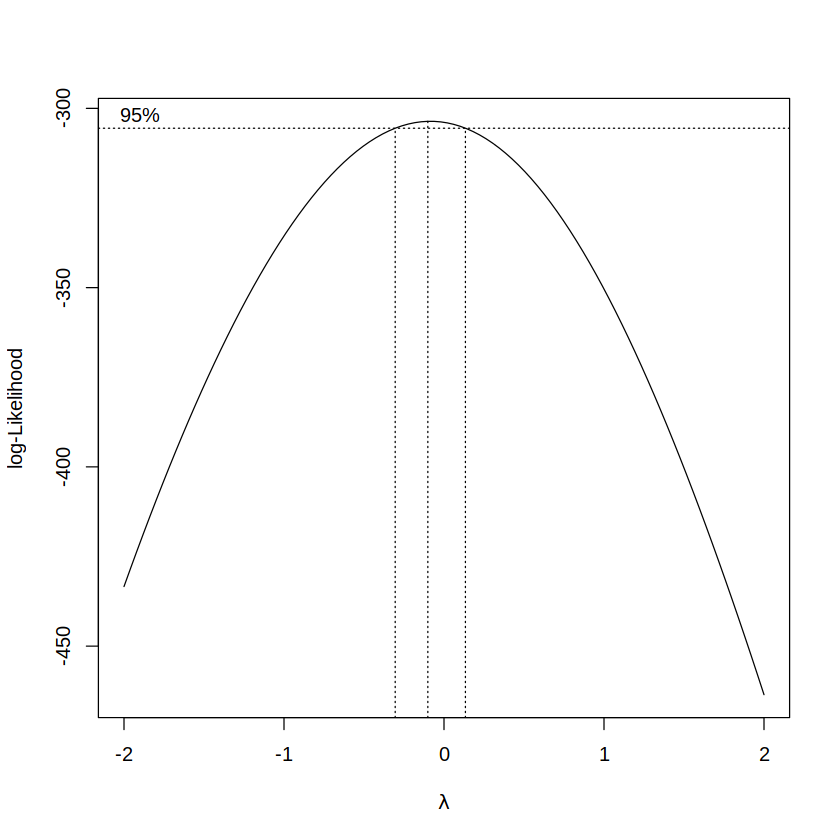

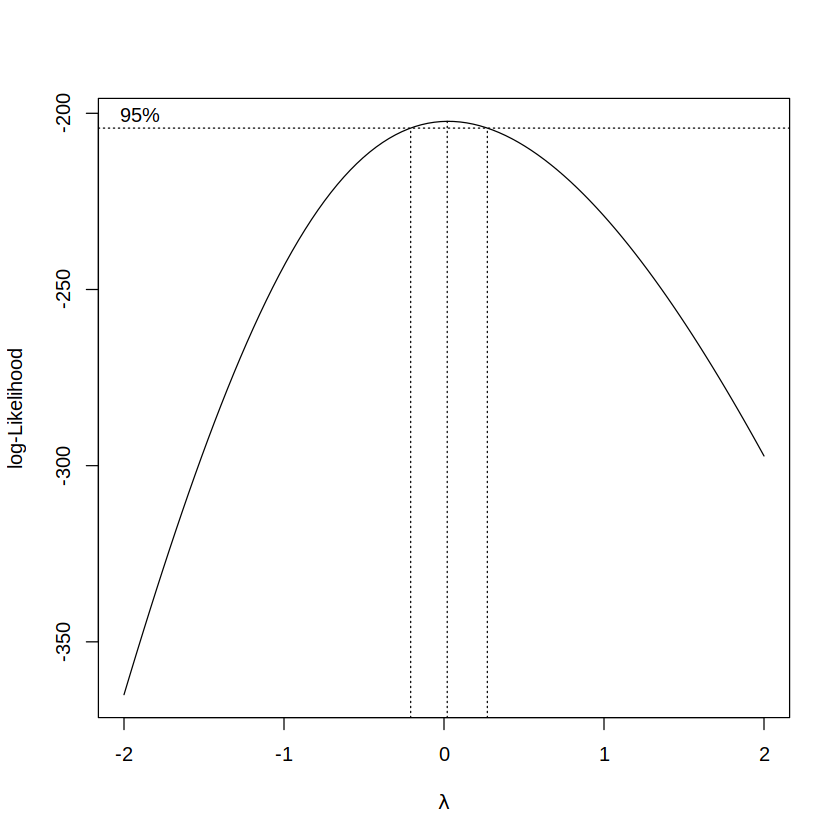

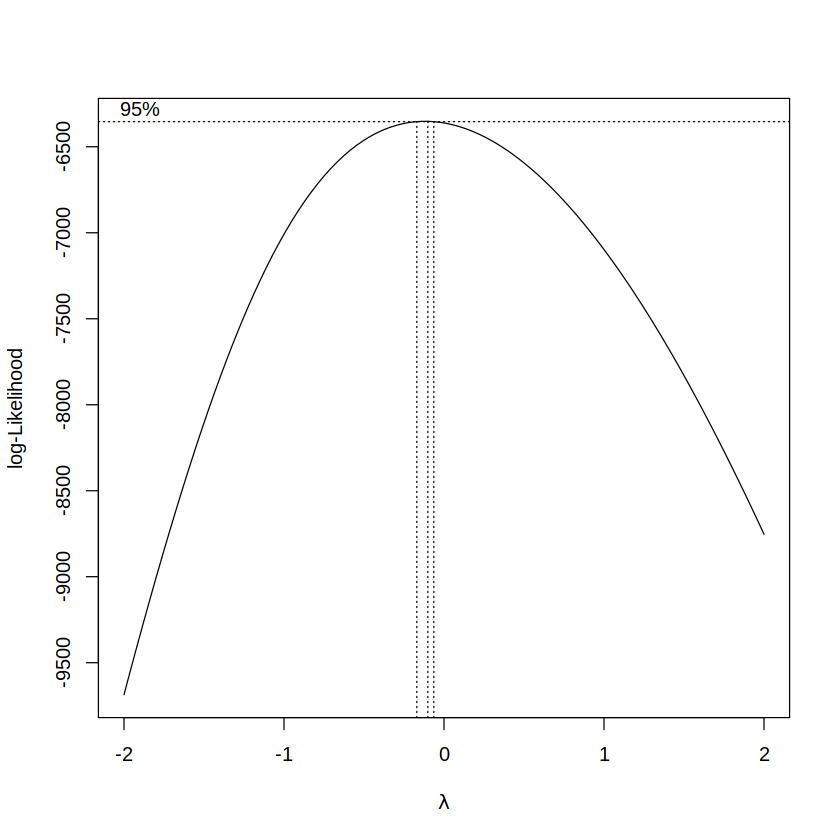

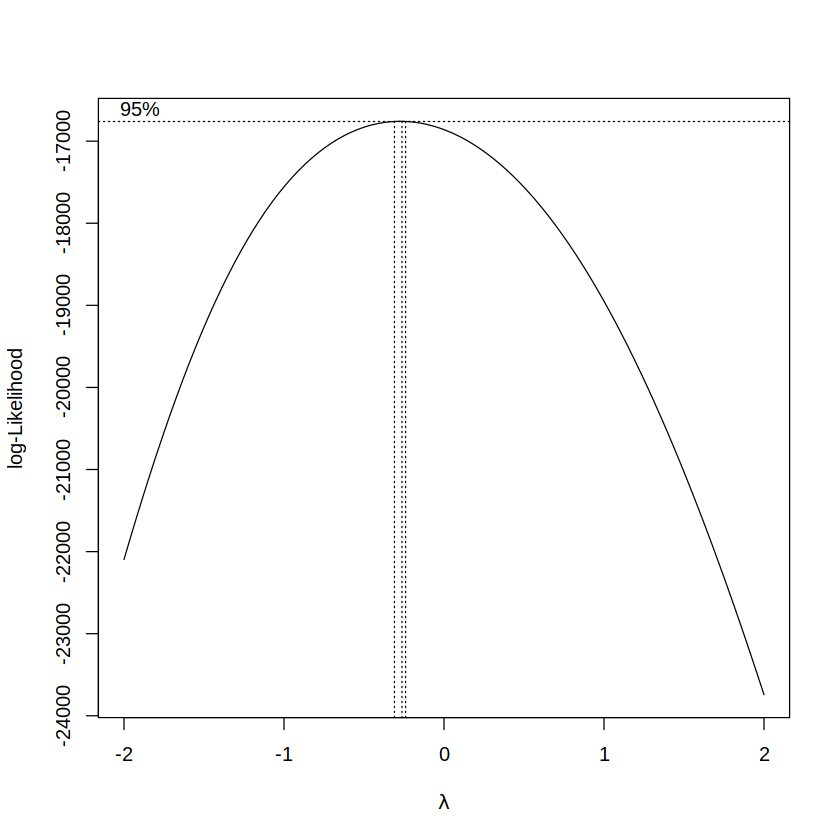

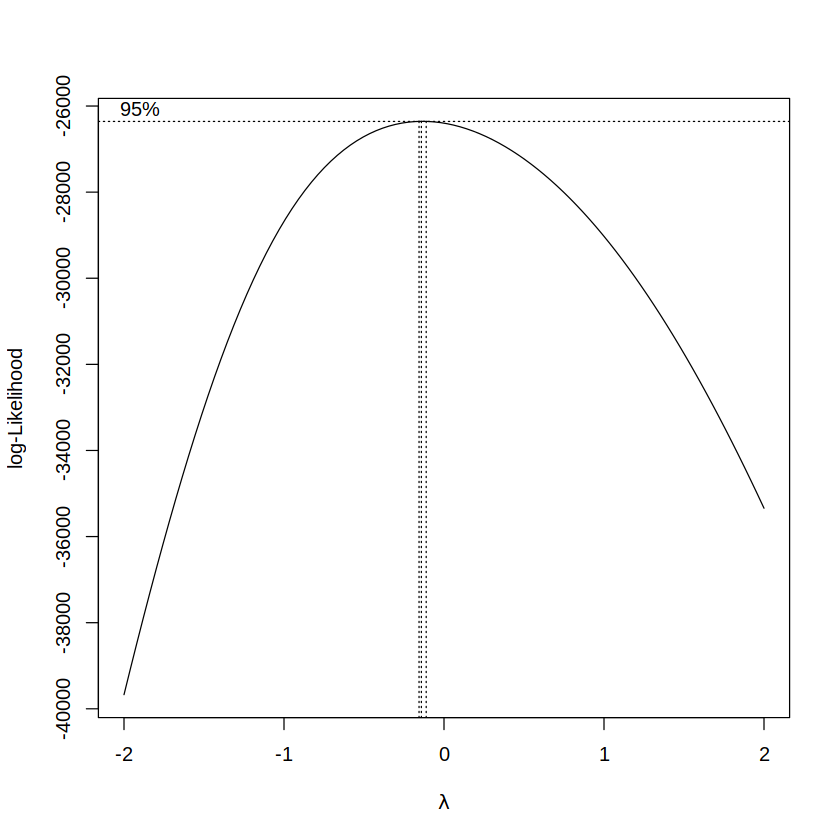

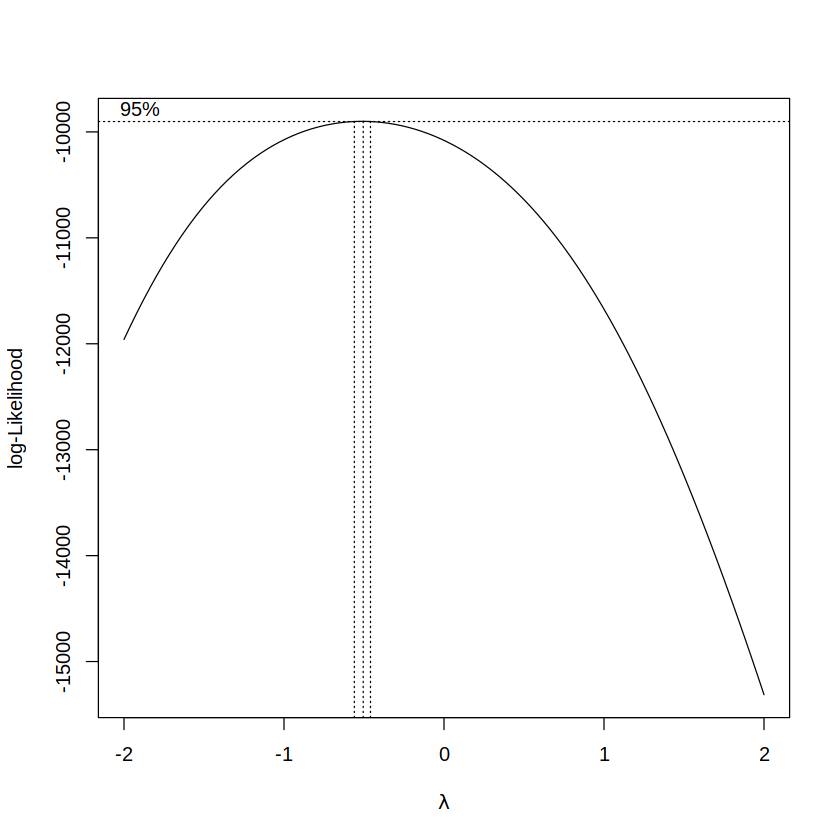

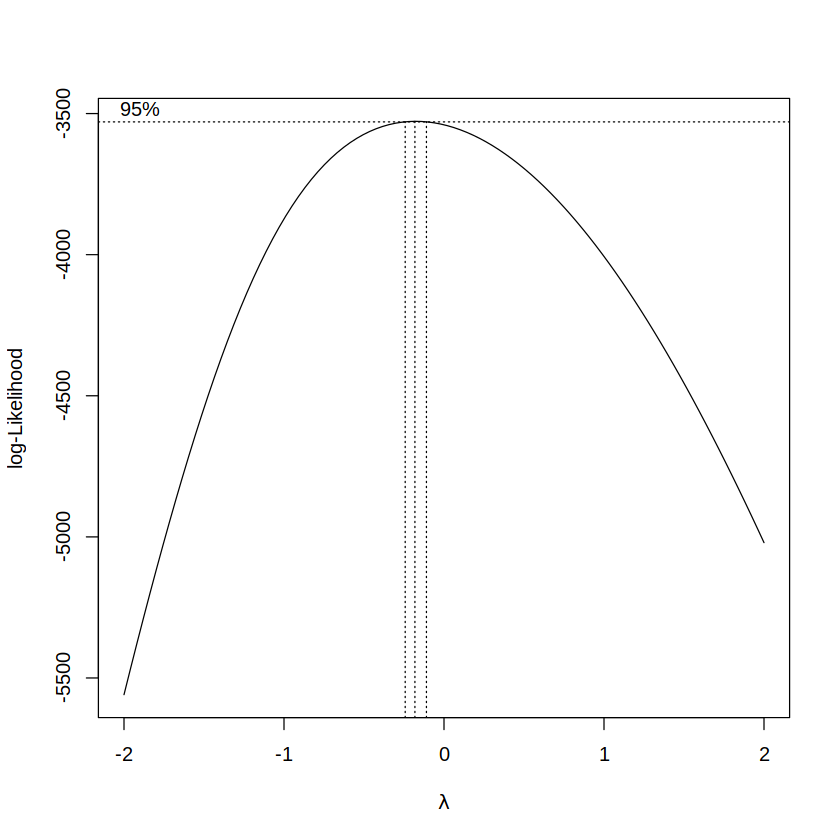

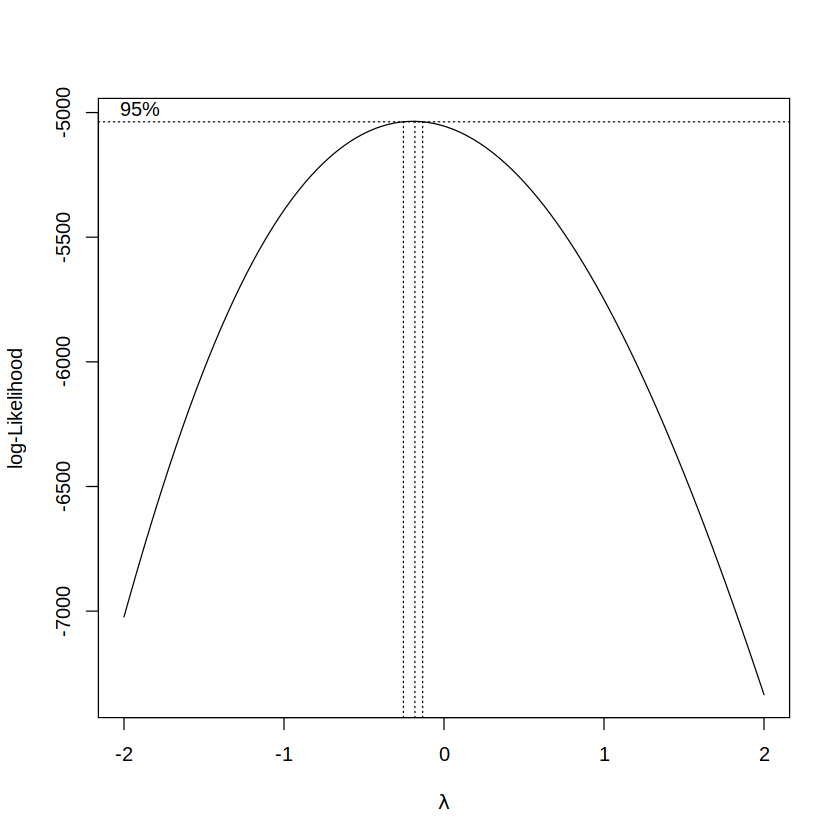

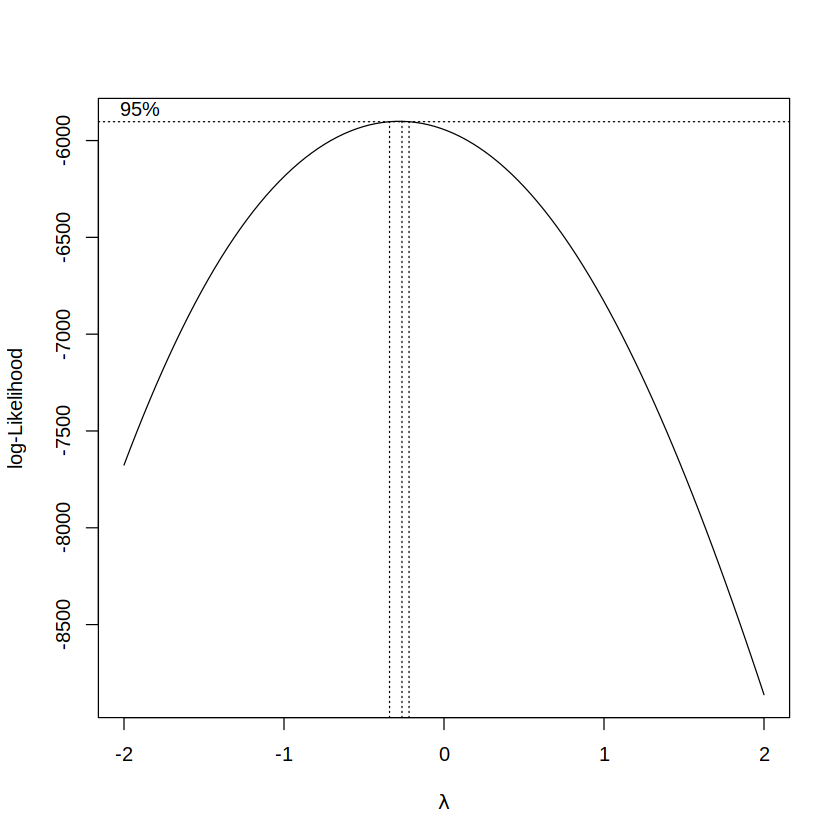

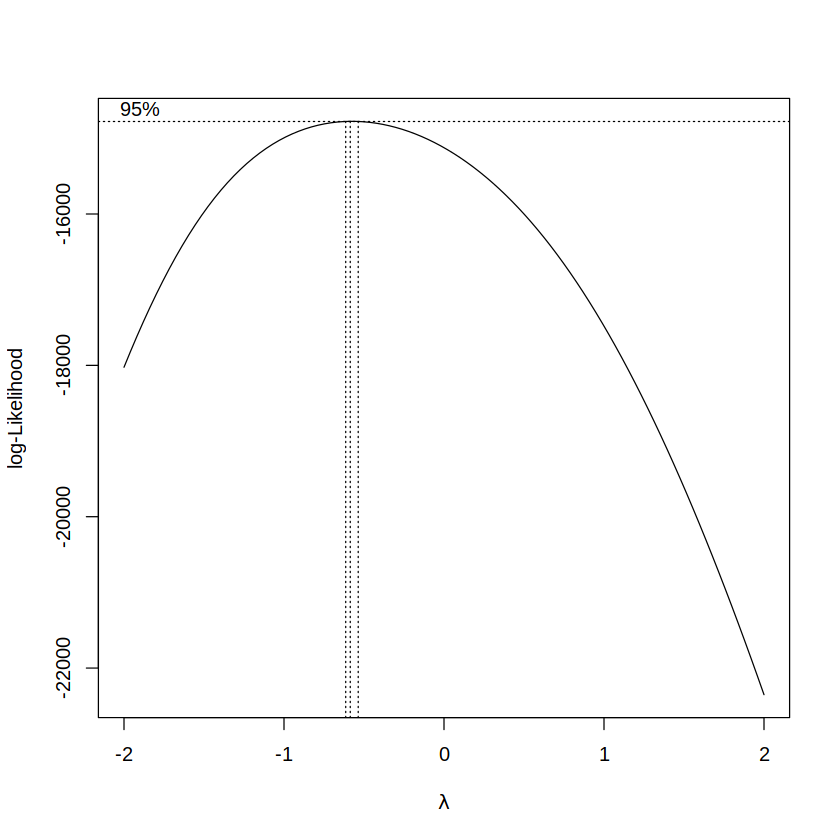

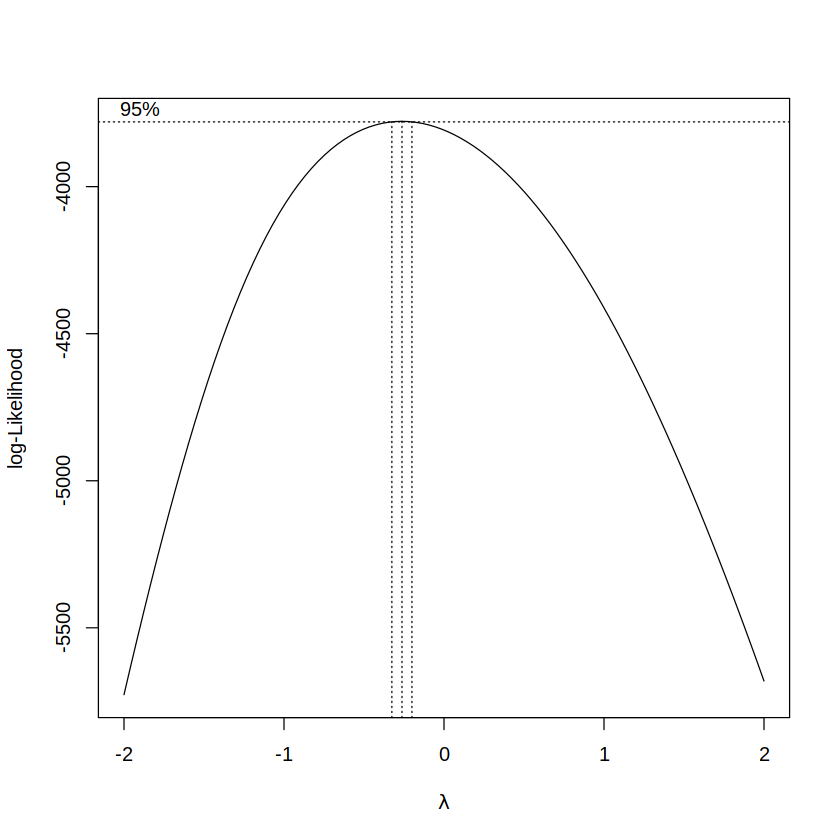

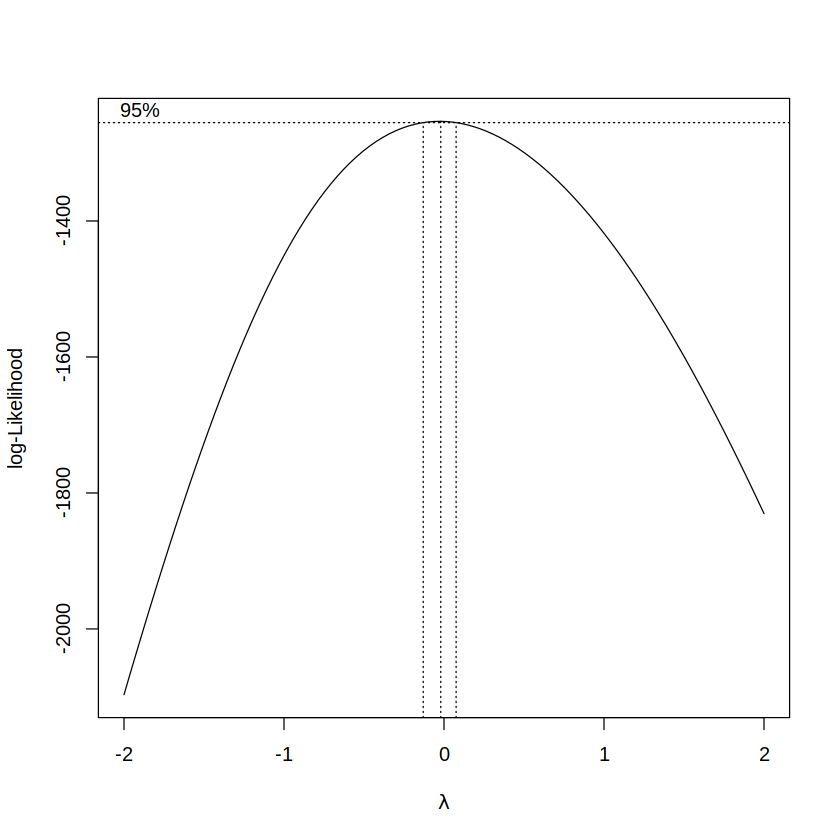

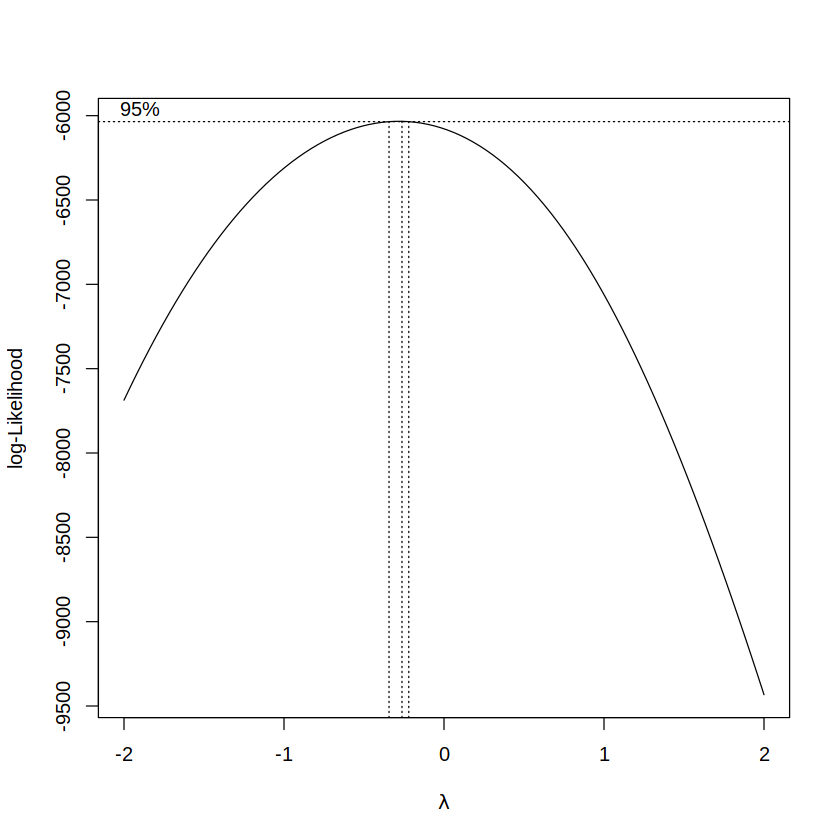

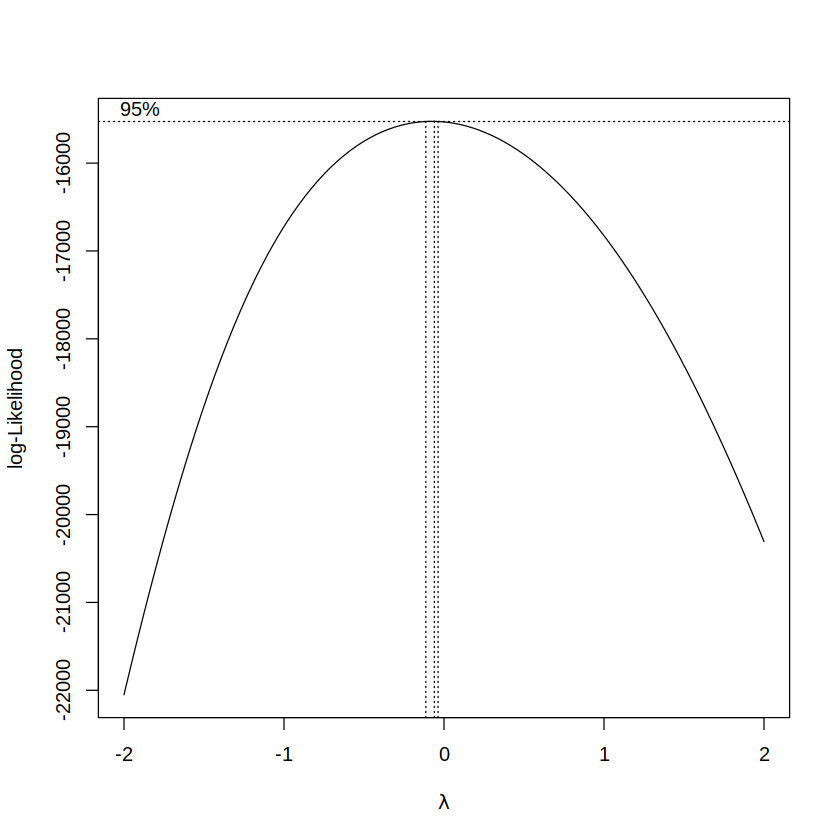

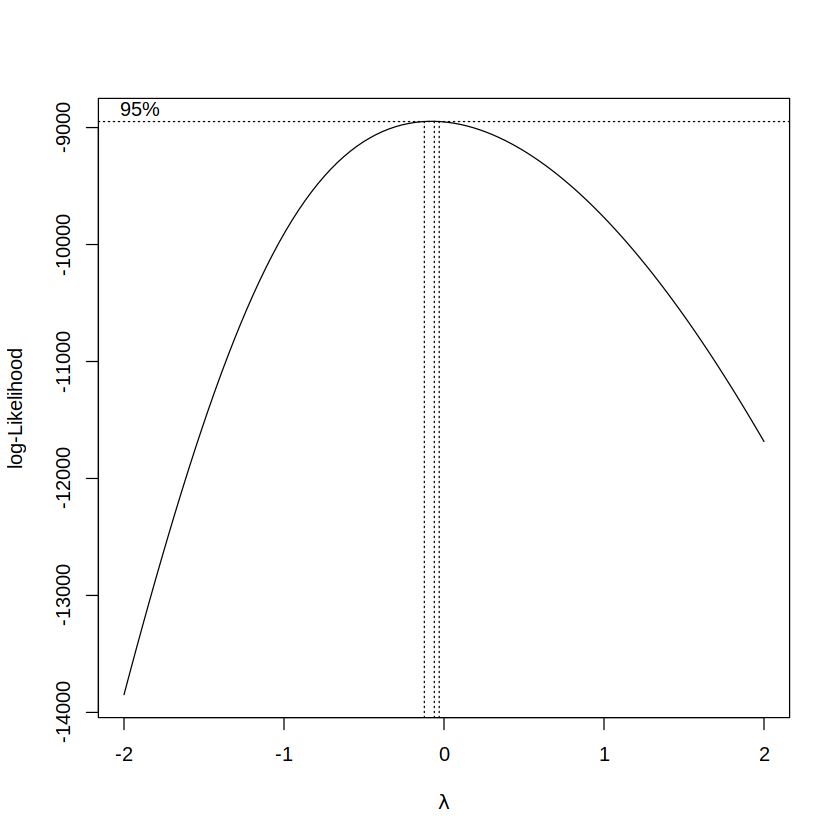

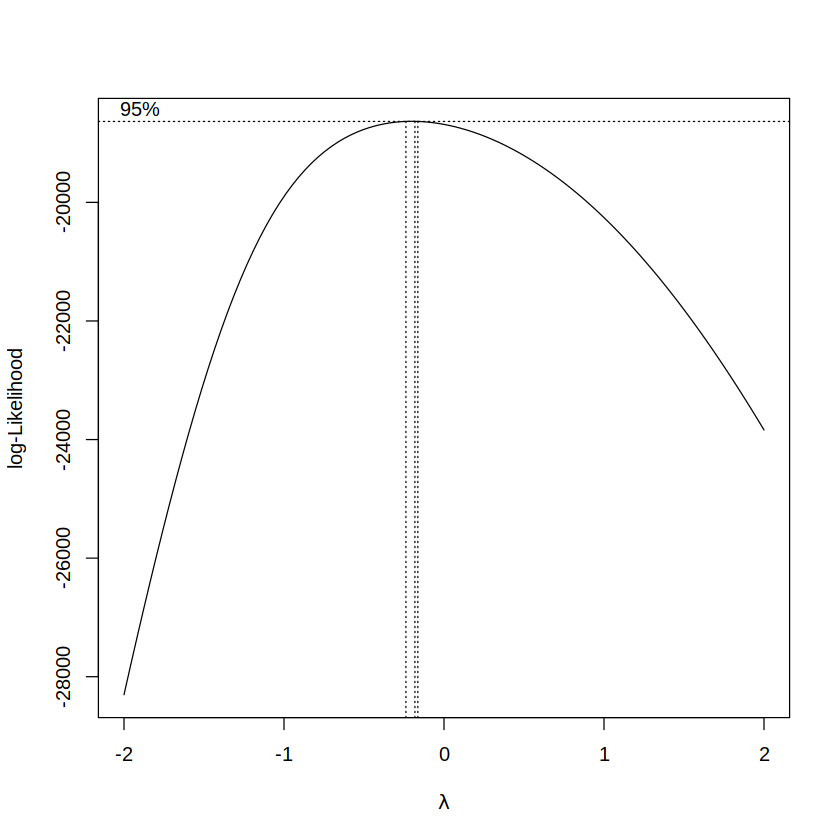

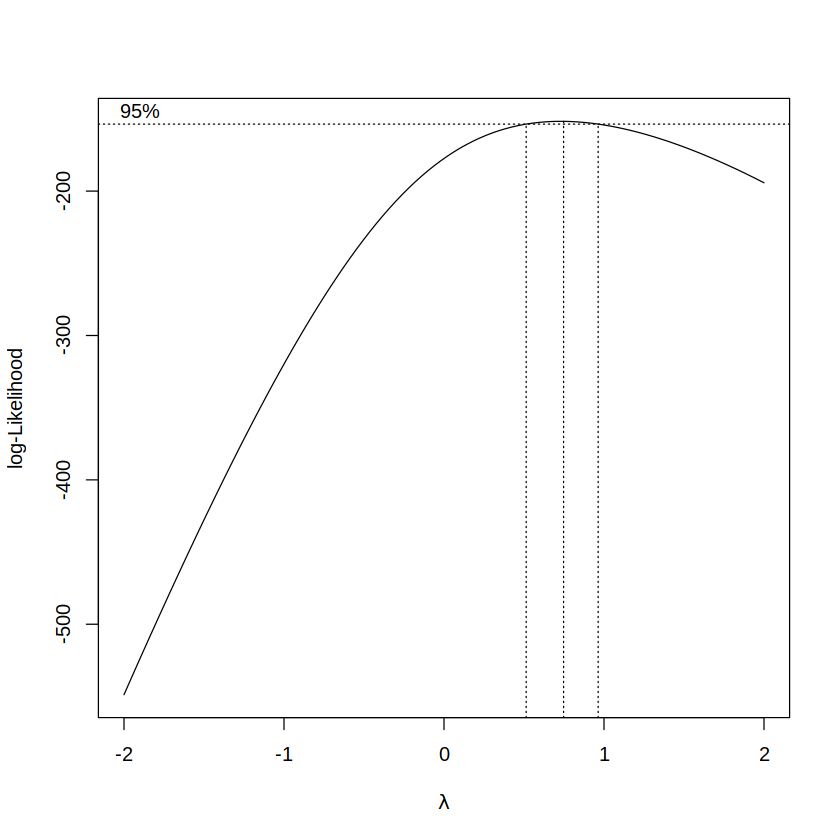

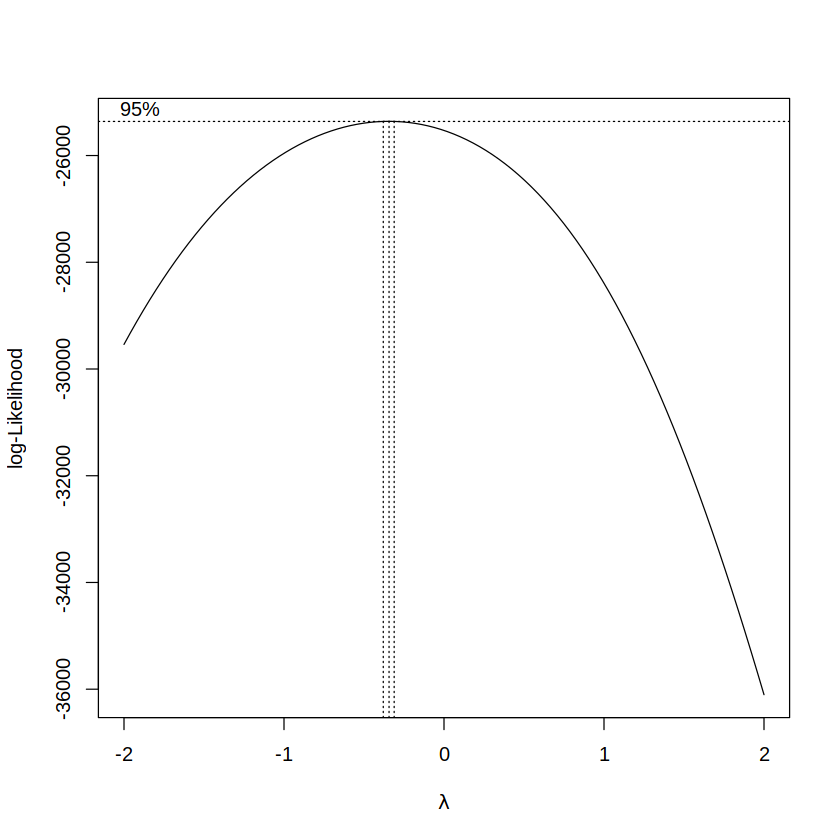

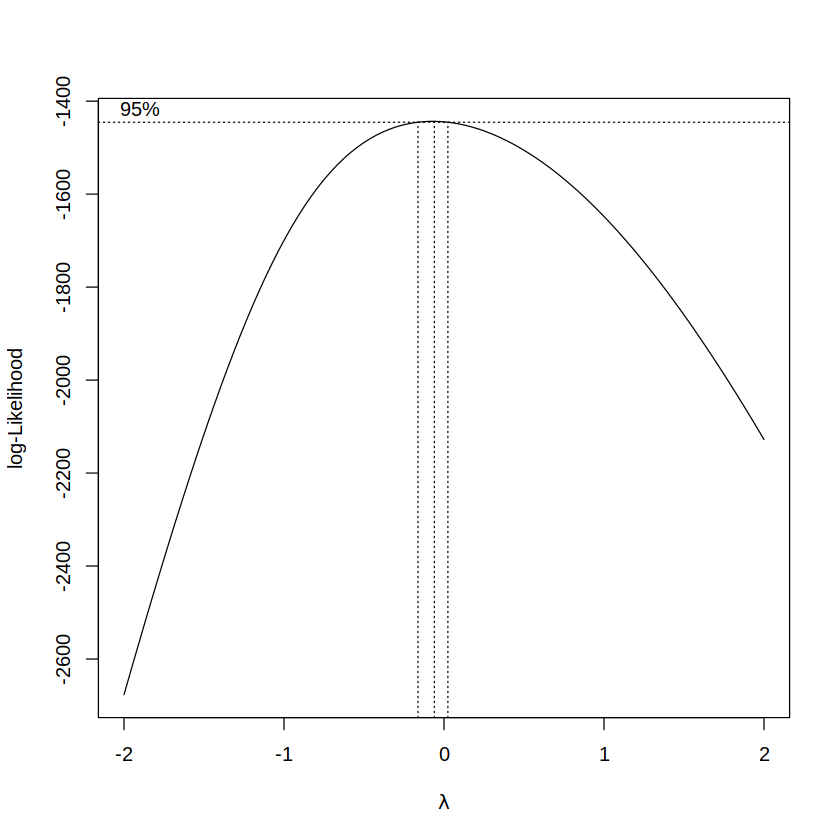

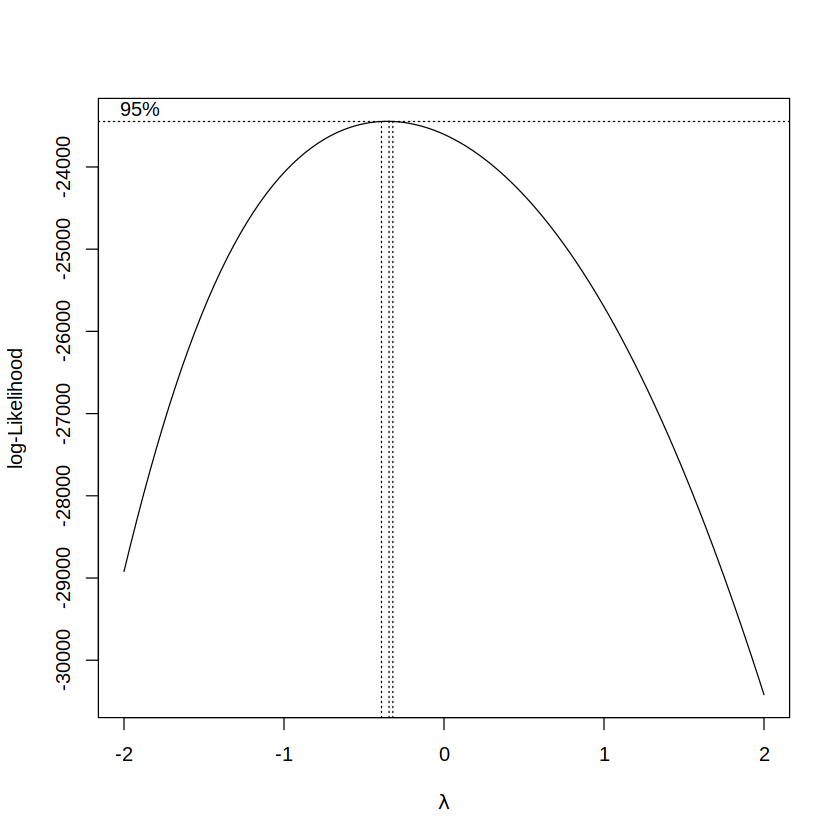

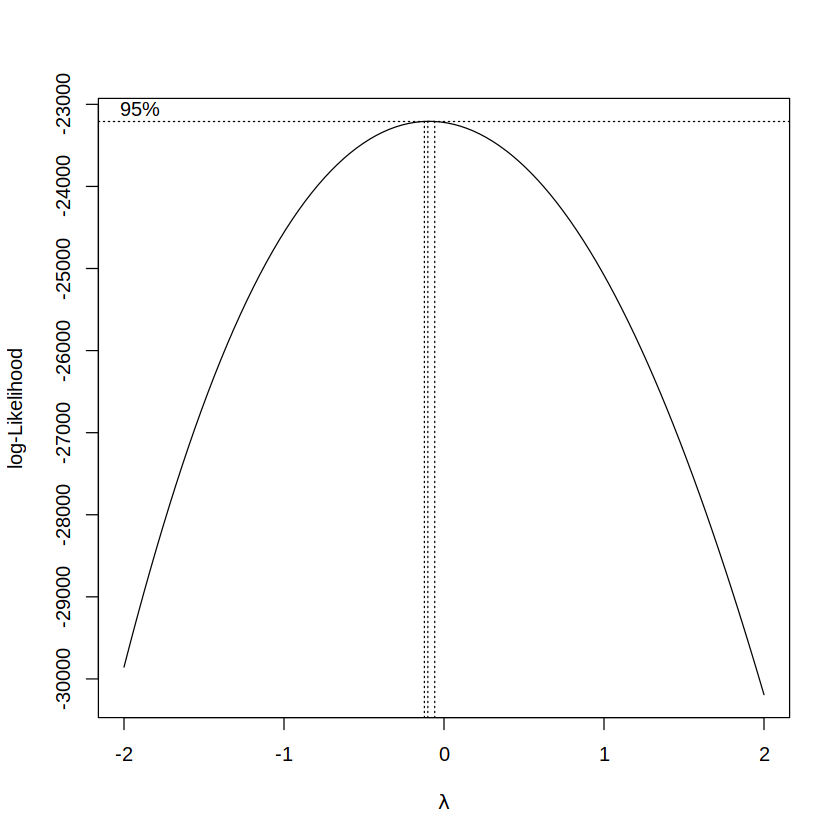

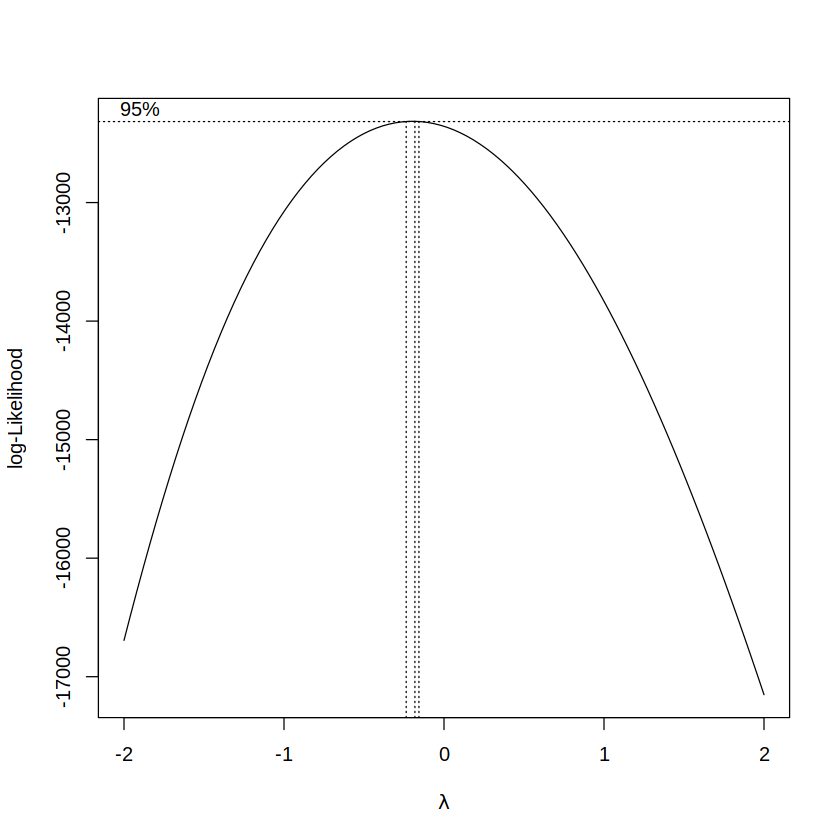

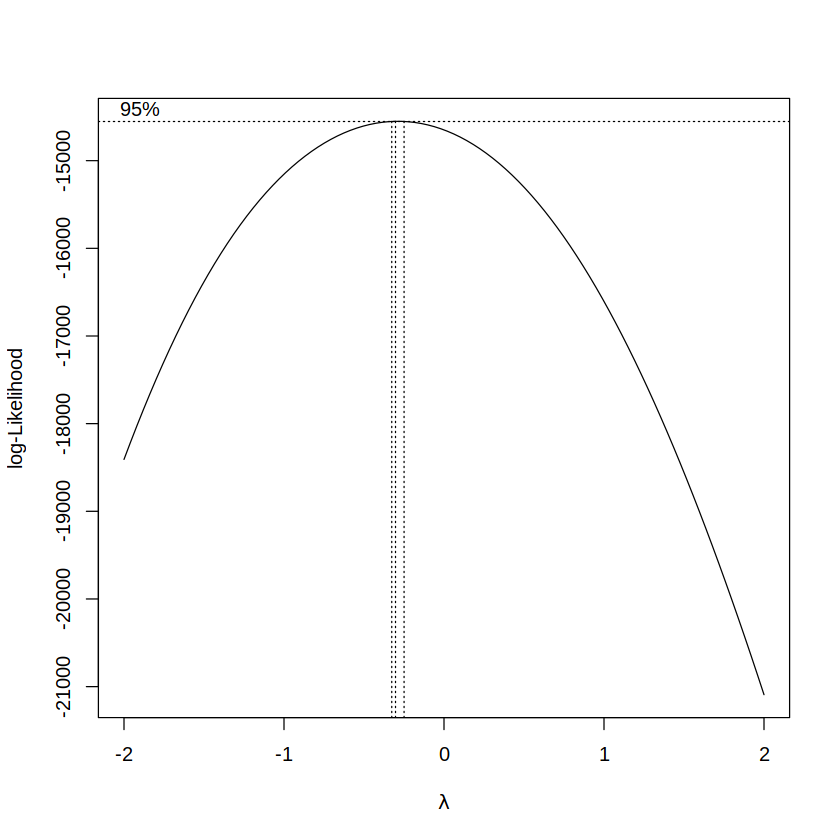

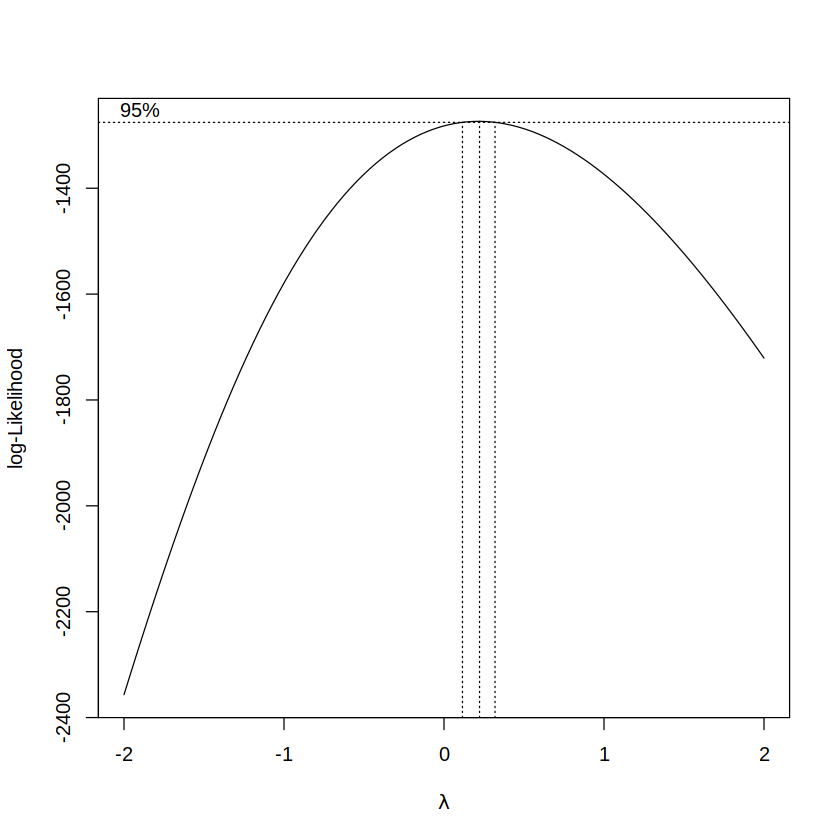

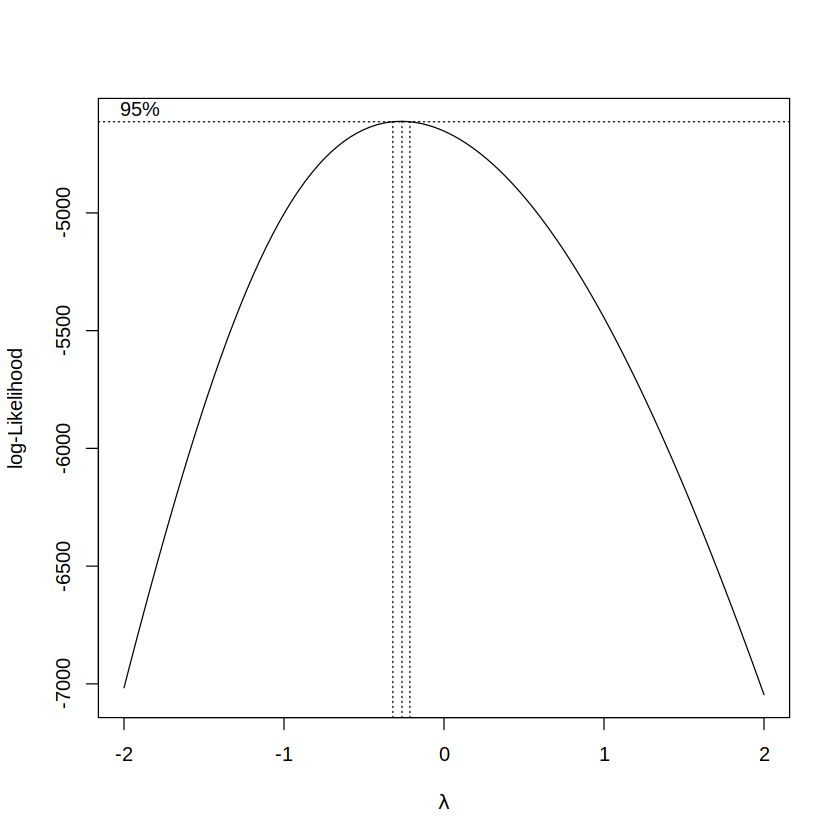

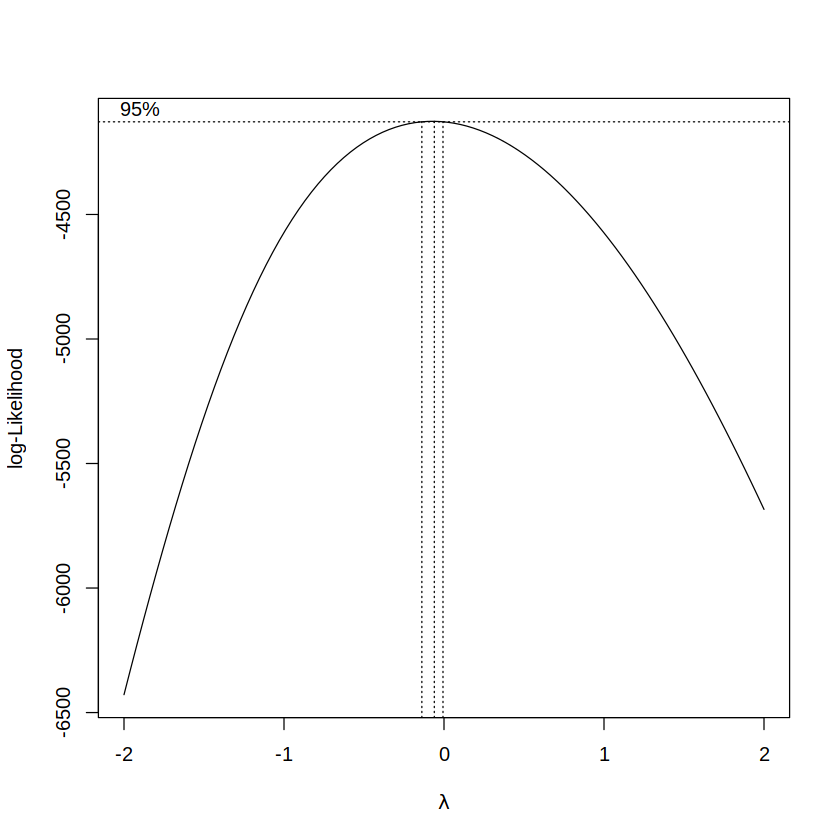

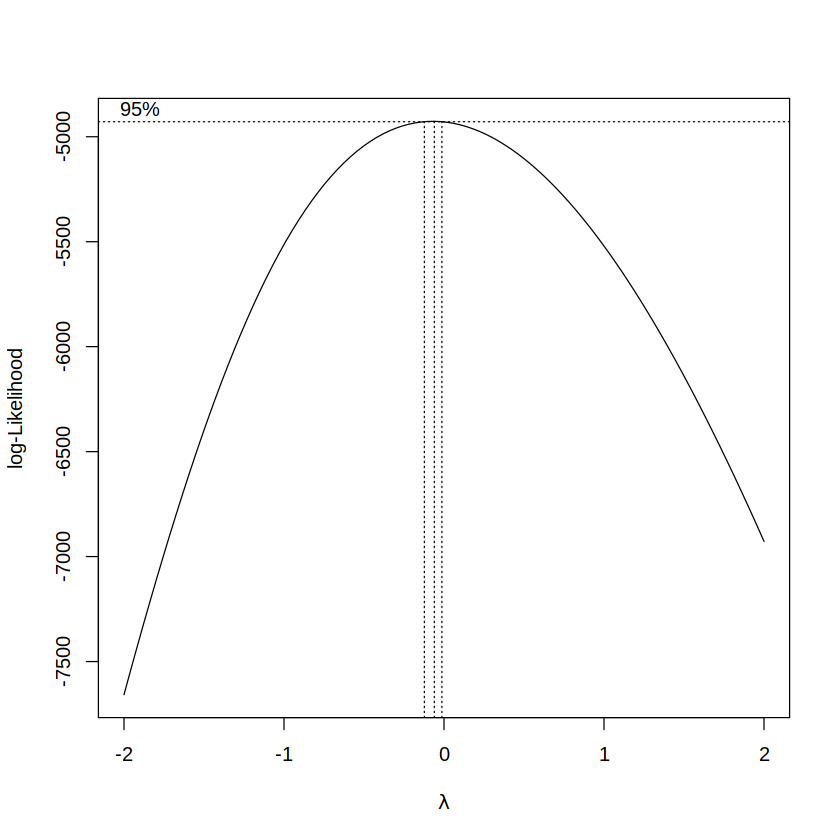

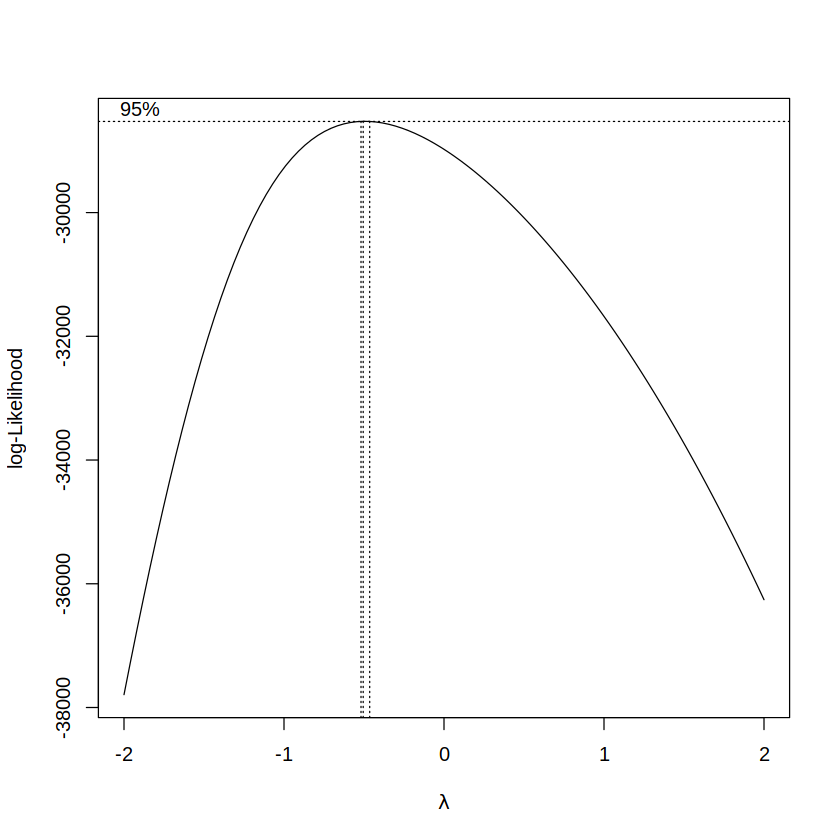

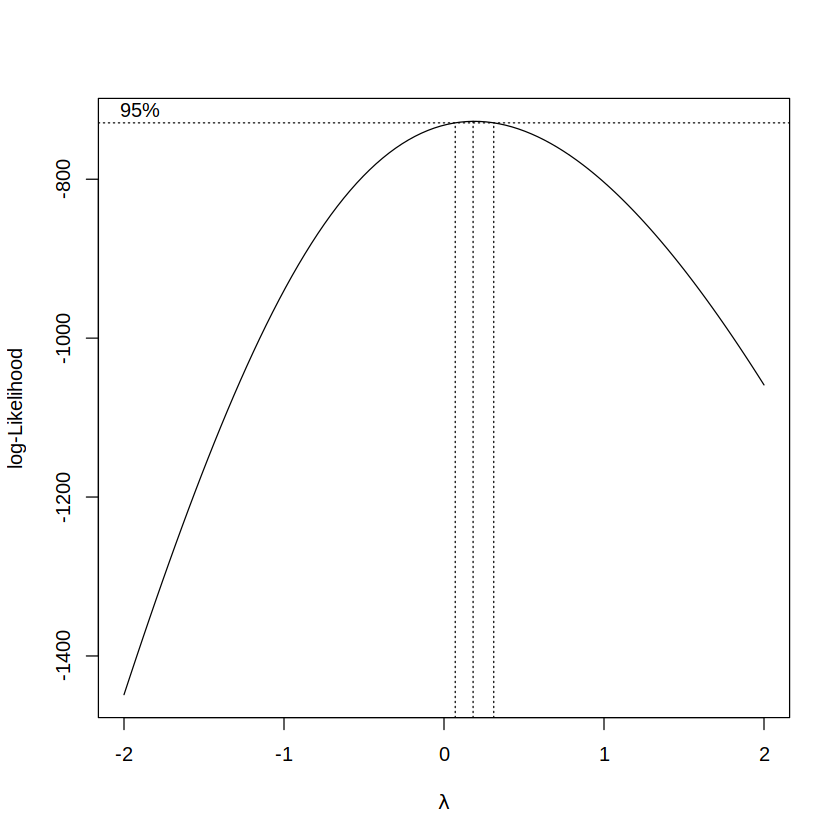

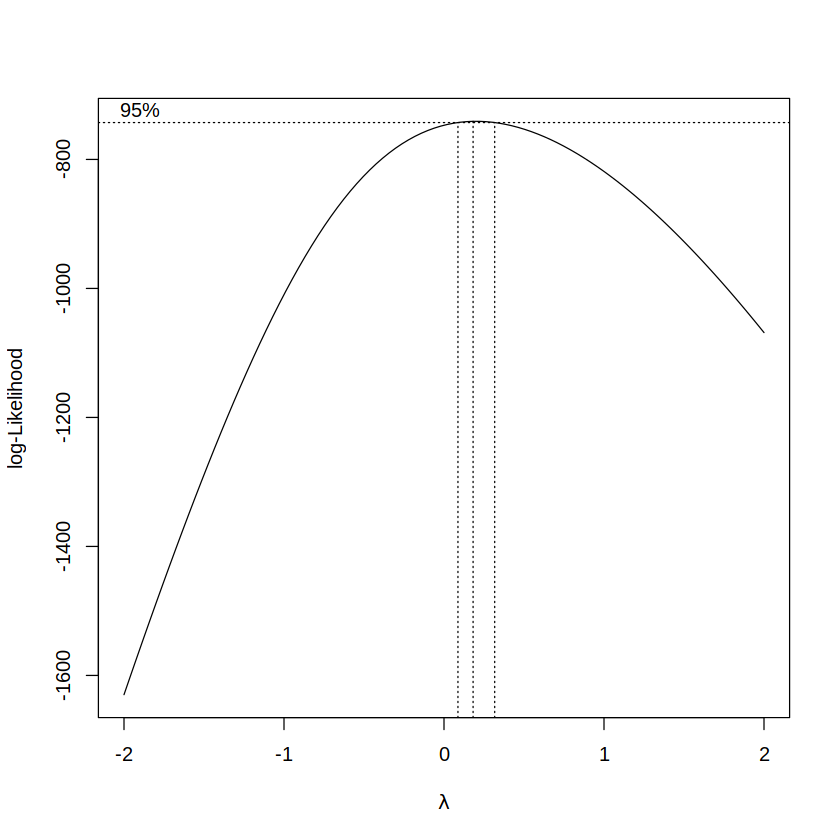

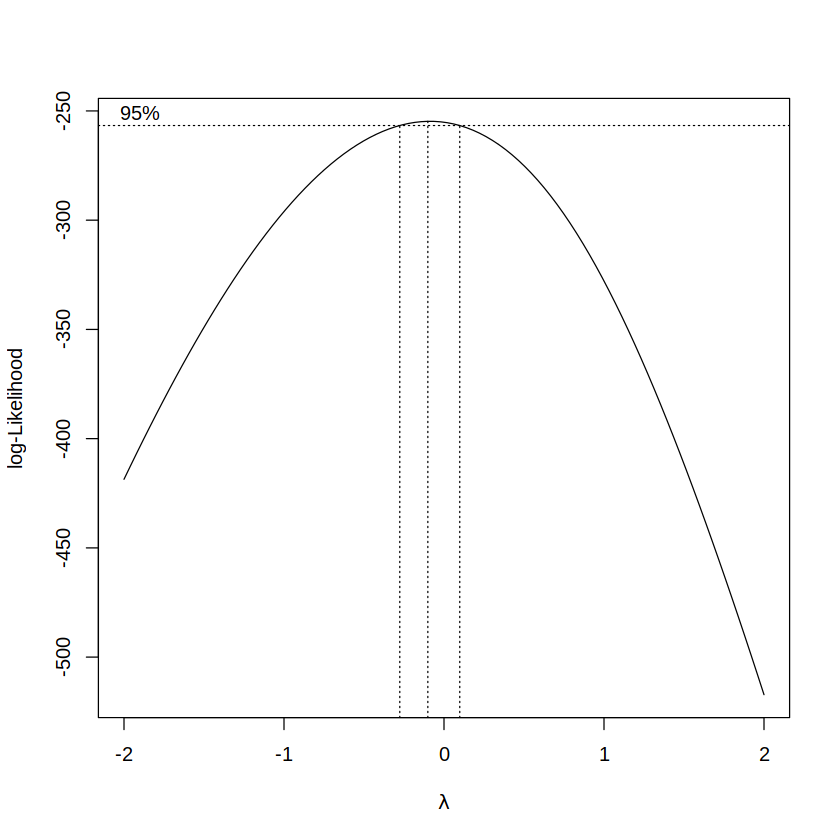

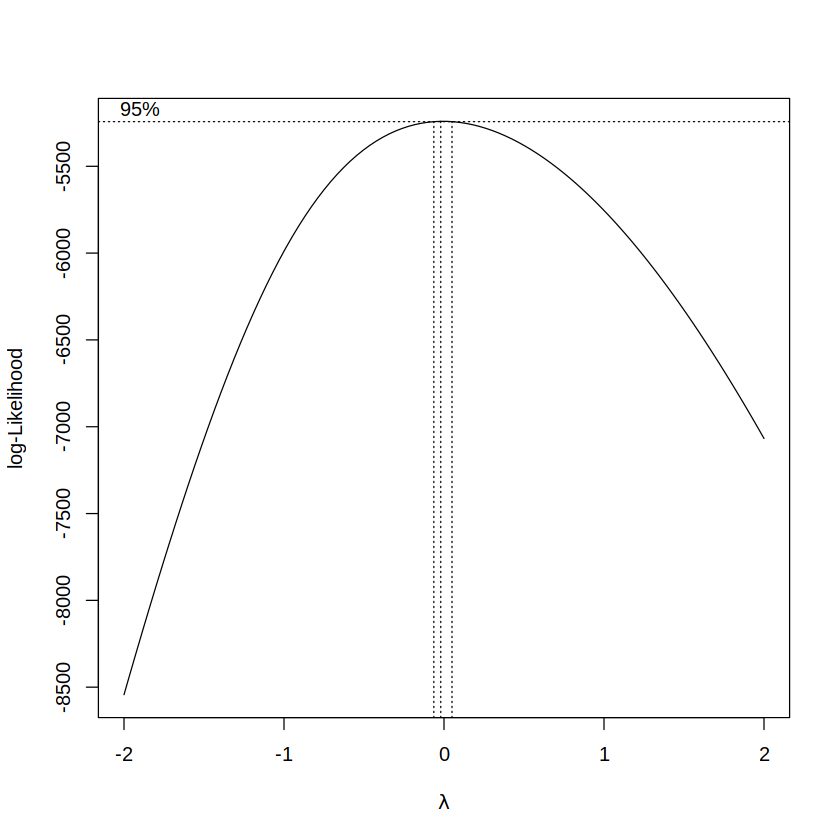

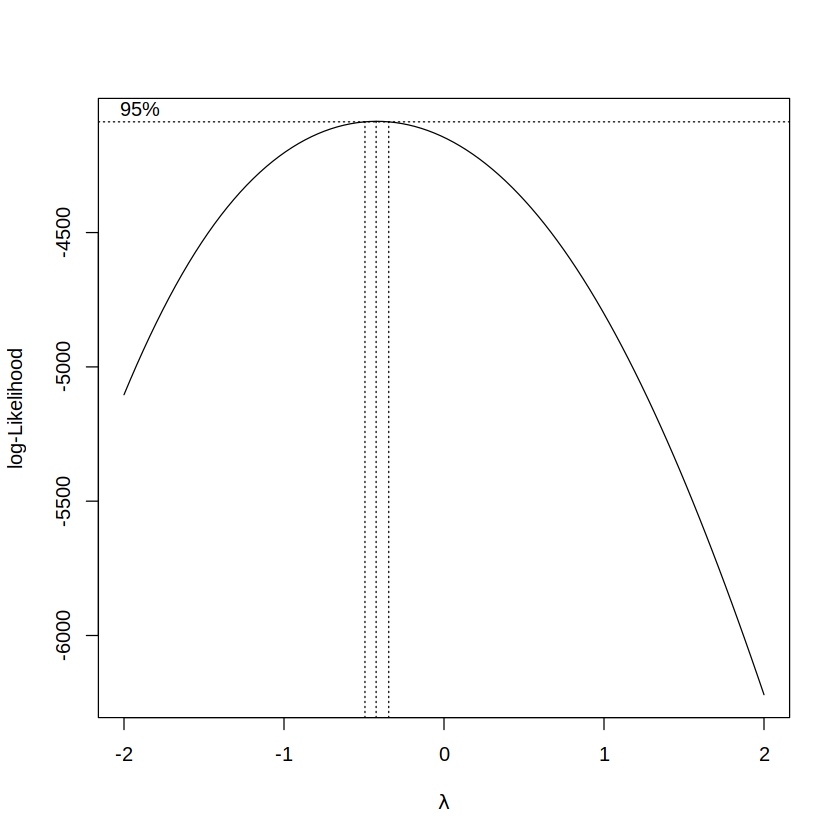

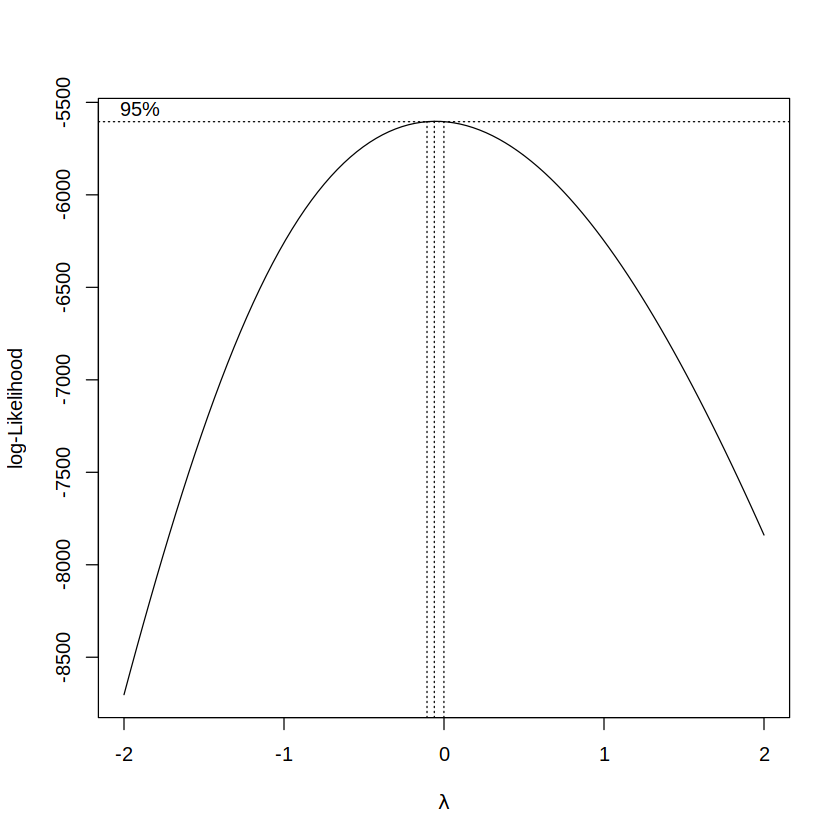

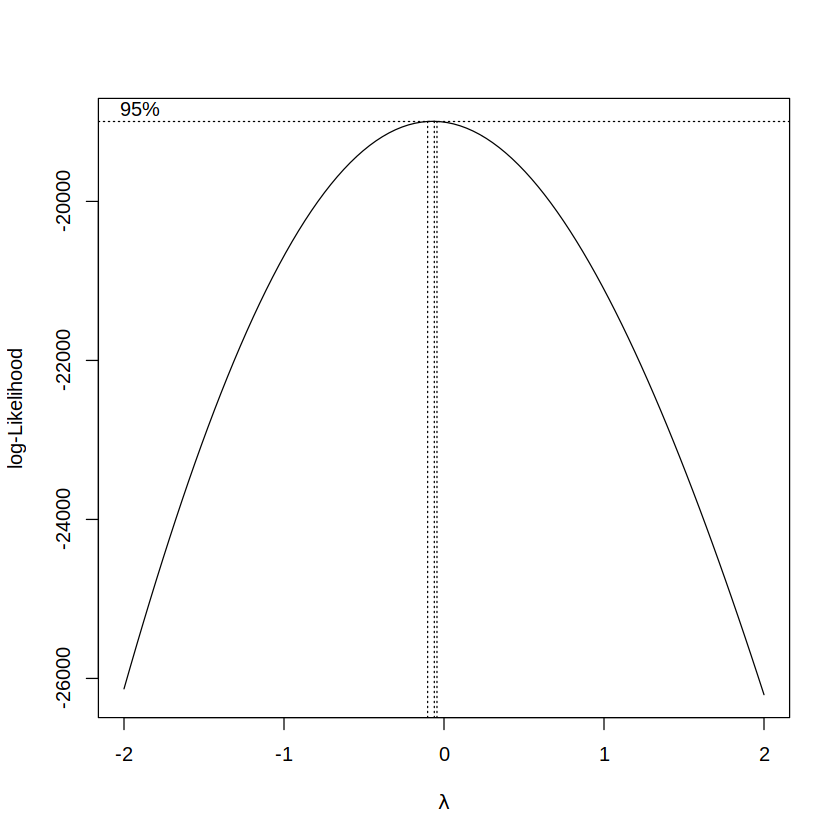

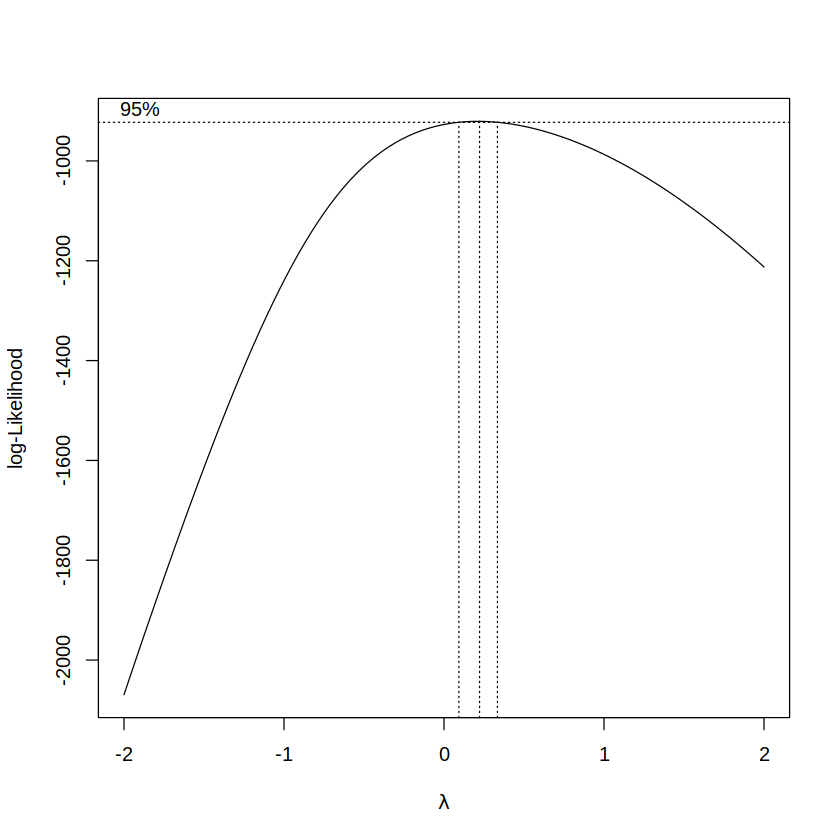

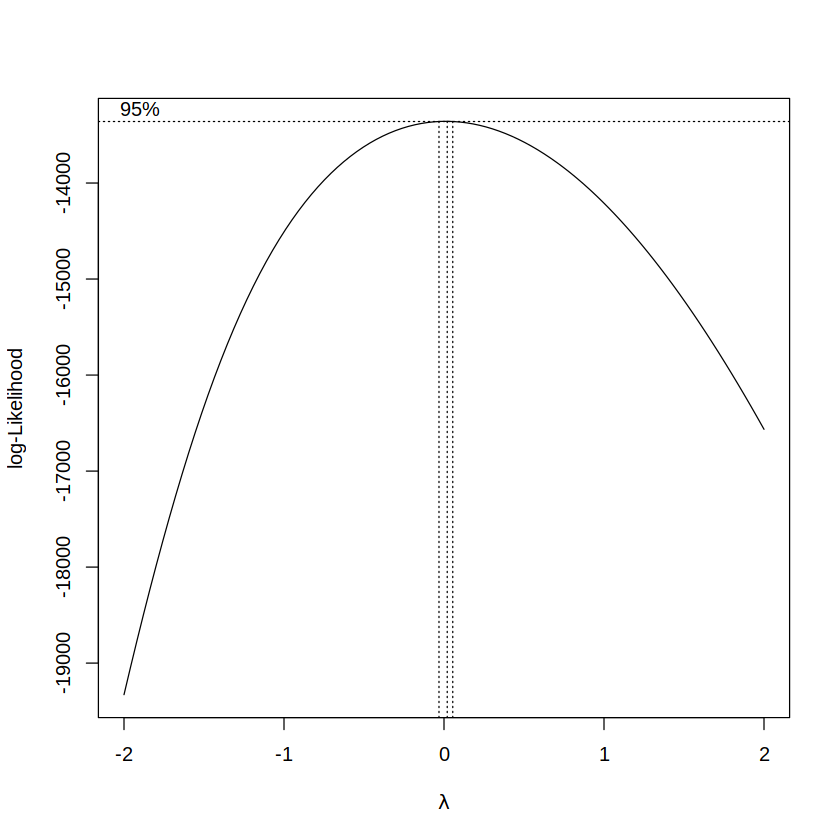

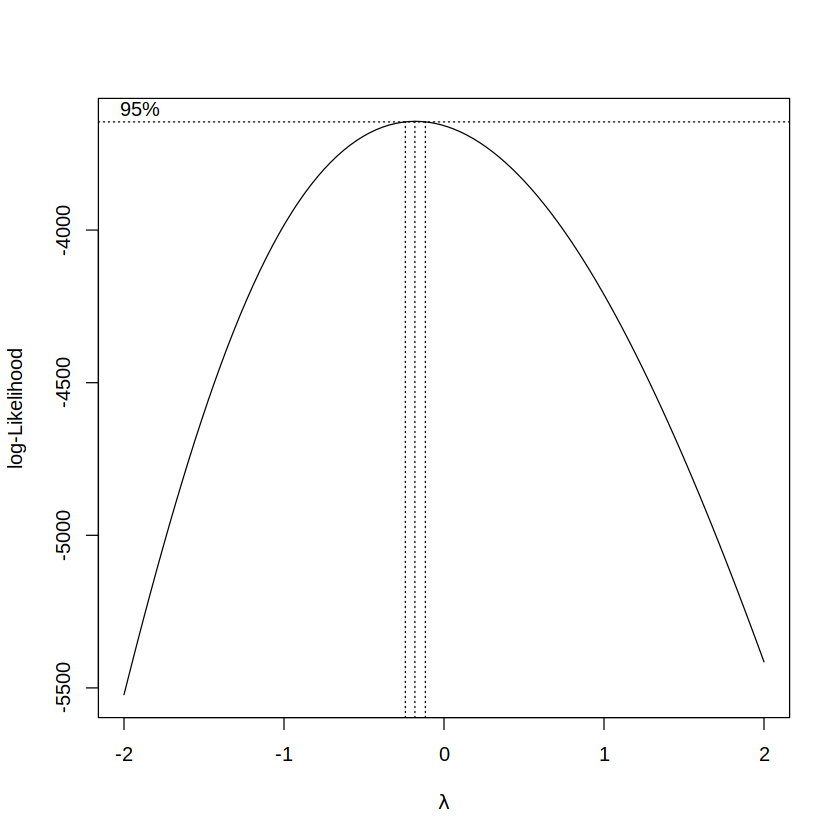

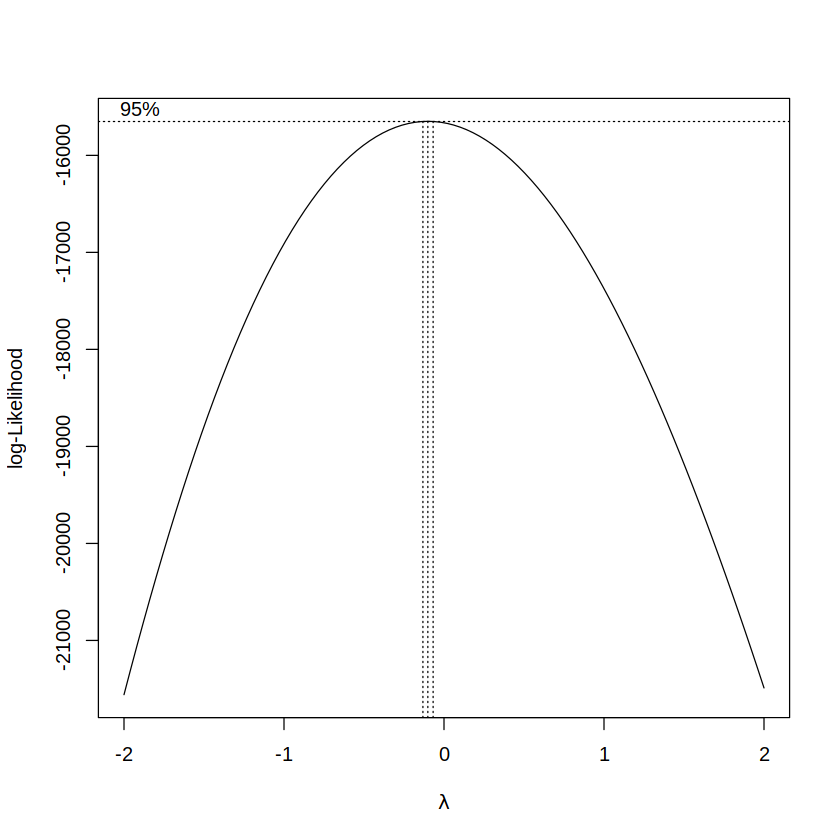

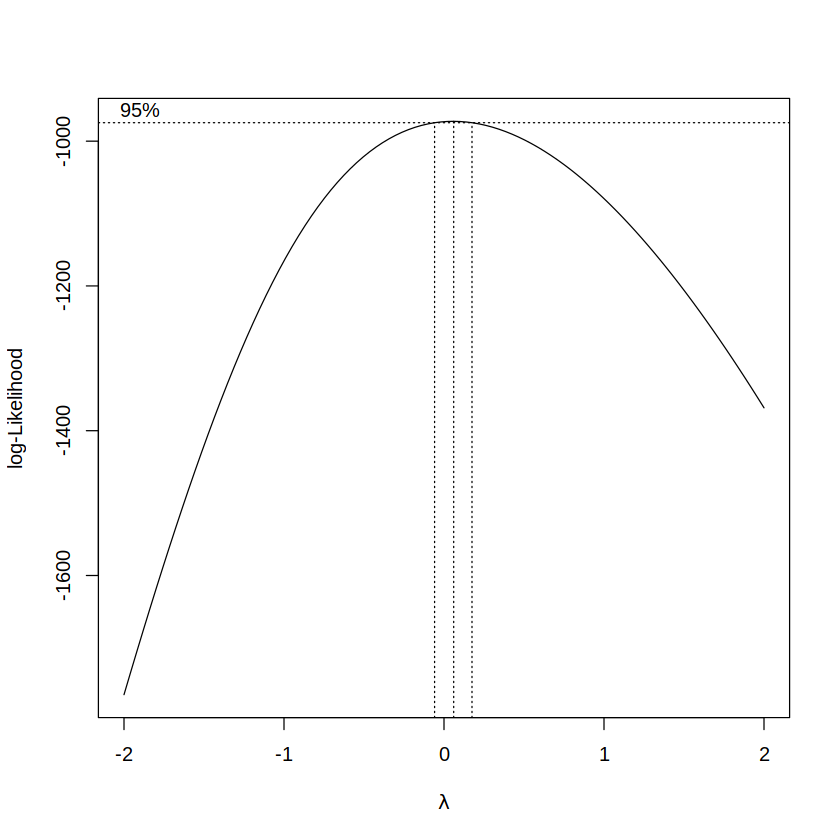

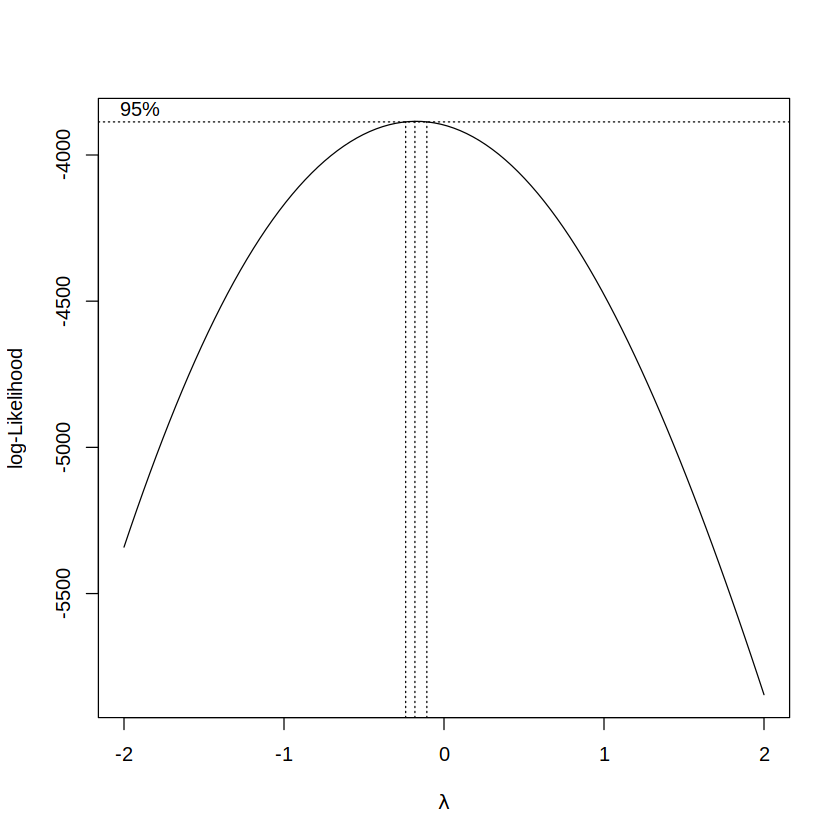

In [28]:
# Apply boxcox() function to the adjusted residuals to determine optimal lambda
#for transforming the IRT variable in a subsequent step
boxcox_results <- subject_data_with_residuals %>%
  mutate(
    boxcox_fit = map(data, ~ boxcox(adjusted_residuals ~ 1, data = .x))
  )

In [29]:
# Extract the optimal lambda for Box-Cox transformation
subject_lambda <- boxcox_results %>%
  mutate(
    optimal_lambda = map_dbl(boxcox_fit, ~ .x$x[which.max(.x$y)])
  )

In [30]:
# Save the results
saveRDS(subject_lambda, "subject_lambda.rds") #use readRDS() to skip the above steps
#subject_lambda <- readRDS("subject_lambda.rds")

In [31]:
# View the column names of subject_lambda to confirm its structure
colnames(subject_lambda)

[1] "subject"        "data"           "model"          "residuals"     
[5] "boxcox_fit"     "optimal_lambda"

In [36]:
# View the optimal lambda for the first subject
subj1_lambda <- subject_lambda$optimal_lambda[[1]]
print(subj1_lambda)

[1] -0.1414141


In [39]:
# Define the Box-Cox transformation function
apply_boxcox <- function(irt, lambda) {
  if (lambda == 0) {
    irt_bx <- log(irt)
  } else {
    irt_bx <- (irt^lambda - 1) / lambda
  }
  return(irt_bx)
}

# Apply the Box-Cox transformation to the IRT values using the subject-specific optimal lambda
subject_data_with_boxcox <- subject_lambda %>%
  mutate(
    data = map2(data, optimal_lambda, ~ {
      .x %>%
        mutate(IRT_bx = apply_boxcox(IRT, .y))
    })
  )

In [40]:
# View the residuals for the first subject
subj1_data <- subject_data_with_boxcox$data[[1]]
head(subj1_data)

X Unnamed..0.2 Unnamed..0.1 Unnamed..0 intrusion item_name item_num rectime
1 2 2            2            30         0         DAUGHTER   442     3811   
2 3 3            3            31         0         BLUEPRINT  142     5559   
3 4 4            4            32         0         TRACTOR   1493     6242   
4 5 5            5            33         0         SCALPEL   1243     7089   
5 6 6            6            34         0         IGLOO      734     9348   
6 7 7            7            35         0         CANAL      226     9957   
  serialpos session ⋯ LagC IRT1_range     IRT1C  IRT2_range     IRT2C 
1  4        0       ⋯  1   (0.84, 0.985]  0.9125 (0.683, 0.833] 0.7580
2  5        0       ⋯  1   (0.985, 1.137] 1.0610 (0.833, 0.974] 0.9035
3  6        0       ⋯  1   (1.541, 1.904] 1.7225 (1.121, 1.288] 1.2045
4  7        0       ⋯  1   (0.004, 0.688] 0.3460 (1.503, 1.835] 1.6690
5 23        0       ⋯ 13   (0.84, 0.985]  0.9125 (0.024, 0.683] 0.3535
6 20        0       ⋯  3   (1.904, 2.635] 2.2695 (0.833, 0.974] 0.9035
  abs_lag_ln_std SemanticSimC_std residuals  adjusted_residuals IRT_bx    
1 -0.9534417      0.5317468        3.2198029 14.838689           0.1229054
2 -0.9534417     -1.1361238        2.4718226 14.090709           0.5369886
3 -0.9534417     -1.1361238        0.8693397 12.488226          -0.3917256
4 -0.9534417     -0.3752370        1.2660061 12.884892          -0.1680196
5  1.8194913     -1.1361238       -4.2627258  7.356161           0.7697188
6  0.1453070     -0.5783372       -2.8674344  8.751452          -0.5137414

In [41]:
saveRDS(subject_data_with_boxcox, "subject_data_with_boxcox.rds")

In [61]:
# Initialize an empty list to store the individual data frames
list_of_data_frames <- list()

# Iterate over each row in the subject_data_with_boxcox to extract the data frames
for (i in 1:nrow(subject_data_with_boxcox)) {
  subject <- subject_data_with_boxcox$subject[i]
  data_frame <- subject_data_with_boxcox$data[[i]]
  
  # Add a column for the subject identifier
  data_frame$subject <- subject
  
  # Append the data frame to the list
  list_of_data_frames[[i]] <- data_frame
}

# Combine all individual data frames into one single data frame
combined_data <- bind_rows(list_of_data_frames)

# Verify the combined data
#head(combined_data)

In [63]:
write.csv(combined_data, "IRT_data_main.csv", row.names = FALSE) 

In [ ]:
combined_data <- read.csv("IRT_data_main.csv") #to skip the above steps


Family: gaussian 
Link function: identity 

Formula:
IRT_bx ~ s(OutputPosition, k = 5) + s(total_recall, k = 5) + 
    ti(OutputPosition, total_recall) + abs_lag_ln_std + SemanticSimC_std + 
    ti(abs_lag_ln_std, SemanticSimC_std) + s(IRT1C, k = 3) + 
    s(IRT2C, k = 3)

Parametric coefficients:
                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)       0.255917   0.069293    3.693 0.000221 ***
abs_lag_ln_std    0.268973   0.001049  256.291  < 2e-16 ***
SemanticSimC_std -0.135519   0.001032 -131.319  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                       edf Ref.df      F p-value    
s(OutputPosition)                    4.000  4.000  423.7  <2e-16 ***
s(total_recall)                      3.735  3.955  195.6  <2e-16 ***
ti(OutputPosition,total_recall)     16.000 16.000  455.3  <2e-16 ***
ti(abs_lag_ln_std,SemanticSimC_std) 11.029 12.938  334.8  <2e-16 ***
s(IRT


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 12 iterations.
The RMS GCV score gradient at convergence was 6.334132e-08 .
The Hessian was positive definite.
Model rank =  47 / 47 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                                       k'   edf k-index p-value
s(OutputPosition)                    4.00  4.00    1.01    0.67
s(total_recall)                      4.00  3.74    1.00    0.60
ti(OutputPosition,total_recall)     16.00 16.00    0.99    0.25
ti(abs_lag_ln_std,SemanticSimC_std) 16.00 11.03    1.01    0.77
s(IRT1C)                             2.00  2.00    0.99    0.28
s(IRT2C)                             2.00  2.00    0.98    0.12


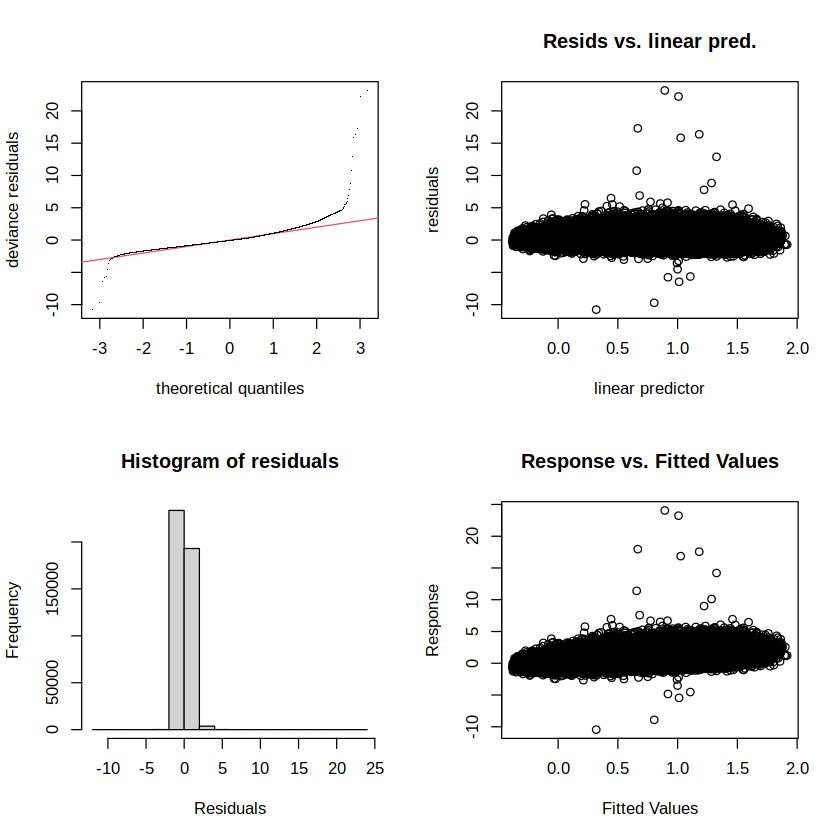

In [ ]:
###Fit fixed-effects only model to full data to identify influential observations###
#library(mgcv)


model_FE <- gam(IRT_bx ~ s(OutputPosition, k=5) + s(total_recall, k=5) + 
                          ti(OutputPosition, total_recall) + abs_lag_ln_std + 
                          SemanticSimC_std + ti(abs_lag_ln_std, SemanticSimC_std) + s(IRT1C, k=3) + s(IRT2C, k=3),
                          data = combined_data)

# Summary of the standardized model
summary(model_FE)

# Diagnostic plots
par(mfrow = c(2, 2))
gam.check(model_FE)

In [4]:
# Identify outliers based on residuals
outliers <- combined_data %>% 
  mutate(residuals = residuals(model_FE)) %>% 
  filter(abs(residuals) > 3*sd(residuals))

# View the outliers
head(outliers)
# Print the lengths for verification
length(outliers) #45 outliers


X   Unnamed..0.2 Unnamed..0.1 Unnamed..0 intrusion item_name item_num rectime
1  87  87          127975         338      0         COIN       343     64146  
2 105 105          158695         412      0         PASTRY    1022     70856  
3 141 141          182808         586      0         DONOR      485     61888  
4 167 167          127987         695      0         POISON    1096     55036  
5 273 273          128019        1140      0         TWISTER   1530     70179  
6 519 519          223791       10473      0         MAPLE      866     32172  
  serialpos session ⋯ IRT1_range     IRT1C  IRT2_range      IRT2C 
1 13        0       ⋯ (0.985, 1.137] 1.0610 (2.485, 4.165]  3.3250
2  3        0       ⋯ (1.137, 1.311] 1.2240 (0.833, 0.974]  0.9035
3 17        0       ⋯ (0.84, 0.985]  0.9125 (4.165, 69.554] 9.1650
4  7        0       ⋯ (0.688, 0.84]  0.7640 (4.165, 69.554] 9.1650
5 20        1       ⋯ (0.688, 0.84]  0.7640 (2.485, 4.165]  3.3250
6  1        2       ⋯ (0.004, 0.688] 0.3460 (0.024, 0.683]  0.3535
  abs_lag_ln_std SemanticSimC_std residuals adjusted_residuals IRT_bx   subject
1 0.6561961      -0.3752370       2.123134  55.84413           3.015499 LTP093 
2 1.3494293      -0.5783372       2.053162  63.10684           3.124133 LTP093 
3 0.9927101      -1.1361238       2.028752  56.32450           3.022907 LTP093 
4 0.6561961      -0.7793262       2.110506  46.21953           2.875551 LTP093 
5 0.4330248       0.5317468       2.163322  53.33953           2.987838 LTP093 
6 1.8801234       1.2706768       2.370006  33.61744           2.684427 LTP093

[1] 45

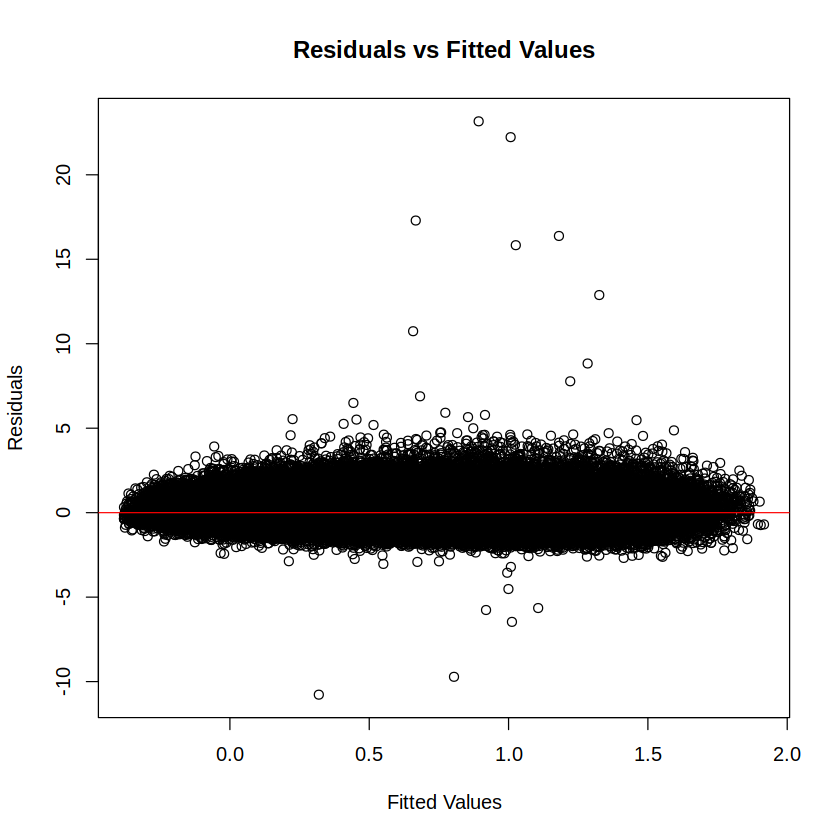

In [68]:
# Plot residuals vs fitted values to check for heteroscedasticity
plot(model_FE$fitted.values, residuals(model_FE), 
     xlab = "Fitted Values", ylab = "Residuals", main = "Residuals vs Fitted Values")
abline(h = 0, col = "red")

#a few outlying observations are apparent but unclear if they exert great leverage

ERROR: Error in shapiro.test(residuals(model_FE)): sample size must be between 3 and 5000


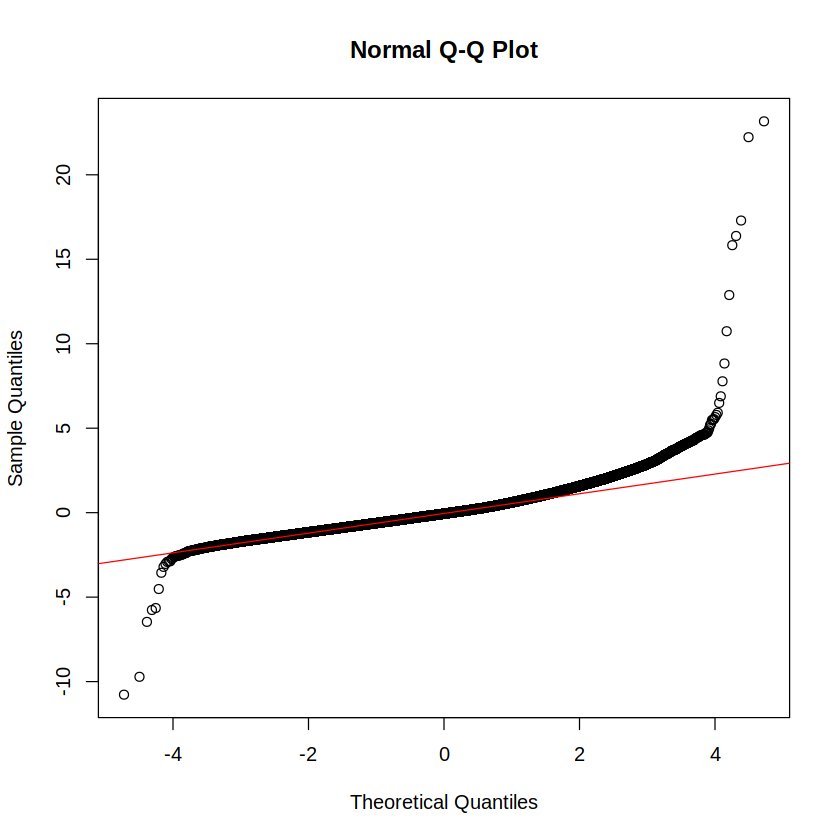

In [69]:
#Check Normality of Residuals
qqnorm(residuals(model_FE))
qqline(residuals(model_FE), col = "red")

#clear violations in the tails


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




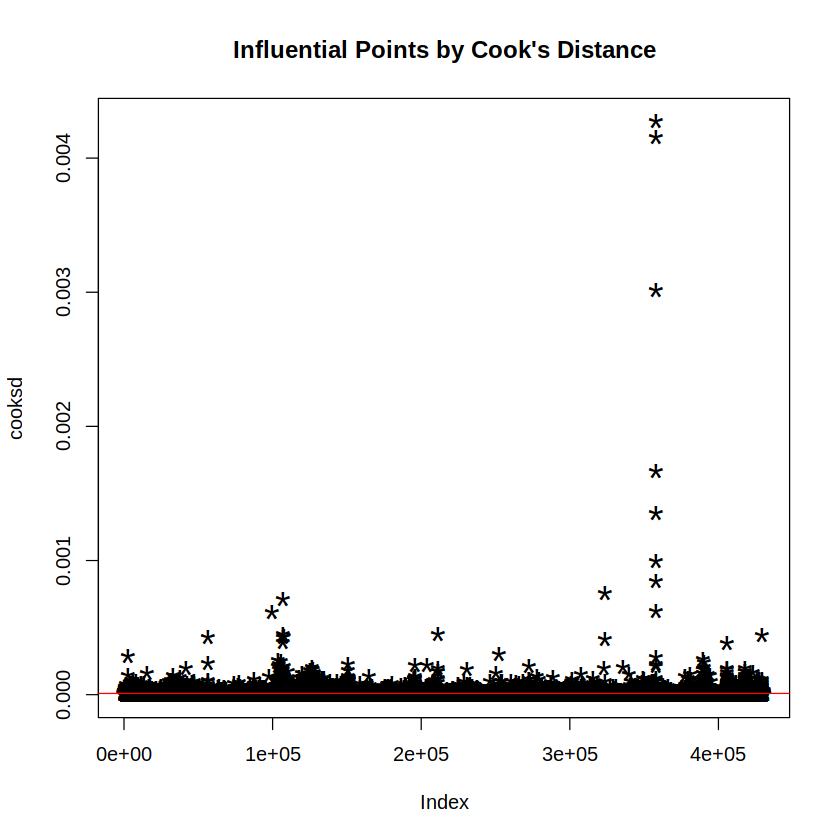

In [5]:
library(car)

# Cook's distance to identify influential points
cooksd <- cooks.distance(model_FE)
influential <- as.numeric(names(cooksd)[(cooksd > (4 / nrow(combined_data)))])

# Plot Cook's distance
plot(cooksd, pch="*", cex=2, main="Influential Points by Cook's Distance")
abline(h = 4/nrow(combined_data), col="red")

In [6]:
# Identify influential points
influential_points <- which(cooksd > (4 / nrow(combined_data)))

# Extract the influential points
influential_data <- combined_data[influential_points, ]

# View some of the influential points
head(influential_data) #also 45 influential obs

X   Unnamed..0.2 Unnamed..0.1 Unnamed..0 intrusion item_name item_num
16  19  19              19        75        0         DRAWING    494    
38  43  43           30859       127        0         COURSE     390    
63  76  76          109202       299        0         CUSTARD    429    
72  87  87          127975       338        0         COIN       343    
75  90  90          127978       341        0         FEMALE     559    
86 105 105          158695       412        0         PASTRY    1022    
   rectime serialpos session ⋯ IRT1_range      IRT1C  IRT2_range     IRT2C 
16  4985    1        0       ⋯ (0.688, 0.84]   0.7640 (1.121, 1.288] 1.2045
38 65934   16        0       ⋯ (0.84, 0.985]   0.9125 (1.835, 2.485] 2.1600
63 24071    3        0       ⋯ (0.688, 0.84]   0.7640 (0.683, 0.833] 0.7580
72 64146   13        0       ⋯ (0.985, 1.137]  1.0610 (2.485, 4.165] 3.3250
75 73444   21        0       ⋯ (4.625, 70.384] 9.6250 (0.024, 0.683] 0.3535
86 70856    3        0       ⋯ (1.137, 1.311]  1.2240 (0.833, 0.974] 0.9035
   abs_lag_ln_std SemanticSimC_std residuals adjusted_residuals IRT_bx    
16  2.1824418     -0.7793262       -8.808573  2.810313          -0.1197868
38  1.2440557     -0.3752370       24.488490 36.107377           2.7805222
63  1.2440557      0.5317468        9.666025 21.284912           2.3359143
72  0.6561961     -0.3752370       44.225240 55.844126           3.0154989
75 -0.2602084     -0.7793262       -3.925349  7.693537          -0.6851162
86  1.3494293     -0.5783372       51.487959 63.106845           3.1241326
   subject
16 LTP093 
38 LTP093 
63 LTP093 
72 LTP093 
75 LTP093 
86 LTP093

In [7]:
# Find common points between influential points and outliers
common_points <- intersect(influential_points, which(abs(residuals(model_FE)) > 3 * sd(residuals(model_FE))))
common_data <- combined_data[common_points, ]

# View common points
head(common_data) #all 45 outliers are also influential points

X   Unnamed..0.2 Unnamed..0.1 Unnamed..0 intrusion item_name item_num
72   87  87          127975         338      0         COIN       343    
86  105 105          158695         412      0         PASTRY    1022    
112 141 141          182808         586      0         DONOR      485    
132 167 167          127987         695      0         POISON    1096    
218 273 273          128019        1140      0         TWISTER   1530    
414 519 519          223791       10473      0         MAPLE      866    
    rectime serialpos session ⋯ IRT1_range     IRT1C  IRT2_range      IRT2C 
72  64146   13        0       ⋯ (0.985, 1.137] 1.0610 (2.485, 4.165]  3.3250
86  70856    3        0       ⋯ (1.137, 1.311] 1.2240 (0.833, 0.974]  0.9035
112 61888   17        0       ⋯ (0.84, 0.985]  0.9125 (4.165, 69.554] 9.1650
132 55036    7        0       ⋯ (0.688, 0.84]  0.7640 (4.165, 69.554] 9.1650
218 70179   20        1       ⋯ (0.688, 0.84]  0.7640 (2.485, 4.165]  3.3250
414 32172    1        2       ⋯ (0.004, 0.688] 0.3460 (0.024, 0.683]  0.3535
    abs_lag_ln_std SemanticSimC_std residuals adjusted_residuals IRT_bx  
72  0.6561961      -0.3752370       44.22524  55.84413           3.015499
86  1.3494293      -0.5783372       51.48796  63.10684           3.124133
112 0.9927101      -1.1361238       44.70562  56.32450           3.022907
132 0.6561961      -0.7793262       34.60065  46.21953           2.875551
218 0.4330248       0.5317468       41.72064  53.33953           2.987838
414 1.8801234       1.2706768       21.99856  33.61744           2.684427
    subject
72  LTP093 
86  LTP093 
112 LTP093 
132 LTP093 
218 LTP093 
414 LTP093

In [8]:
# Remove influential points and outliers from the data
cleaned_data <- combined_data %>%
  filter(!(row_number() %in% common_points))

In [9]:
write.csv(cleaned_data, "IRT_cleaned_main.csv") #to be used for mixed-effects modeling